In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Part 1 - Estimating the value of residential homes from fixed characteristics.

The first goal here is to develop a model to reliably estimate the value of residential houses based on fixed characteristics such as square footage, bedrooms and so on. Characteristics that are renovatable are generally those that can be modified without having to undergo major construction on the house. For example, roof and exterior features, "Quality" metrics (kitchen quality) and so on. 

The full description of all of the features are detailed in `data_description.txt`.


### Loading the initial data

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.shape

(1460, 81)

In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
#Dropping the Id column as it is unneccessary 
house.drop(columns ='Id', inplace=True)

### Taking it out all houses that are not residential

In [6]:
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [7]:
house.drop(house[house.MSZoning.str.startswith('C')].index, inplace=True)

In [8]:
house.shape

(1450, 80)

In [9]:
house.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd             7        Typ           

In [10]:
house.describe(include = 'all')

MSSubClass MSZoning  LotFrontage        LotArea Street Alley  \
count   1450.000000     1450  1191.000000    1450.000000   1450    89   
unique          NaN        4          NaN            NaN      2     2   
top             NaN       RL          NaN            NaN   Pave  Grvl   
freq            NaN     1151          NaN            NaN   1446    50   
mean      56.903448      NaN    70.052897   10523.831724    NaN   NaN   
std       42.265033      NaN    24.301013   10012.185355    NaN   NaN   
min       20.000000      NaN    21.000000    1300.000000    NaN   NaN   
25%       20.000000      NaN    59.000000    7544.500000    NaN   NaN   
50%       50.000000      NaN    70.000000    9496.000000    NaN   NaN   
75%       70.000000      NaN    80.000000   11613.500000    NaN   NaN   
max      190.000000      NaN   313.000000  215245.000000    NaN   NaN   

       LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
count      1450        1450      1450      1450      1450         1450   
unique        4           4         2         5         3           25   
top         Reg         Lvl    AllPub    Inside       Gtl        NAmes   
freq        916        1305      1449      1044      1375          225   
mean        NaN         NaN       NaN       NaN       NaN          NaN   
std         NaN         NaN       NaN       NaN       NaN          NaN   
min         NaN         NaN       NaN       NaN       NaN          NaN   
25%         NaN         NaN       NaN       NaN       NaN          NaN   
50%         NaN         NaN       NaN       NaN       NaN          NaN   
75%         NaN         NaN       NaN       NaN       NaN          NaN   
max         NaN         NaN       NaN       NaN       NaN          NaN   

       Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
count        1450       1450     1450       1450  1450.000000  1450.000000   
unique          9          8        5          8          NaN          NaN   
top          Norm       Norm     1Fam     1Story          NaN          NaN   
freq         1252       1436     1211        722          NaN          NaN   
mean          NaN        NaN      NaN        NaN     6.114483     5.582069   
std           NaN        NaN      NaN        NaN     1.372860     1.107330   
min           NaN        NaN      NaN        NaN     1.000000     1.000000   
25%           NaN        NaN      NaN        NaN     5.000000     5.000000   
50%           NaN        NaN      NaN        NaN     6.000000     5.000000   
75%           NaN        NaN      NaN        NaN     7.000000     6.000000   
max           NaN        NaN      NaN        NaN    10.000000     9.000000   

          YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
count   1450.000000   1450.000000      1450     1450        1450        1450   
unique          NaN           NaN         6        8          15          16   
top             NaN           NaN     Gable  CompShg     VinylSd     VinylSd   
freq            NaN           NaN      1135     1424         515         504   
mean    1971.593103   1985.049655       NaN      NaN         NaN         NaN   
std       30.022696     20.552319       NaN      NaN         NaN         NaN   
min     1872.000000   1950.000000       NaN      NaN         NaN         NaN   
25%     1954.000000   1967.000000       NaN      NaN         NaN         NaN   
50%     1973.000000   1994.000000       NaN      NaN         NaN         NaN   
75%     2001.000000   2004.000000       NaN      NaN         NaN         NaN   
max     2010.000000   2010.000000       NaN      NaN         NaN         NaN   

       MasVnrType   MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
count        1442  1442.000000      1450      1450       1450     1413   
unique          4          NaN         4         5          6        4   
top          None          NaN        TA        TA      PConc       TA   
freq          854          NaN       899      127

### Working with the features that are fixed only

Using the information in the `data_description.txt`, I chose all the columns that I deemed as fixed characteristics.

In [11]:
house.columns 

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [12]:
fixed_cols = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType','BsmtFinSF2',
       'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtQual','BsmtExposure', 'BsmtFinSF1', 'TotalBsmtSF',
        '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'PoolArea', 
        'ScreenPorch','MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType','SaleCondition', 'SalePrice']

In [13]:
house_fixed = house.loc[:, fixed_cols].copy()

In [14]:
house_fixed.shape

(1450, 53)

### Dropping all the columns with more than 90% of the same value

I decided to drop all the columns with over 90% of the same value as they were unlikely be a distinguishing feature to predict house prices accurately.

In [15]:
#Runs through all of the features and prints all the features with more 90% of the same value, including Null
remove_features = []
for col in house_fixed.columns: 
    if house_fixed[col].value_counts(dropna=False).iloc[0]/house_fixed[col].value_counts(dropna=False).sum() > 0.90:
        print(house_fixed[col].value_counts(dropna=False),'-------------------------', sep='\n')
        remove_features.append(col)
remove_features

Pave    1446
Grvl       4
Name: Street, dtype: int64
-------------------------
NaN     1361
Grvl      50
Pave      39
Name: Alley, dtype: int64
-------------------------
Gtl    1375
Mod      62
Sev      13
Name: LandSlope, dtype: int64
-------------------------
Norm      1436
Feedr        5
RRNn         2
PosN         2
Artery       2
RRAe         1
RRAn         1
PosA         1
Name: Condition2, dtype: int64
-------------------------
0      1425
80        3
360       2
371       1
53        1
120       1
144       1
156       1
205       1
232       1
234       1
572       1
528       1
390       1
392       1
397       1
420       1
473       1
479       1
481       1
514       1
515       1
384       1
Name: LowQualFinSF, dtype: int64
-------------------------
0    1369
1      79
2       2
Name: BsmtHalfBath, dtype: int64
-------------------------
1    1383
2      64
3       2
0       1
Name: KitchenAbvGr, dtype: int64
-------------------------
Typ     1350
Min2      34
Min1      31

['Street',
 'Alley',
 'LandSlope',
 'Condition2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'Functional',
 '3SsnPorch',
 'PoolArea',
 'ScreenPorch',
 'MiscFeature',
 'MiscVal']

In [16]:
#Dropping the relevant columns
house_fixed.drop(labels = remove_features, axis = 1, inplace=True)

### Dealing with Null values

In the remaining columns, I had to find ways to fill in the null values depending on the context of the columns. 

In [17]:
house_fixed.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
LotShape           0
LandContour        0
LotConfig          0
Neighborhood       0
Condition1         0
BldgType           0
BsmtFinSF2         0
HouseStyle         0
YearBuilt          0
YearRemodAdd       0
Foundation         0
BsmtQual          37
BsmtExposure      38
BsmtFinSF1         0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
GrLivArea          0
BsmtFullBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageType        79
GarageYrBlt       79
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
dtype: int64

Lot Frontage: There were 259 entries with no linear feet of street connected to the property. I assumed this would be a mistake all properties would need some sort of street address. I filled in the null values with the median value of linear street in feet based on MSSubClass (i.e. what kind of property) - preferred over median over mean due to skew. 

In [18]:
house_fixed.groupby('MSSubClass')['LotFrontage'].skew()

MSSubClass
20     3.791228
30     2.917737
40     0.000000
45    -0.161602
50     2.337122
60     4.270146
70     2.244904
75     1.951314
80     0.372845
85     0.206461
90     0.267385
120    0.428336
160    2.744447
180    1.035098
190    0.758657
Name: LotFrontage, dtype: float64

In [19]:
house_fixed.LotFrontage = house_fixed.groupby(
    'MSSubClass')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

There was one entry where there might have been a mistake where the basement quality was 'Gd' but basement exposure
was listed as null. For a basement quality of 'Gd', the most frequent value for basement exposure is 'No' (No exposure) so I replaced the incorrect null value with this.

In [20]:
mistake = house_fixed[~house_fixed.BsmtQual.isnull(
) & house_fixed.BsmtExposure.isnull()].index
house_fixed.loc[mistake, 'BsmtExposure'] = house_fixed[house_fixed.BsmtQual ==
                                                       'Gd']['BsmtExposure'].value_counts().index[0]

For some of the variables such as Basement Quality (height), Basement Exposure and GarageType, the `pd.read_csv()` read in NA as NaN so I just changed these values back to NoB and NoG. 

In [21]:
house_fixed.BsmtQual.fillna('NoB', inplace=True) 
house_fixed.BsmtExposure.fillna('NoB', inplace=True) 
house_fixed.GarageType.fillna('NoG', inplace=True) 

For the Garage Year Built, some of the values are null where there is no garage. I tried a few different things for this one but best solution in terms of the score was to match the year the house was built. I didn't like this solution much as it doesn't capture that fact that there is no garage but given it was 79 values and GarageType captured no garage, I decided to stick to this. Other methods I tried factorizing and setting the null values to 0. 

Before filling in the null values, there were a few values that were incorrect as some had garages supposedly built before the house. So I corrected these to match the year the house was built for the built-in garages but left the detached garages as they were as this could be possible.

In [22]:
mistakes = house_fixed[(house_fixed.GarageYrBlt < house_fixed.YearBuilt) & 
                       (house_fixed.GarageType == 'BuiltIn')].index

house_fixed.loc[mistakes, 'GarageYrBlt'] = house_fixed.YearBuilt

In [23]:
house_fixed.loc[house_fixed[house_fixed.GarageYrBlt.isnull()].index, 'GarageYrBlt'] = house_fixed.YearBuilt

### Correlation heatmap

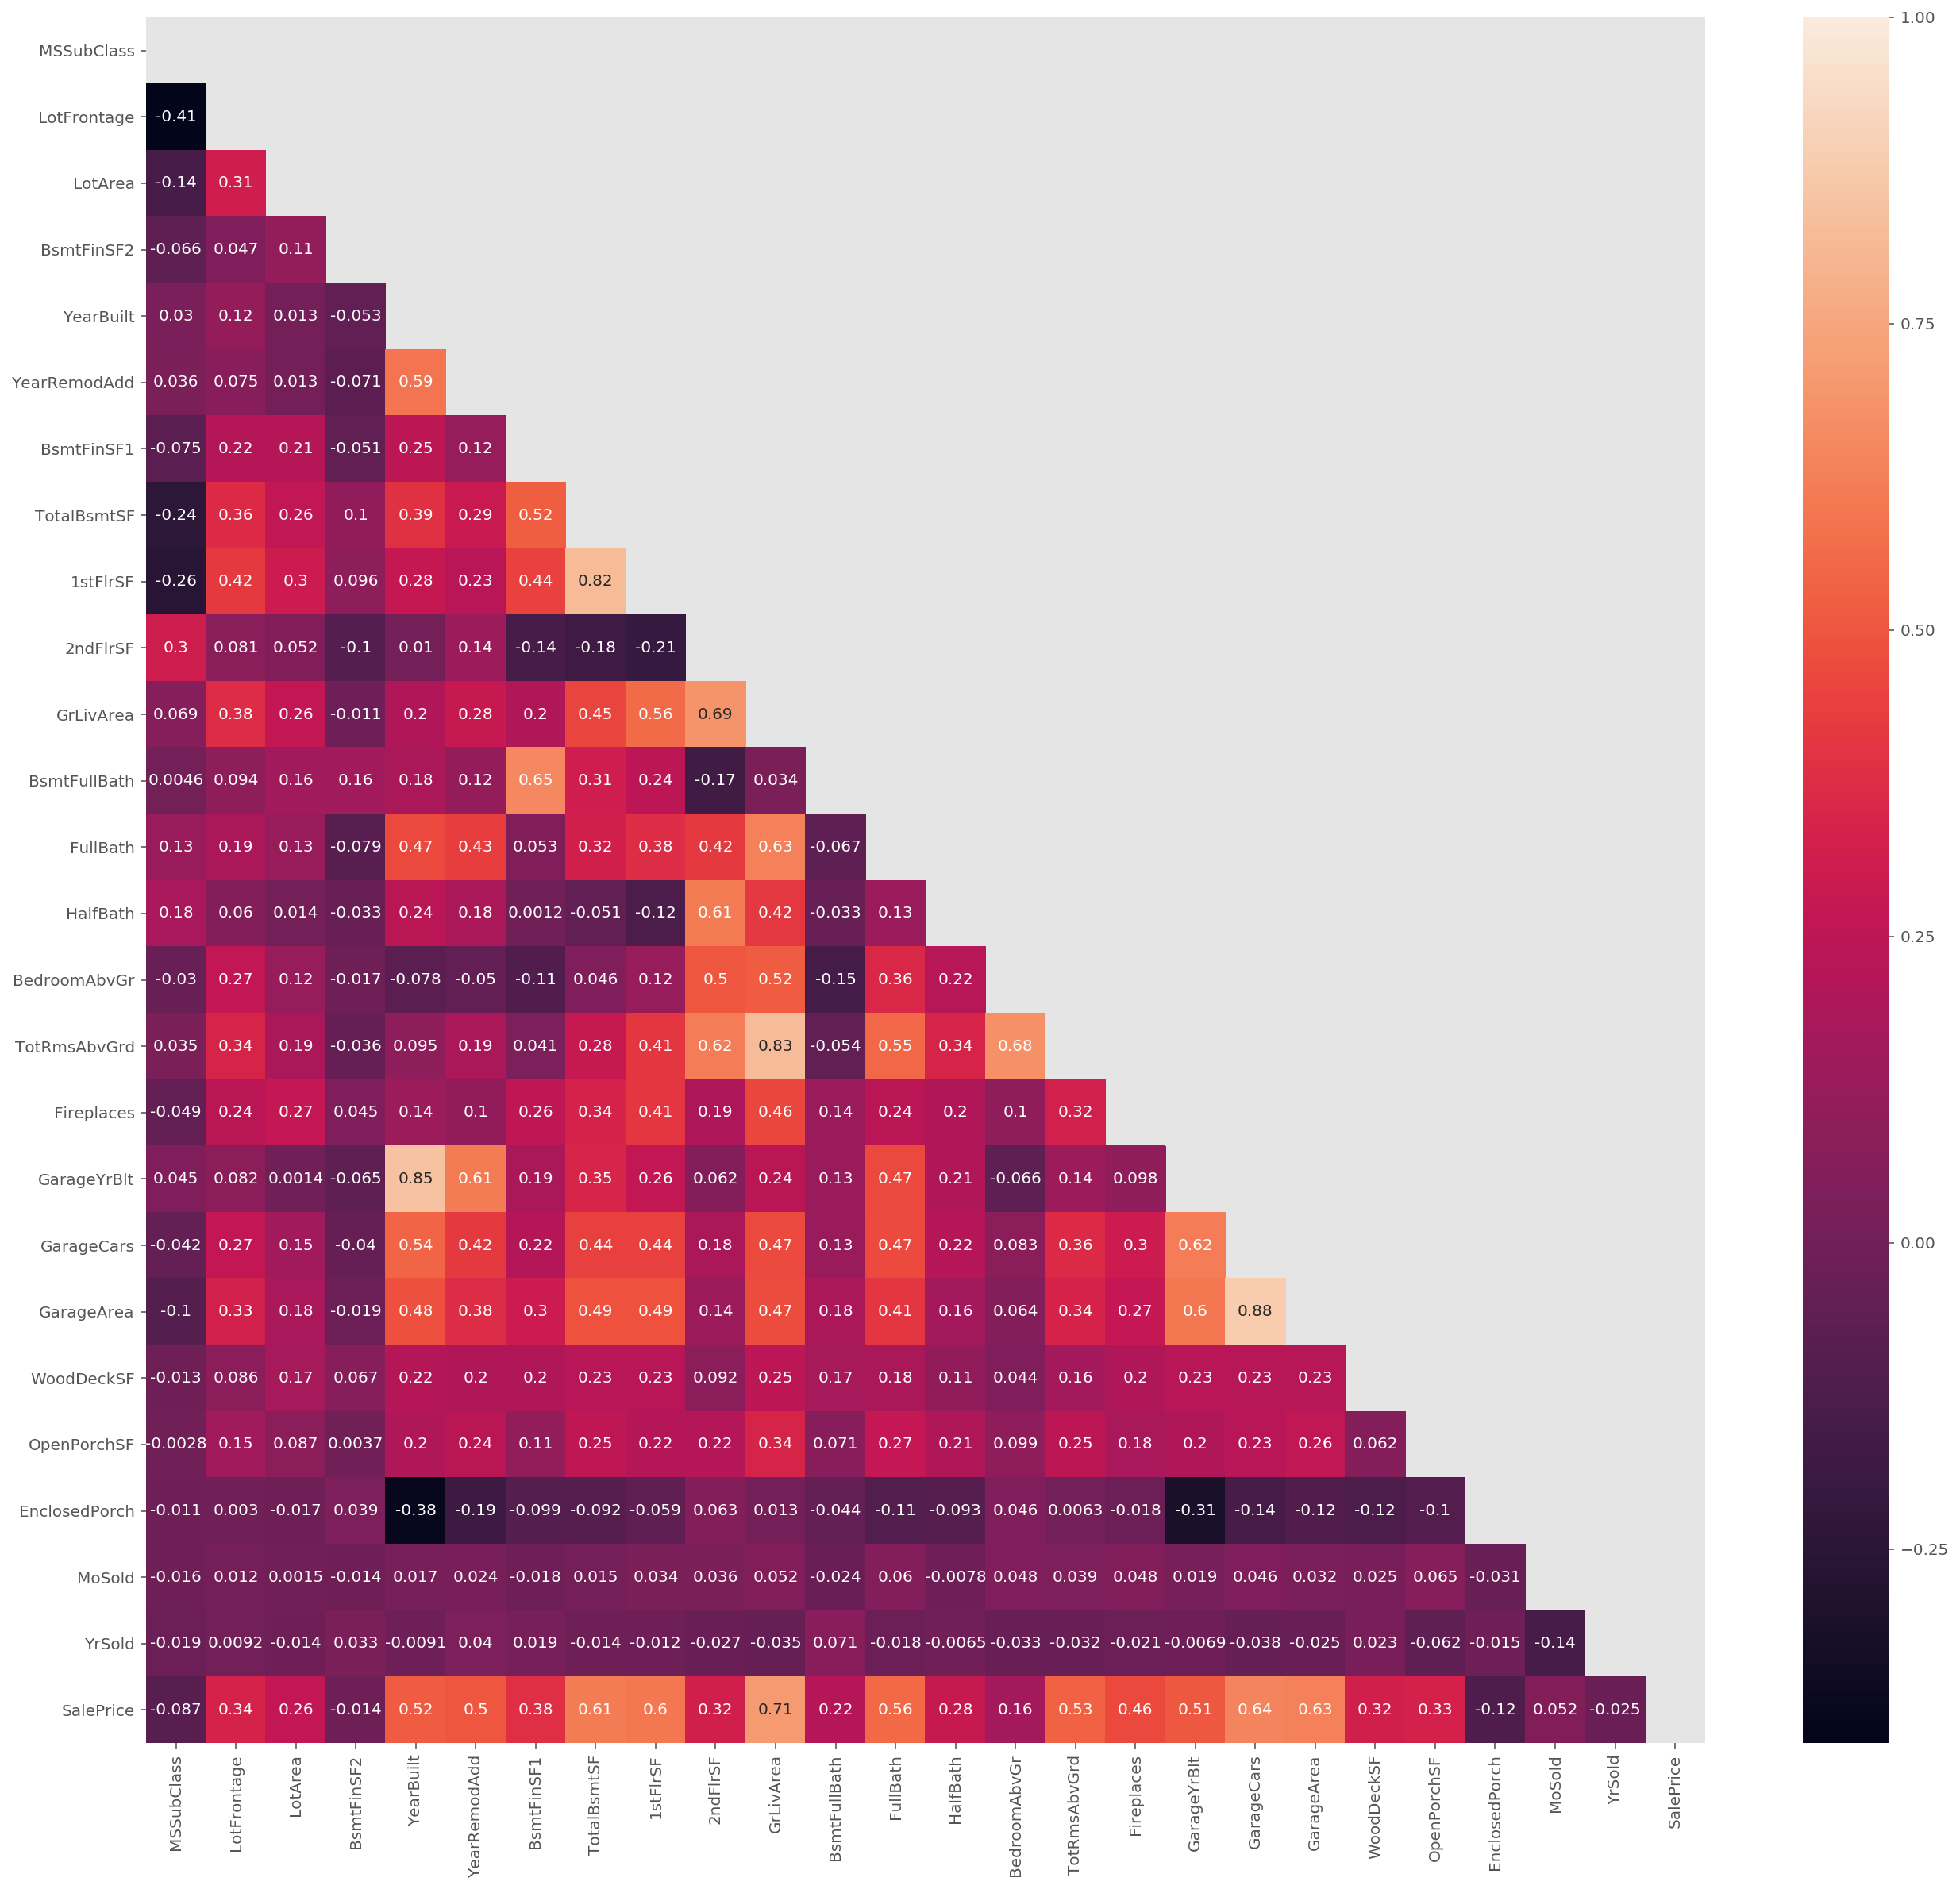

In [24]:
house_fxd_corr = house_fixed.corr()
fig, ax = plt.subplots(figsize=(22, 20))
mask = np.zeros_like(house_fxd_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(house_fxd_corr, mask=mask, annot=True, ax=ax)
ax.set_ylim([house_fxd_corr.shape[1], 0])
plt.show()

In [25]:
house_fixed.columns 

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
       'BsmtFinSF2', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
       'SalePrice'],
      dtype='object')

### Choosing variables to factorize


I tried various things here to try to capture some of the categorical variables numerically. I plotted some of the categorical variables to see if I can identify a scale that I can apply to the numerical factorizing.  Factorizing and then squaring Basement Exposure worked as getting 'Gd' as a score was worth more than an increment of 1 vs a score of 'Av'.

In [26]:
house_fixed.select_dtypes(include='object').columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'Foundation', 'BsmtQual',
       'BsmtExposure', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype='object')

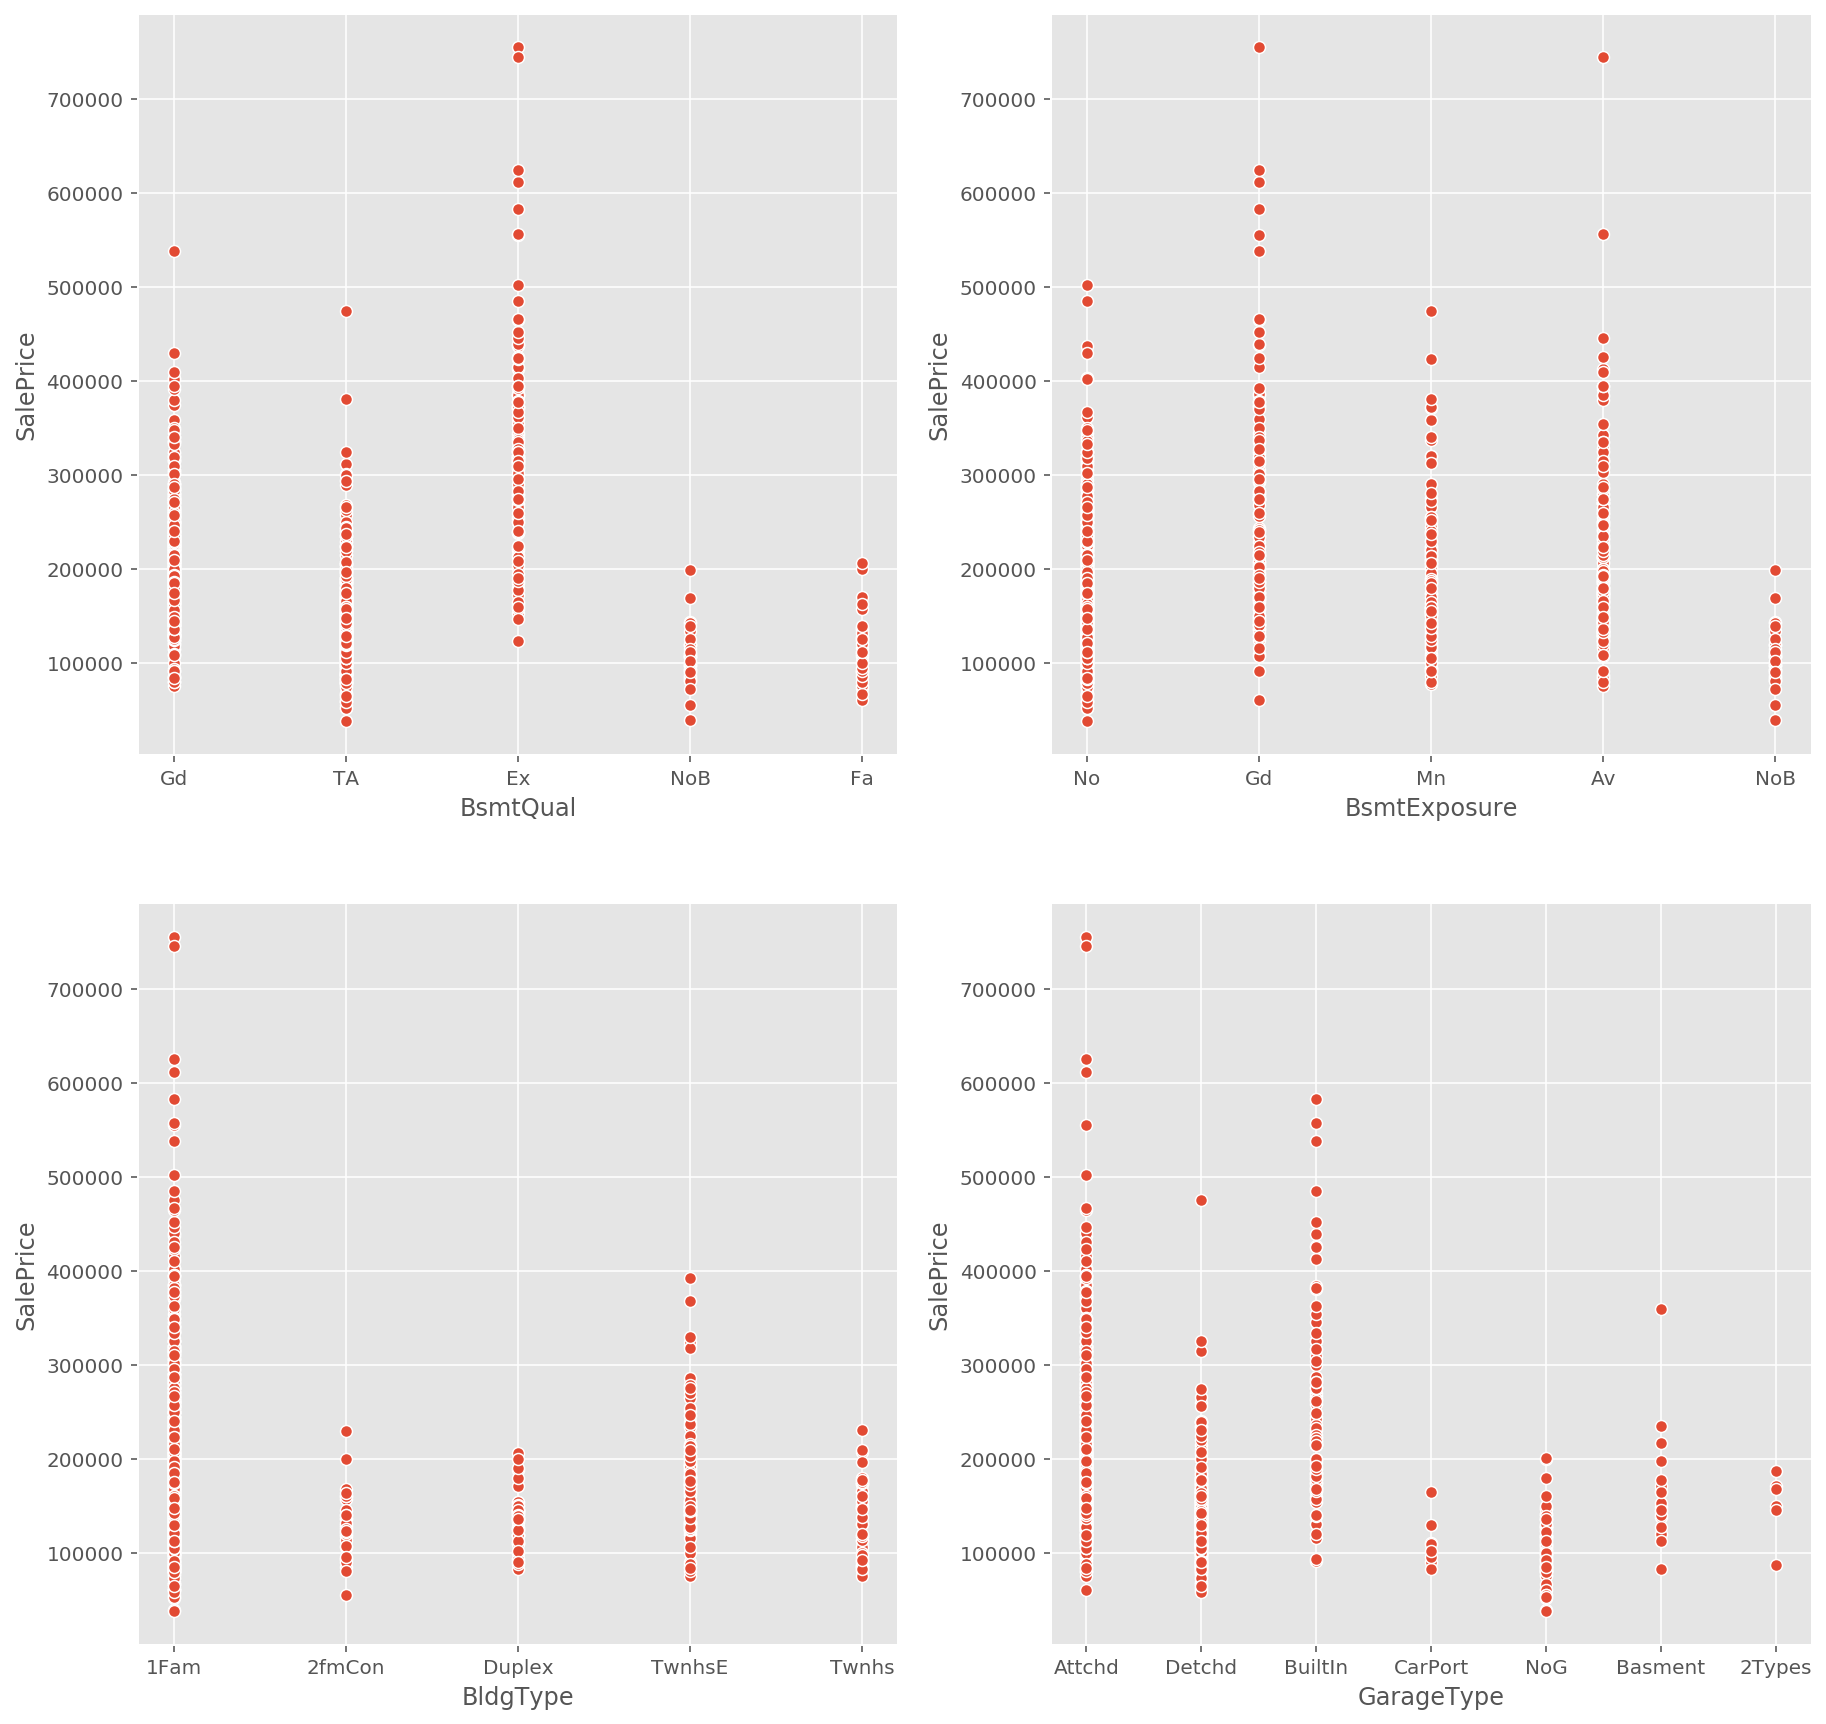

In [27]:
fig1, ax1 = plt.subplots(nrows=2, ncols =2, figsize=(15,15))
sns.scatterplot(house_fixed.BsmtQual, house_fixed.SalePrice, ax = ax1[0,0])
ax1[0,1]=sns.scatterplot(house_fixed.BsmtExposure, house_fixed.SalePrice, ax = ax1[0,1])
ax1[1,0]=sns.scatterplot(house_fixed.BldgType, house_fixed.SalePrice, ax = ax1[1,0])
ax1[1,1]=sns.scatterplot(house_fixed.GarageType, house_fixed.SalePrice, ax = ax1[1,1])
plt.show()

In [28]:
house_fixed.BsmtExposure = house_fixed.BsmtExposure.map({'Gd':25, 'Av':16, 'Mn':9, 'No':4, 'NoB':1})

### Interaction Elements

Here too, I did a lot of experimenting on what had an impact on the score. After noticing that the square feet for basement, ground floor living area, 1st and 2nd floor had massive impact, I added these up together to form 'total_sqft' as a column. Then I dropped those columns as well as Total Rooms Above Grade and Basement Finished Square Feet as these were very correlated. This helped boost the final score. 

In [29]:
house_fixed['total_sqft'] = house_fixed.GrLivArea + house_fixed['1stFlrSF'] + house_fixed['2ndFlrSF'] + house_fixed.TotalBsmtSF

In [30]:
house_fixed.drop(['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'], axis=1, inplace=True)

In [31]:
#Since its very correlated to total_sqft
house_fixed.drop('TotRmsAbvGrd', axis=1, inplace=True)
house_fixed.drop(['BsmtFinSF2','BsmtFinSF1'], axis=1, inplace=True)

In [32]:
house_fixed.columns 

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
       'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtQual',
       'BsmtExposure', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'SalePrice', 'total_sqft'],
      dtype='object')

### Dummifying all the categorical variables

In [33]:
to_dummify = list(house_fixed.select_dtypes(include = 'object').columns)
to_dummify += ['MSSubClass']
to_dummify

['MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'Foundation',
 'BsmtQual',
 'GarageType',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

### Checking for skew

Next I checked all the independent variables and dependent variable for skew. Only Lot Area was very skewed with a value of 12.2. The dependent variables, SalePrice, also didn't have a normal distribution, which is one of the asssumptions of linear regression, so I took the natural log of both. 

In [34]:
house_fixed.skew()

MSSubClass        1.400206
LotFrontage       2.126584
LotArea          12.176209
YearBuilt        -0.626327
YearRemodAdd     -0.514579
BsmtExposure      1.413119
BsmtFullBath      0.588015
FullBath          0.037417
HalfBath          0.668103
BedroomAbvGr      0.211170
Fireplaces        0.641780
GarageYrBlt      -0.691990
GarageCars       -0.342681
GarageArea        0.162739
WoodDeckSF        1.532311
OpenPorchSF       2.233622
EnclosedPorch     3.141910
MoSold            0.219567
YrSold            0.098347
SalePrice         1.908416
total_sqft        1.639696
dtype: float64

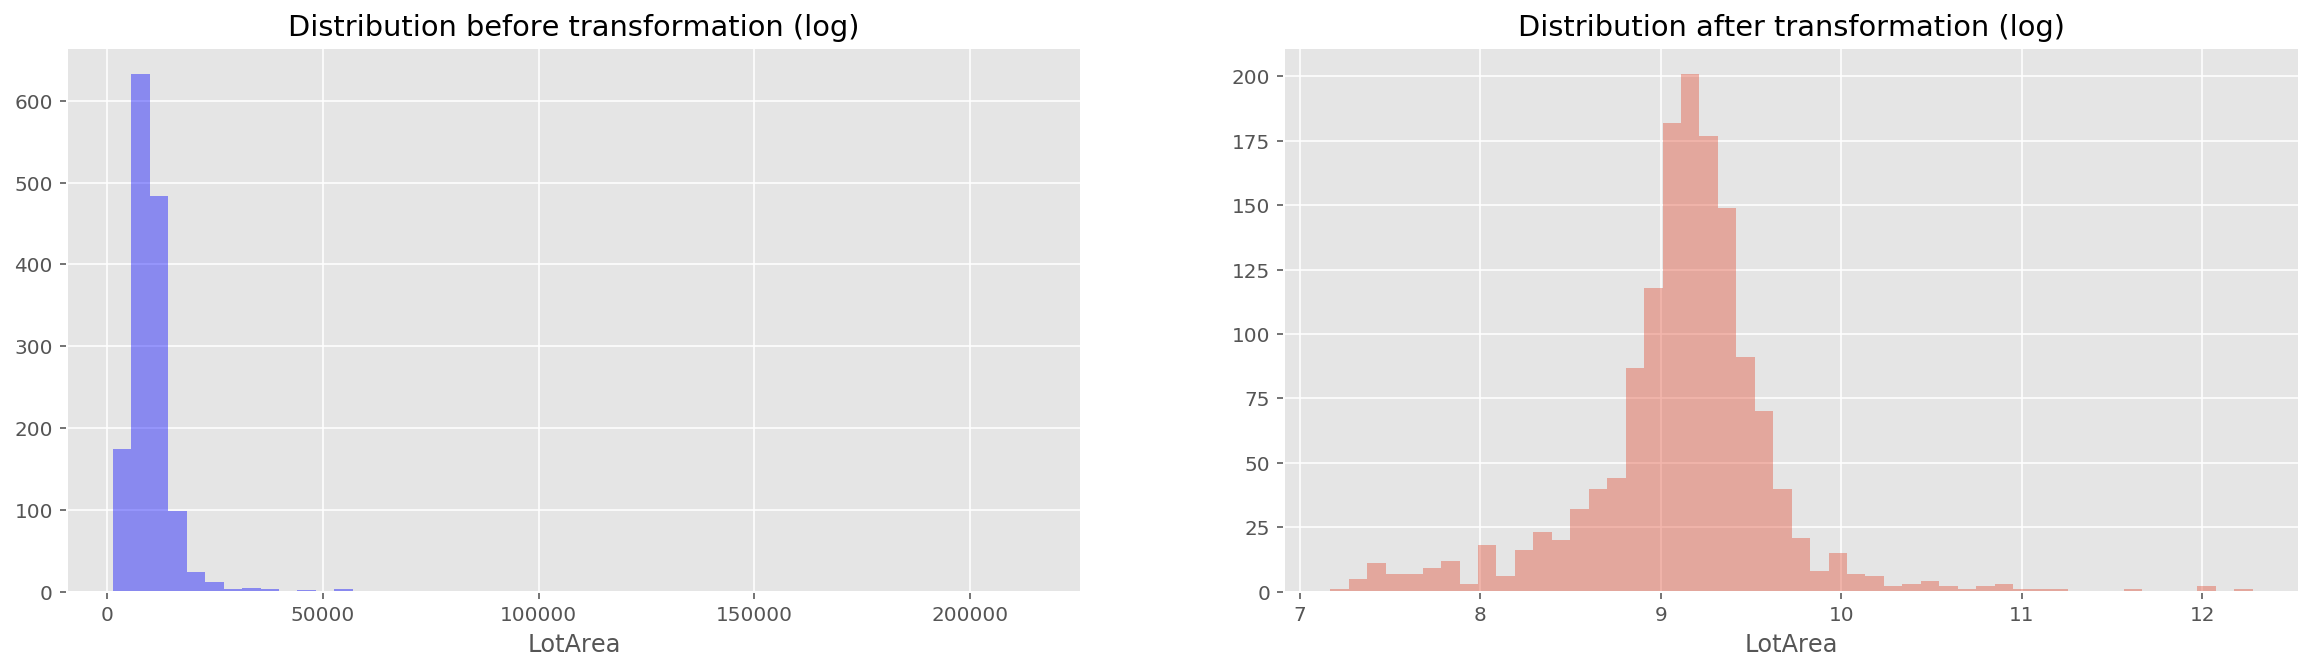

In [35]:
fig, ax = plt.subplots(ncols = 2, figsize= (20, 5))
sns.distplot(house_fixed.LotArea, kde=False, color ='b', ax= ax[0])
ax[0].set_title('Distribution before transformation (log)')
sns.distplot(np.log(house_fixed.LotArea), kde=False, ax = ax[1])
ax[1].set_title('Distribution after transformation (log)')
plt.show()

In [36]:
house_fixed.LotArea = np.log(house_fixed.LotArea)

### Adjusting the Distribution of Y (Sale Price)

In [37]:
new_y = np.log(house_fixed.SalePrice)

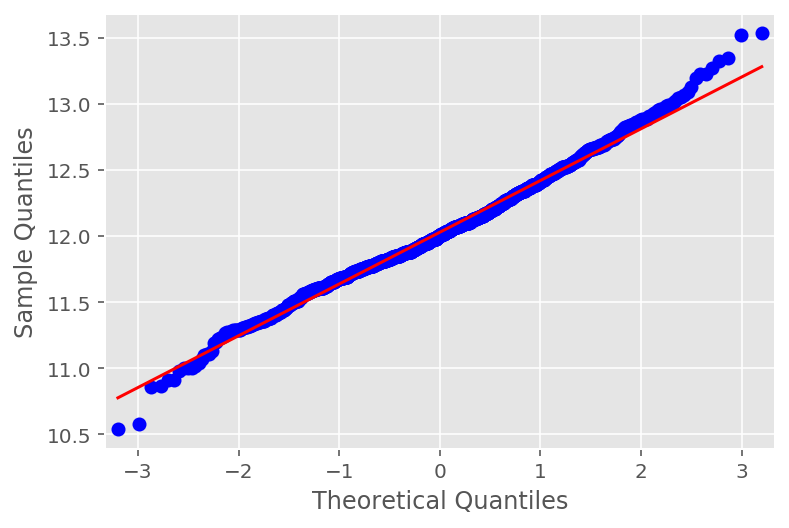

In [38]:
#Checking for normality 
import statsmodels.api as sm 
sm.qqplot(new_y, line='s');

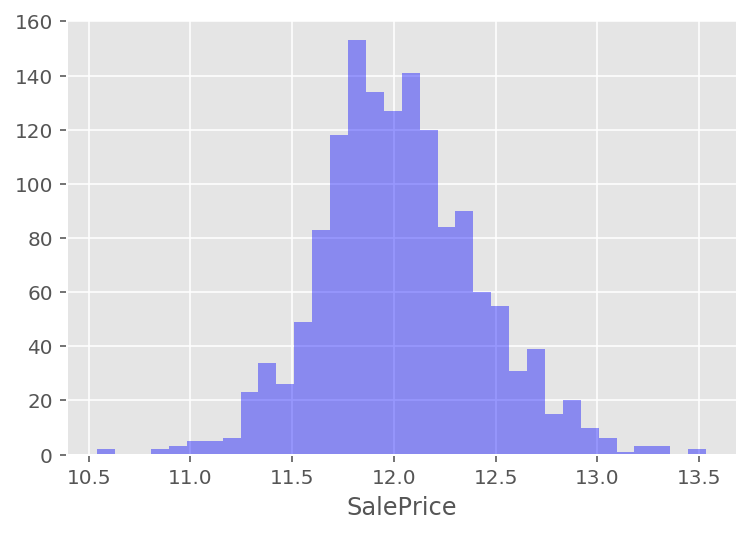

In [39]:
sns.distplot(new_y, kde=False, color ='b')
plt.show()

### Dummifying variables

In [40]:
house_fixed_dum = pd.get_dummies(house_fixed, columns = to_dummify, drop_first = True)

In [41]:
house_fixed_dum.head(15)
house_fixed_dum.shape

(1450, 118)

### Splitting the data

As per the specification, we are training with pre-2010 data and testing with post-2010 data.

In [42]:
X_pre_2010 = house_fixed_dum[house_fixed_dum.YrSold < 2010]
y_pre_2010 = np.log(X_pre_2010.pop('SalePrice'))

X_post_2010 = house_fixed_dum[house_fixed_dum.YrSold >= 2010]
y_post_2010 = np.log(X_post_2010.pop('SalePrice'))

In [43]:
X_pre_2010.shape, X_post_2010.shape, y_pre_2010.shape, y_post_2010.shape

((1278, 117), (172, 117), (1278,), (172,))

### Scaling the data

In [44]:
scaler = StandardScaler()
X_pre_std = pd.DataFrame(scaler.fit_transform(X_pre_2010), index = X_pre_2010.index, columns = X_pre_2010.columns)
X_post_std = pd.DataFrame(scaler.transform(X_post_2010), index = X_post_2010.index, columns = X_post_2010.columns)

### KFold for shuffling train data

This is especially important in this case as we didn't do a random train and test split here so it is good practise to shuffle to truly randomise the data . 

In [45]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

### Linear Regression - best score: -2.681963e+23

I first fit a linear regression model with no regularisation and visualise the coefficients - the cv score was terrible without regularisation!

In [47]:
linreg = LinearRegression()
linreg.fit(X_pre_std, y_pre_2010)

train_score = linreg.score(X_pre_std, y_pre_2010)
test_score = linreg.score(X_post_std, y_post_2010)

#Cross Validation 
cv_score = cross_val_score(linreg, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {linreg.intercept_}')
print(f'Model coeff: {linreg.coef_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Model intercept: 12.032355644349652
Model coeff: [-2.20907335e-02  3.60391343e-02  3.96390177e-02  5.26183166e-02
  2.24688628e-02  2.71932328e-02  3.28950302e-02  2.69744107e-02
  9.88773604e-03  3.27824829e-02 -7.67892342e-03  4.60931568e-02
  8.45648399e-03  9.67301633e-03  8.55294801e-03  5.73075929e-03
  3.77253342e-03 -7.48584911e-03  1.13279309e-01 -3.14319806e-03
 -1.21907336e-02 -2.10831013e-02  9.38697251e-03 -1.01301531e-02
  3.75427967e-03  1.22855629e-02 -2.18411222e-04  1.40594933e-02
  5.62056125e-03 -1.20223765e-02 -4.62986931e-03 -8.71284591e-04
  6.62962055e-04 -8.08631694e-04 -2.12243482e-03 -4.37302720e-03
 -1.05852702e-02  2.02123110e-02 -3.47517270e-02 -1.55827209e-02
 -8.37251477e-03 -1.78829535e-02 -1.97204447e-02 -1.80888663e-02
  1.32247659e-03 -1.01559253e-02  2.23819306e-02  3.07795292e-02
 -2.33036072e-02 -8.69095189e-03 -1.79705728e-02 -2.36026465e-03
  1.40738311e-02  2.40974794e-02 -2.76314142e-03  5.90911383e-03
 -3.33218374e-03  1.52175578e-02  8.44817

#### Visualising coefficients - LinReg

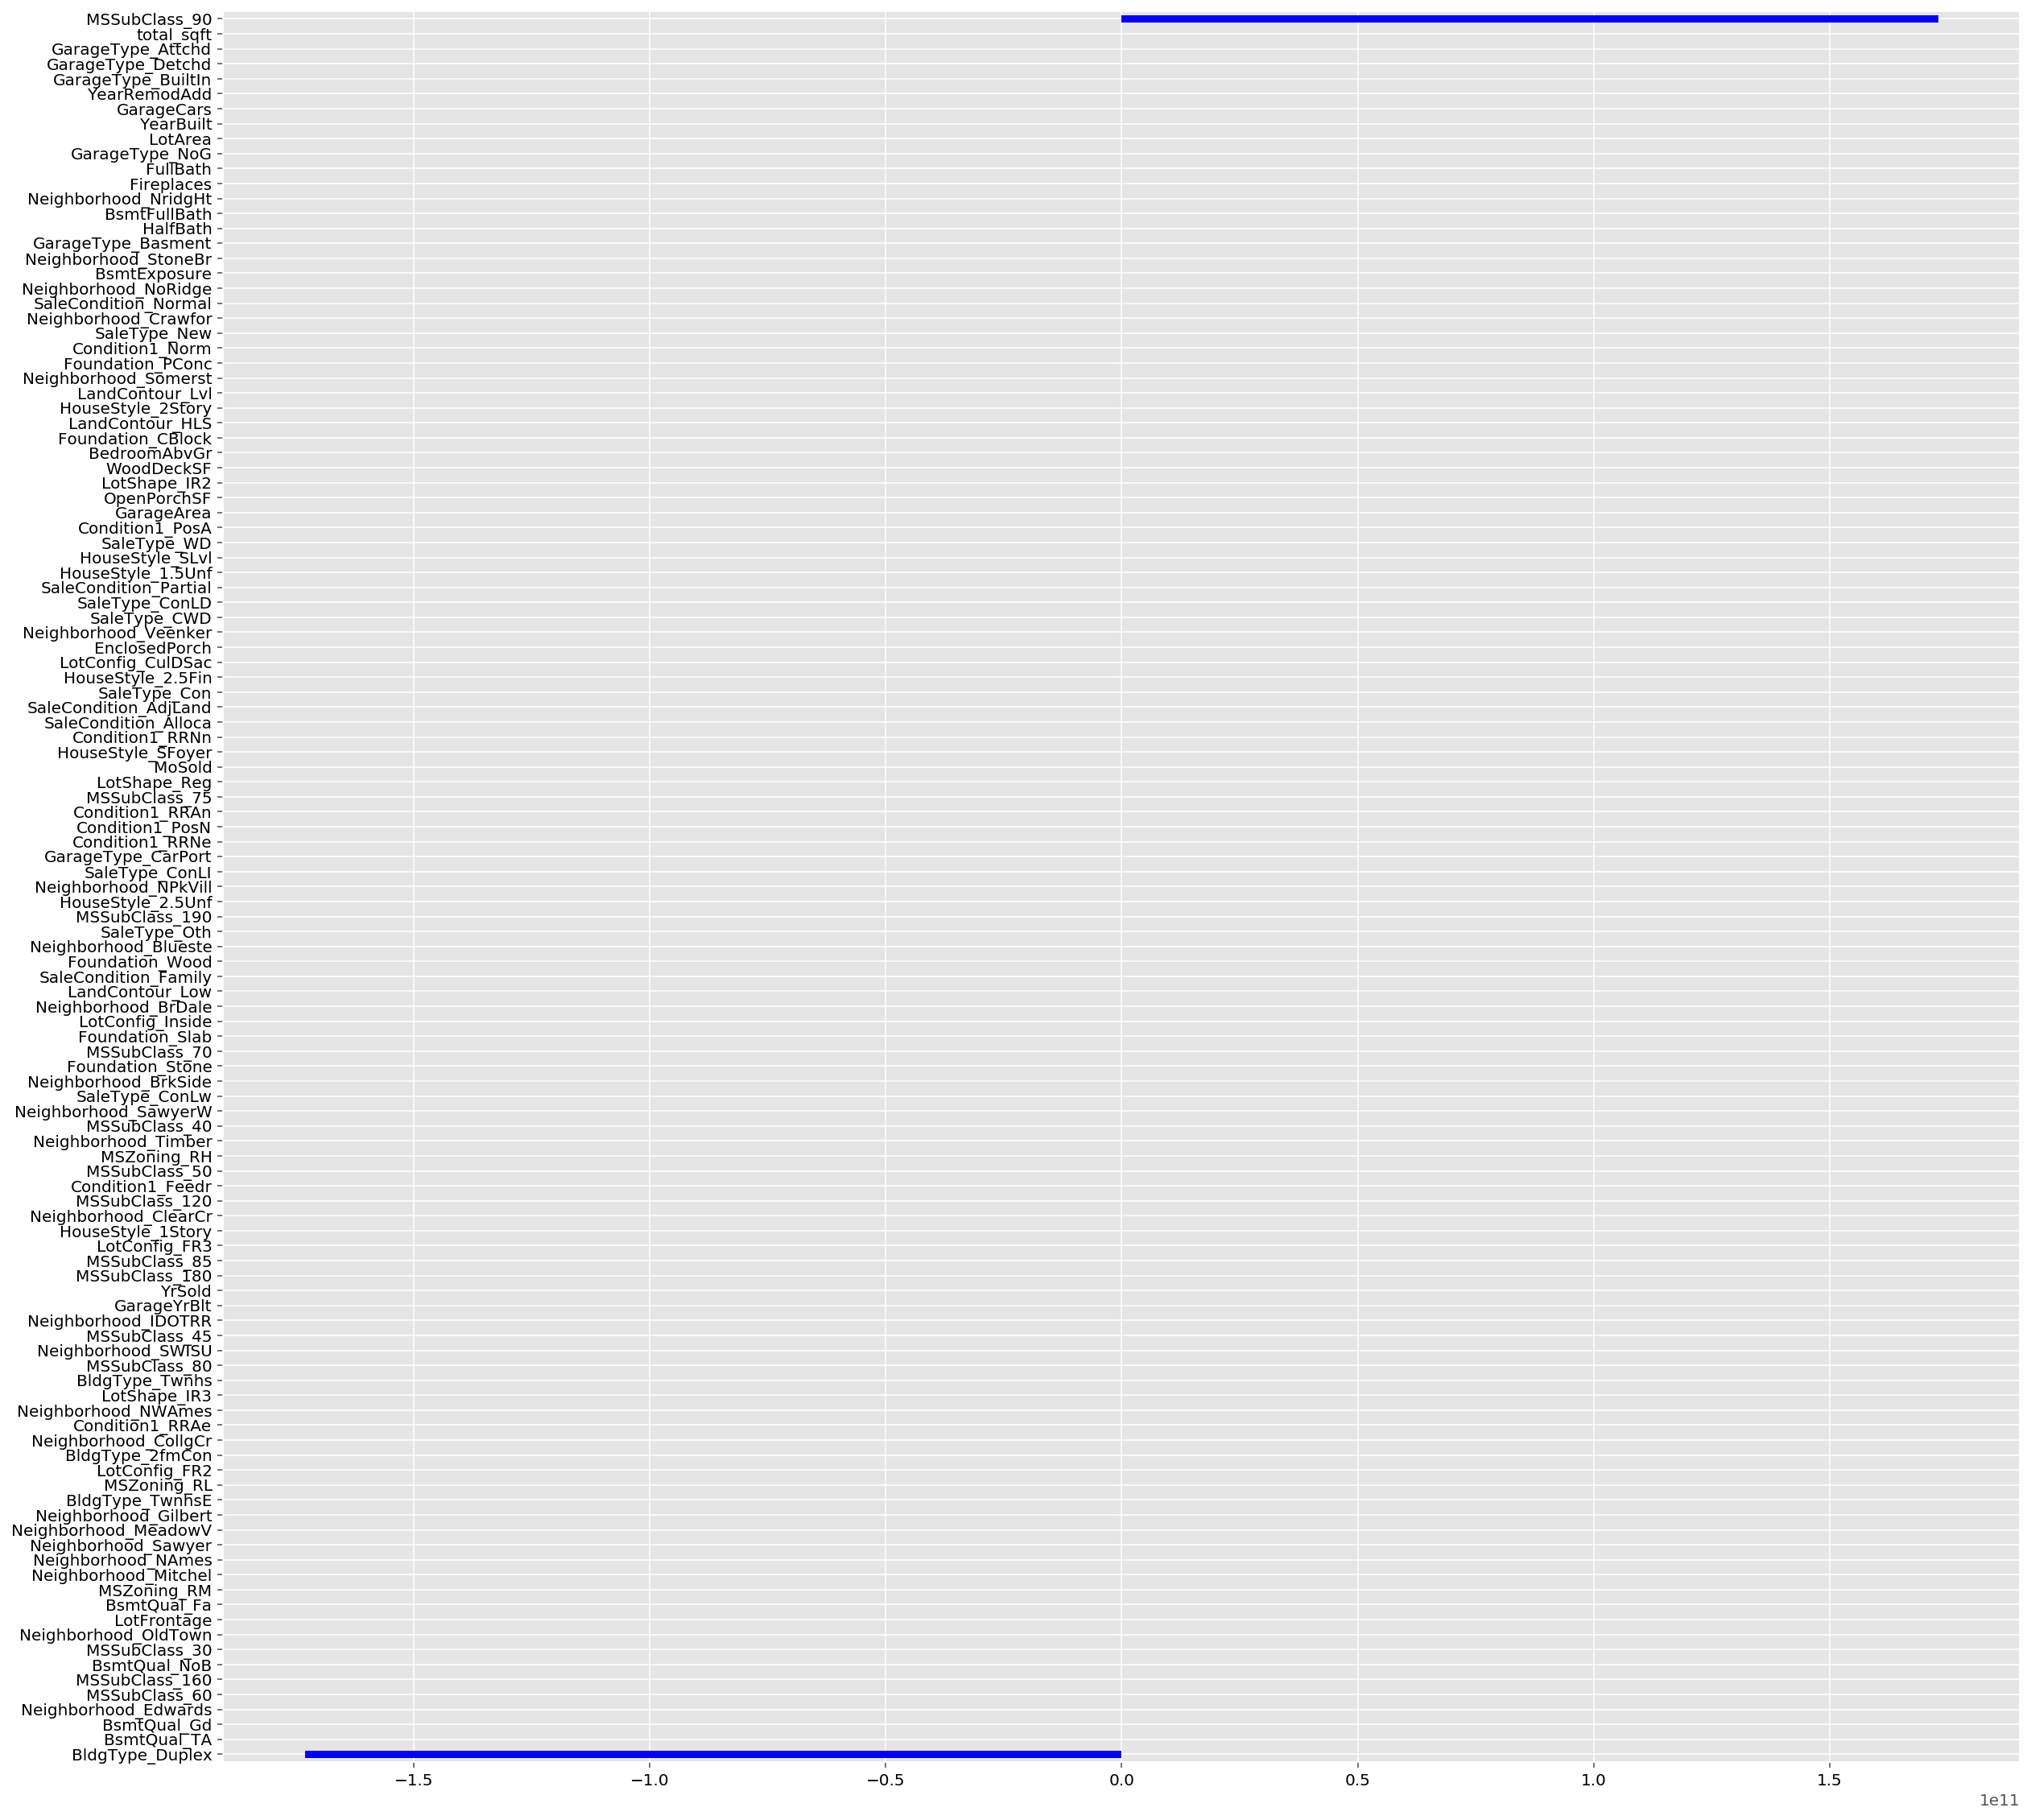

In [50]:
coef_linreg = pd.DataFrame(linreg.coef_, index=X_pre_std.columns,
                       columns=['coef_linreg'])
coef_linreg['coef_linreg_abs'] = coef_linreg.coef_linreg.abs()

plt.figure(figsize = (20,20))
coef_linreg['coef_linreg'].sort_values().plot(kind='barh', color='b')
plt.xticks(color = 'k')
plt.yticks(color = 'k');

### Lasso CV - best score: 0.856770

In [52]:
#Optimising for alpha 
lassoCV = LassoCV(alphas = np.logspace(-4, 4, 100), cv=kf)
lassoCV.fit(X_pre_std, y_pre_2010)

train_score = lassoCV.score(X_pre_std, y_pre_2010)
test_score = lassoCV.score(X_post_std, y_post_2010)

#Cross Validation 
lasso = Lasso(alpha=lassoCV.alpha_)
cv_score = cross_val_score(lasso, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {lassoCV.intercept_}')
print(f'Model coeff: {lassoCV.coef_}')
print(f'Model alpha: {lassoCV.alpha_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Model intercept: 12.032355644349652
Model coeff: [-1.00395568e-02  3.15696338e-02  3.50169610e-02  5.46351411e-02
  2.27406176e-02  2.54876368e-02  2.72497104e-02  1.88393215e-02
  3.37485651e-03  3.41788761e-02  0.00000000e+00  5.04689439e-02
  0.00000000e+00  1.01741312e-02  6.69223663e-03  3.05571633e-04
  2.06699424e-03 -3.70800789e-03  1.23564869e-01 -0.00000000e+00
  0.00000000e+00 -1.27663543e-02  5.78016572e-03 -1.11323251e-02
  0.00000000e+00  7.33551102e-03 -0.00000000e+00  8.78048997e-03
  6.64325892e-03 -7.10318176e-03 -1.40760196e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.87235344e-03 -0.00000000e+00
  0.00000000e+00  2.76623932e-02 -2.12541051e-02 -8.17124692e-03
 -0.00000000e+00 -1.39022729e-02 -1.14931732e-02 -7.84136041e-05
  1.53212094e-04 -0.00000000e+00  2.32954831e-02  3.77826505e-02
 -8.94699595e-03 -0.00000000e+00 -6.25913579e-03  8.98892253e-04
  2.39339748e-02  2.60631225e-02  2.59449669e-03  7.83491476e-03
 -3.84192118e-03  1.12190628e-02  4.10125

#### Visualising the coefficients

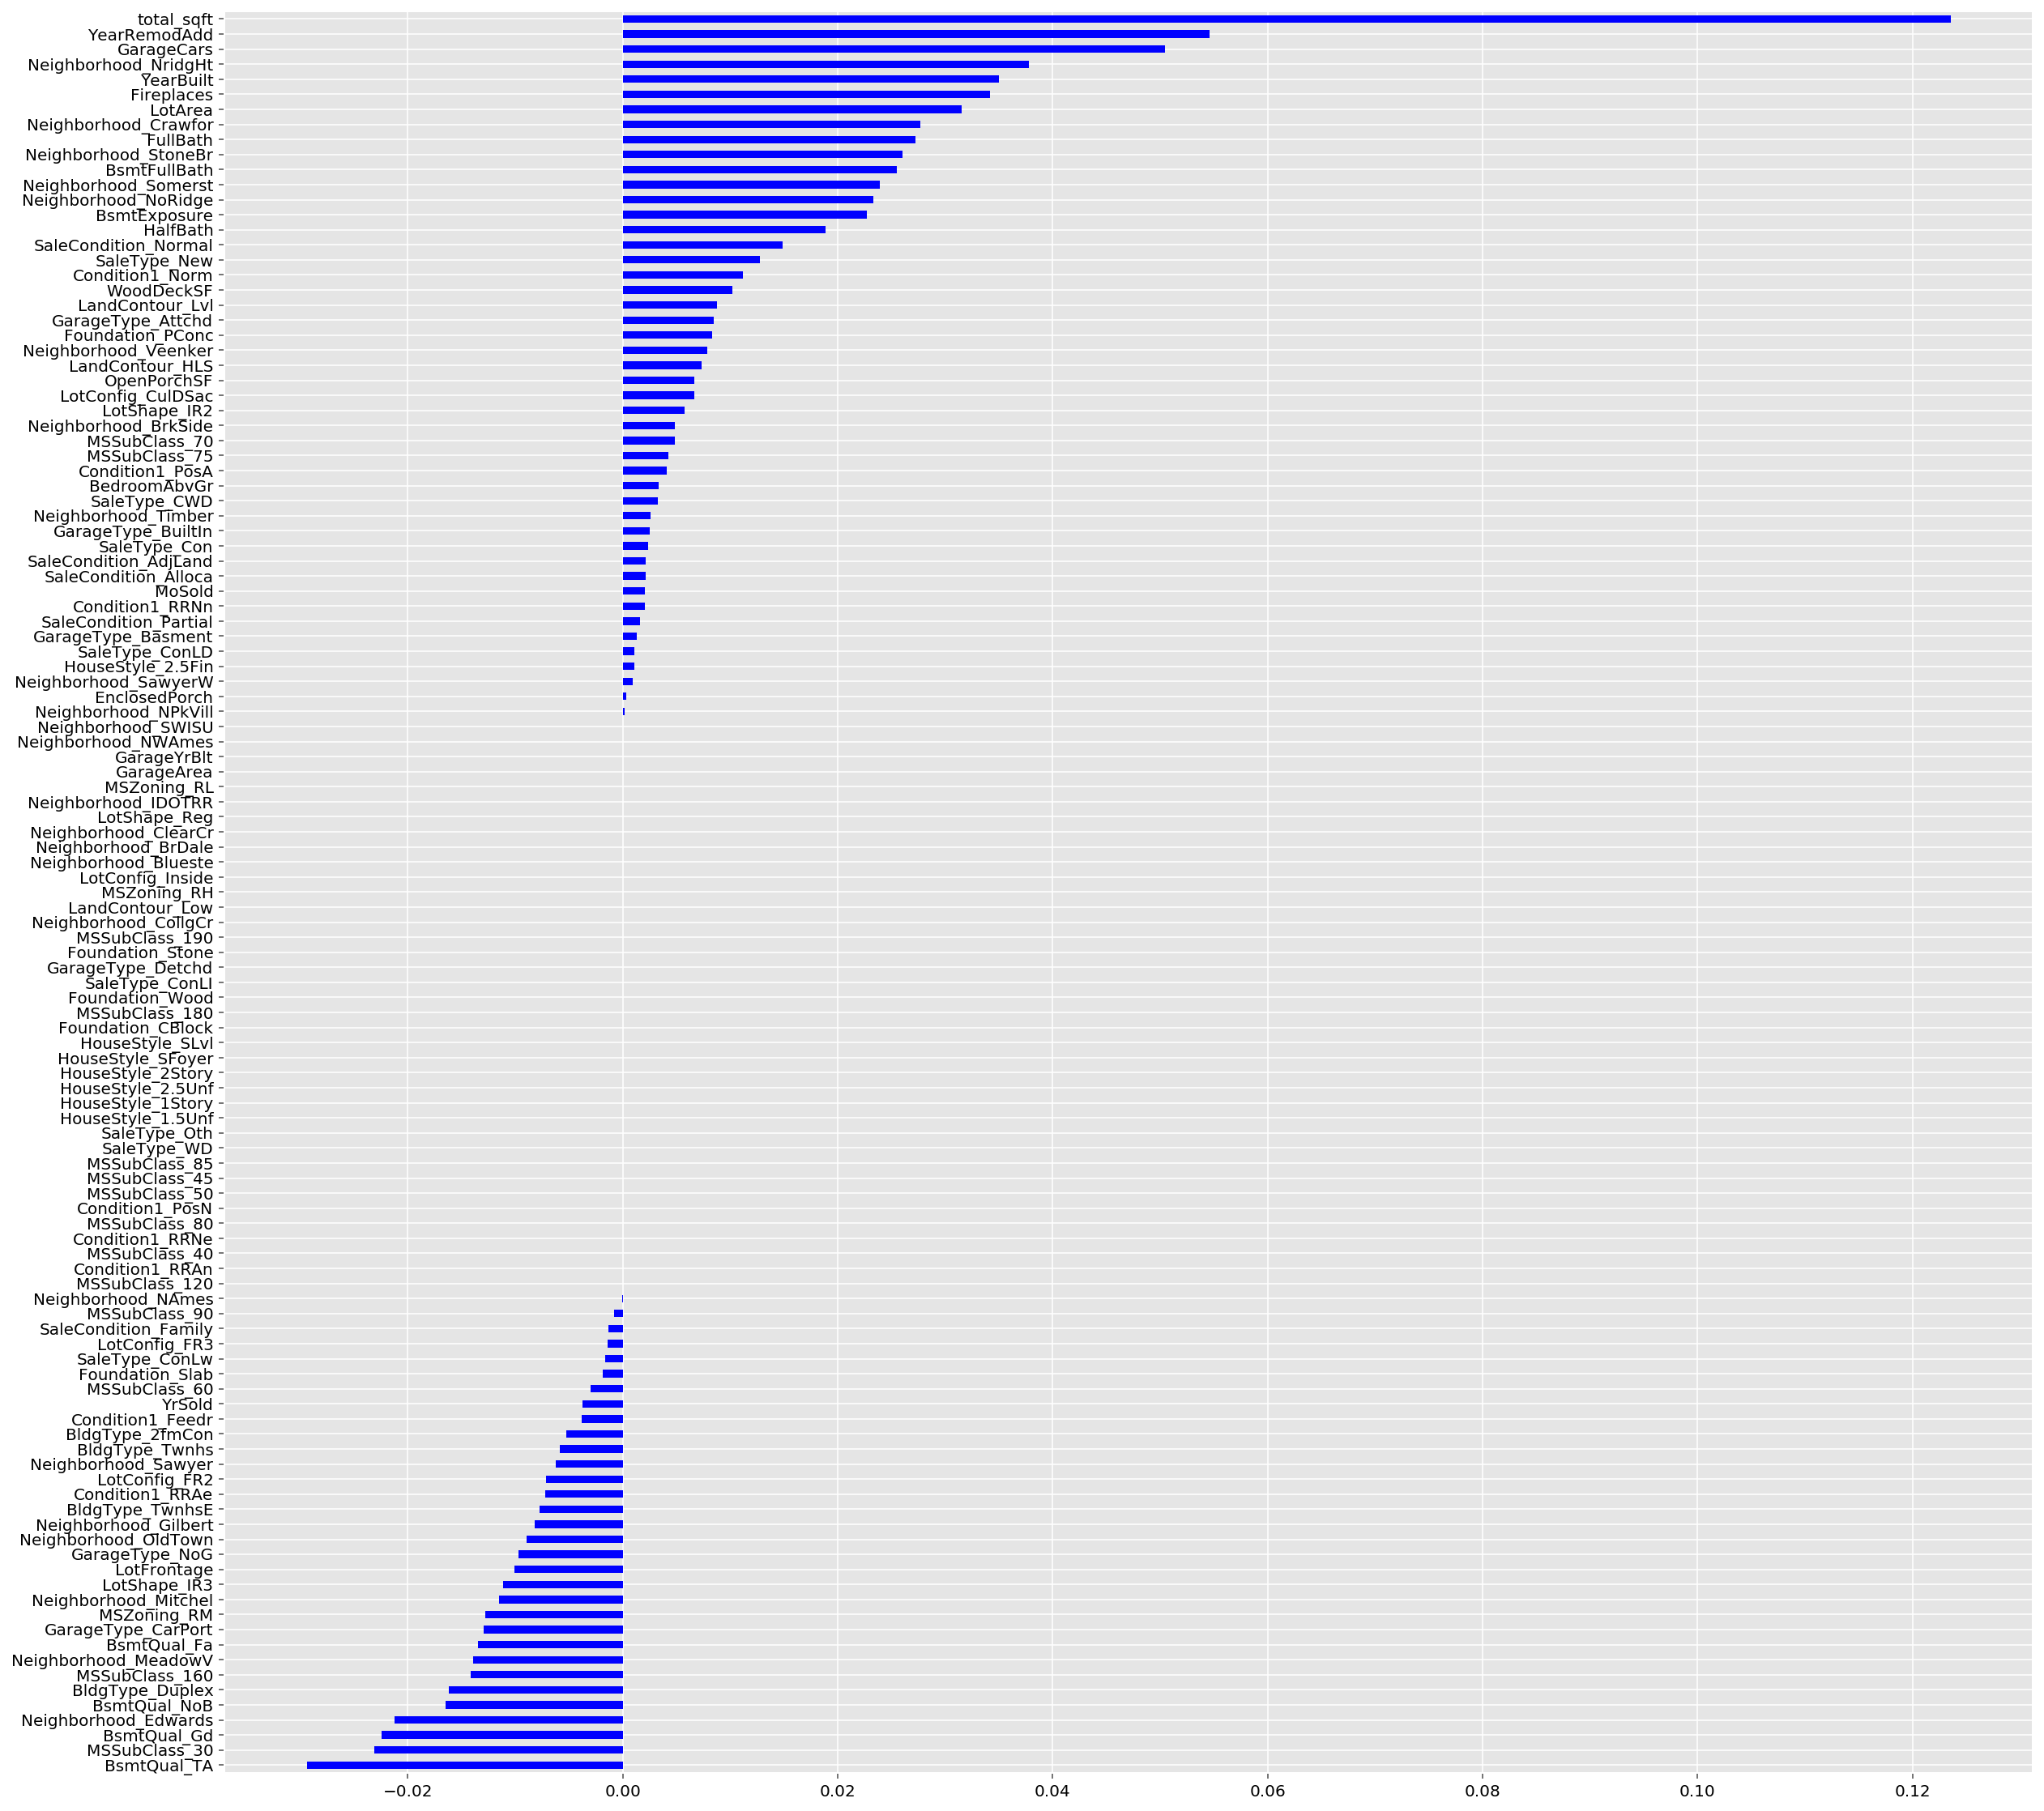

In [53]:
coef_lasso = pd.DataFrame(lassoCV.coef_, index=X_pre_std.columns,
                       columns=['coef_lasso'])
coef_lasso['coef_lasso_abs'] = coef_lasso.coef_lasso.abs()

plt.figure(figsize = (20,20))
coef_lasso['coef_lasso'].sort_values().plot(kind='barh', color='b')
plt.xticks(color = 'k')
plt.yticks(color = 'k');

#### Cutting down the coefficients

I iteratively removed coefficients below a range of threshold to see if this would marginally improve the score. I then plotted this result to get visual understanding and find that I can improve the score marginally by removing coefficients below 0.005306 which resulted in dropping 68 columns and roughly 0.011 mean cv score improvement.

In [54]:
coef_lasso.sort_values(by='coef_lasso_abs')

coef_lasso  coef_lasso_abs
MSSubClass_190          -0.000000        0.000000
LandContour_Low         -0.000000        0.000000
Condition1_RRAn          0.000000        0.000000
Neighborhood_Blueste     0.000000        0.000000
Neighborhood_BrDale      0.000000        0.000000
GarageType_Detchd       -0.000000        0.000000
Neighborhood_ClearCr    -0.000000        0.000000
Neighborhood_CollgCr     0.000000        0.000000
Foundation_Wood         -0.000000        0.000000
Neighborhood_IDOTRR     -0.000000        0.000000
Foundation_Stone        -0.000000        0.000000
Neighborhood_NWAmes     -0.000000        0.000000
Foundation_CBlock       -0.000000        0.000000
HouseStyle_SLvl          0.000000        0.000000
HouseStyle_SFoyer        0.000000        0.000000
Neighborhood_SWISU      -0.000000        0.000000
HouseStyle_2Story       -0.000000        0.000000
HouseStyle_2.5Unf        0.000000        0.000000
HouseStyle_1Story        0.000000        0.000000
HouseStyle_1.5Unf       -0.000000        0.000000
MSSubClass_180          -0.000000        0.000000
Condition1_PosN         -0.000000        0.000000
SaleType_ConLI          -0.000000        0.000000
LotShape_Reg             0.000000        0.000000
LotConfig_Inside         0.000000        0.000000
SaleType_Oth            -0.000000        0.000000
MSSubClass_120          -0.000000        0.000000
MSSubClass_85           -0.000000        0.000000
MSSubClass_80            0.000000        0.000000
MSSubClass_50            0.000000        0.000000
MSSubClass_45           -0.000000        0.000000
MSSubClass_40           -0.000000        0.000000
GarageYrBlt              0.000000        0.000000
GarageArea               0.000000        0.000000
Condition1_RRNe          0.000000        0.000000
MSZoning_RL              0.000000        0.000000
MSZoning_RH             -0.000000        0.000000
SaleType_WD              0.000000        0.000000
Neighborhood_NAmes      -0.000078        0.000078
Neighborhood_NPkVill     0.000153        0.000153
EnclosedPorch            0.000306        0.000306
MSSubClass_90           -0.000810        0.000810
Neighborhood_SawyerW     0.000899        0.000899
HouseStyle_2.5Fin        0.001052        0.001052
SaleType_ConLD           0.001113        0.001113
GarageType_Basment       0.001341        0.001341
SaleCondition_Family    -0.001358        0.001358
LotConfig_FR3           -0.001408        0.001408
SaleCondition_Partial    0.001582        0.001582
SaleType_ConLw          -0.001651        0.001651
Foundation_Slab         -0.001859        0.001859
Condition1_RRNn          0.002067        0.002067
MoSold                   0.002067        0.002067
SaleCondition_Alloca     0.002108        0.002108
SaleCondition_AdjLand    0.002110        0.002110
SaleType_Con             0.002379        0.002379
GarageType_BuiltIn       0.002485        0.002485
Neighborhood_Timber      0.002594        0.002594
MSSubClass_60           -0.002965        0.002965
SaleType_CWD             0.003248        0.003248
BedroomAbvGr             0.003375        0.003375
YrSold                  -0.003708        0.003708
Condition1_Feedr        -0.003842        0.003842
Condition1_PosA          0.004101        0.004101
MSSubClass_75            0.004248        0.004248
MSSubClass_70            0.004872        0.004872
Neighborhood_BrkSide     0.004872        0.004872
BldgType_2fmCon         -0.005269        0.005269
LotShape_IR2             0.005780        0.005780
BldgType_Twnhs          -0.005878        0.005878
Neighborhood_Sawyer     -0.006259        0.006259
LotConfig_CulDSac        0.006643        0.006643
OpenPorchSF              0.006692        0.006692
LotConfig_FR2           -0.007103        0.007103
Condition1_RRAe         -0.007177        0.007177
LandContour_HLS          0.007336        0.007336
BldgType_TwnhsE         -0.007722        0.007722
Neighborhood_Veenker     0.007835        0.007835
Neighborhood_Gilbert    -0.008171        0.008171
Foundation_PConc       

In [55]:
#Iteratively test all the coefficient thresholds to find the optimal threshold 
coef_thres = np.linspace(coef_lasso.coef_lasso_abs.min(),
                         0.02, num=50)
mean_cv_scores = []
cols_dropped = []
for thres in coef_thres:
    #Only extract features with coefficient values above the threshold 
    good_coef = coef_lasso[coef_lasso.coef_lasso_abs >= thres].index
    cols_dropped.append(len(X_pre_std.columns) - len(good_coef))

    X_subset = X_pre_std.loc[:, good_coef]
    
    #Refit model with these subset of features
    lassoCV = LassoCV(n_alphas=100, cv=kf)
    lassoCV.fit(X_subset, y_pre_2010)
    lasso = Lasso(alpha=lassoCV.alpha_)
    mean_cv_scores.append(cross_val_score(
        lasso, X_subset, y_pre_2010, cv=kf).mean())

In [56]:
#Convert to dataframe
improve_lasso = pd.DataFrame({'coef_thres_lasso': coef_thres, 'mean_cv_scores_lasso': mean_cv_scores, 
                              'cols_dropped_num_lasso': cols_dropped})

In [57]:
#Reorder the reviews to get the best score and the optimal columns to drop
improve_lasso = improve_lasso.sort_values(by=['mean_cv_scores_lasso', 'cols_dropped_num_lasso'], 
                                          ascending =[False, False])
improve_lasso[:10]

coef_thres_lasso  mean_cv_scores_lasso  cols_dropped_num_lasso
13          0.005306              0.856770                      68
14          0.005714              0.856770                      68
12          0.004898              0.856658                      67
10          0.004082              0.856374                      63
7           0.002857              0.856076                      58
11          0.004490              0.856033                      65
6           0.002449              0.855843                      56
9           0.003673              0.855789                      61
15          0.006122              0.855650                      70
8           0.003265              0.855565                      60

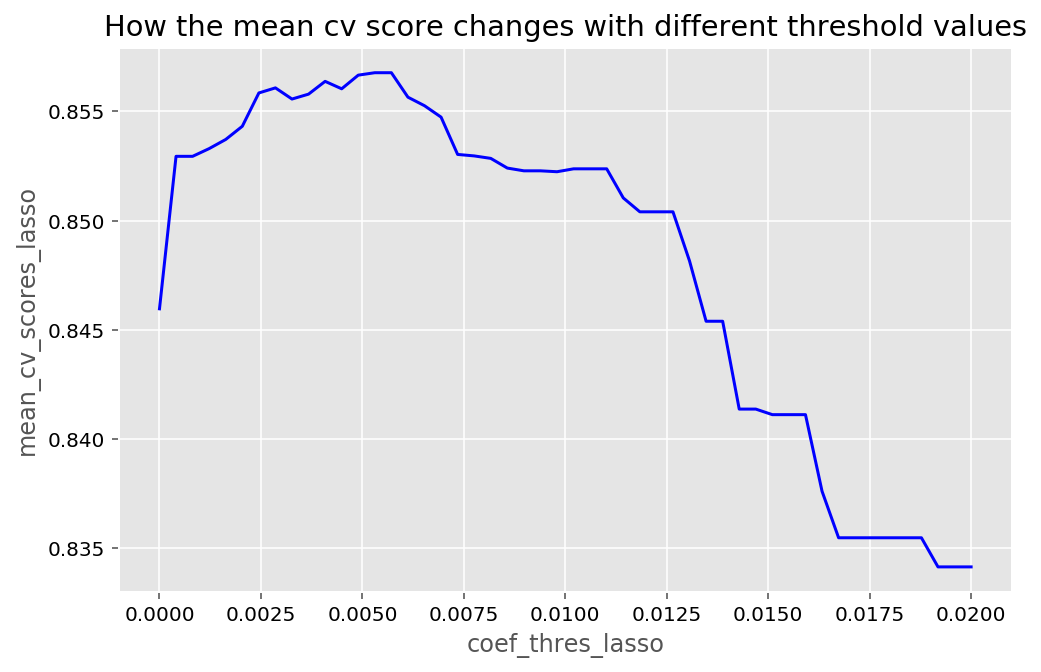

In [58]:
#A visual represenation of the dataframe
plt.figure(figsize = (8,5))
sns.lineplot(improve_lasso.coef_thres_lasso, improve_lasso.mean_cv_scores_lasso, color='b')
plt.title('How the mean cv score changes with different threshold values')
plt.xticks(color = 'k')
plt.yticks(color = 'k')
plt.show()

#### Optimal Lasso

After obtaining the optimal model parameters with LassoCV and searching for the best coefficient cut-off threshold, I refit the model and visualise the results.This model is a log-linear regression model as we took the log of y before modelling, giving us the equation:

$$ln(Y) = \beta_0 + \beta_1 X_1 +...+ \beta_n X_n$$

So the way to interpret the coefficients is that for each standard deviation rise in $X_i$, the value of $Y$ increase by $e^{\beta_i}$. For example, in the Ridge model (shown in the next section), total_sqt had a coefficient of ~0.09. $e^{0.09} = ~1.094$. Meaning 1 std rise in total_sqt causes the sale price to multiply by ~1.094 or increase by ~9.41%. 

I have demonstrated this for all the coefficients by visualing them as their percentage impact on the price for both the optimal Lasso and Ridge models.

In [59]:
opt_thres_lasso = improve_lasso['coef_thres_lasso'].iloc[0]
print(opt_thres_lasso)
columns_keep_lasso = coef_lasso[coef_lasso.coef_lasso_abs > opt_thres_lasso].index
X_opt = X_pre_std.loc[:, columns_keep_lasso]

0.005306122448979592


Optimal intercept(Lasso): 12.032355644349652
Optimal alpha (Lasso): 0.00030126845359658595
Optimal CV Score (Lasso): 0.8567698123960625
Optimal Train Score (Lasso): 0.8767206311105022
Optimal Test Score (Lasso): 0.8966498510875767


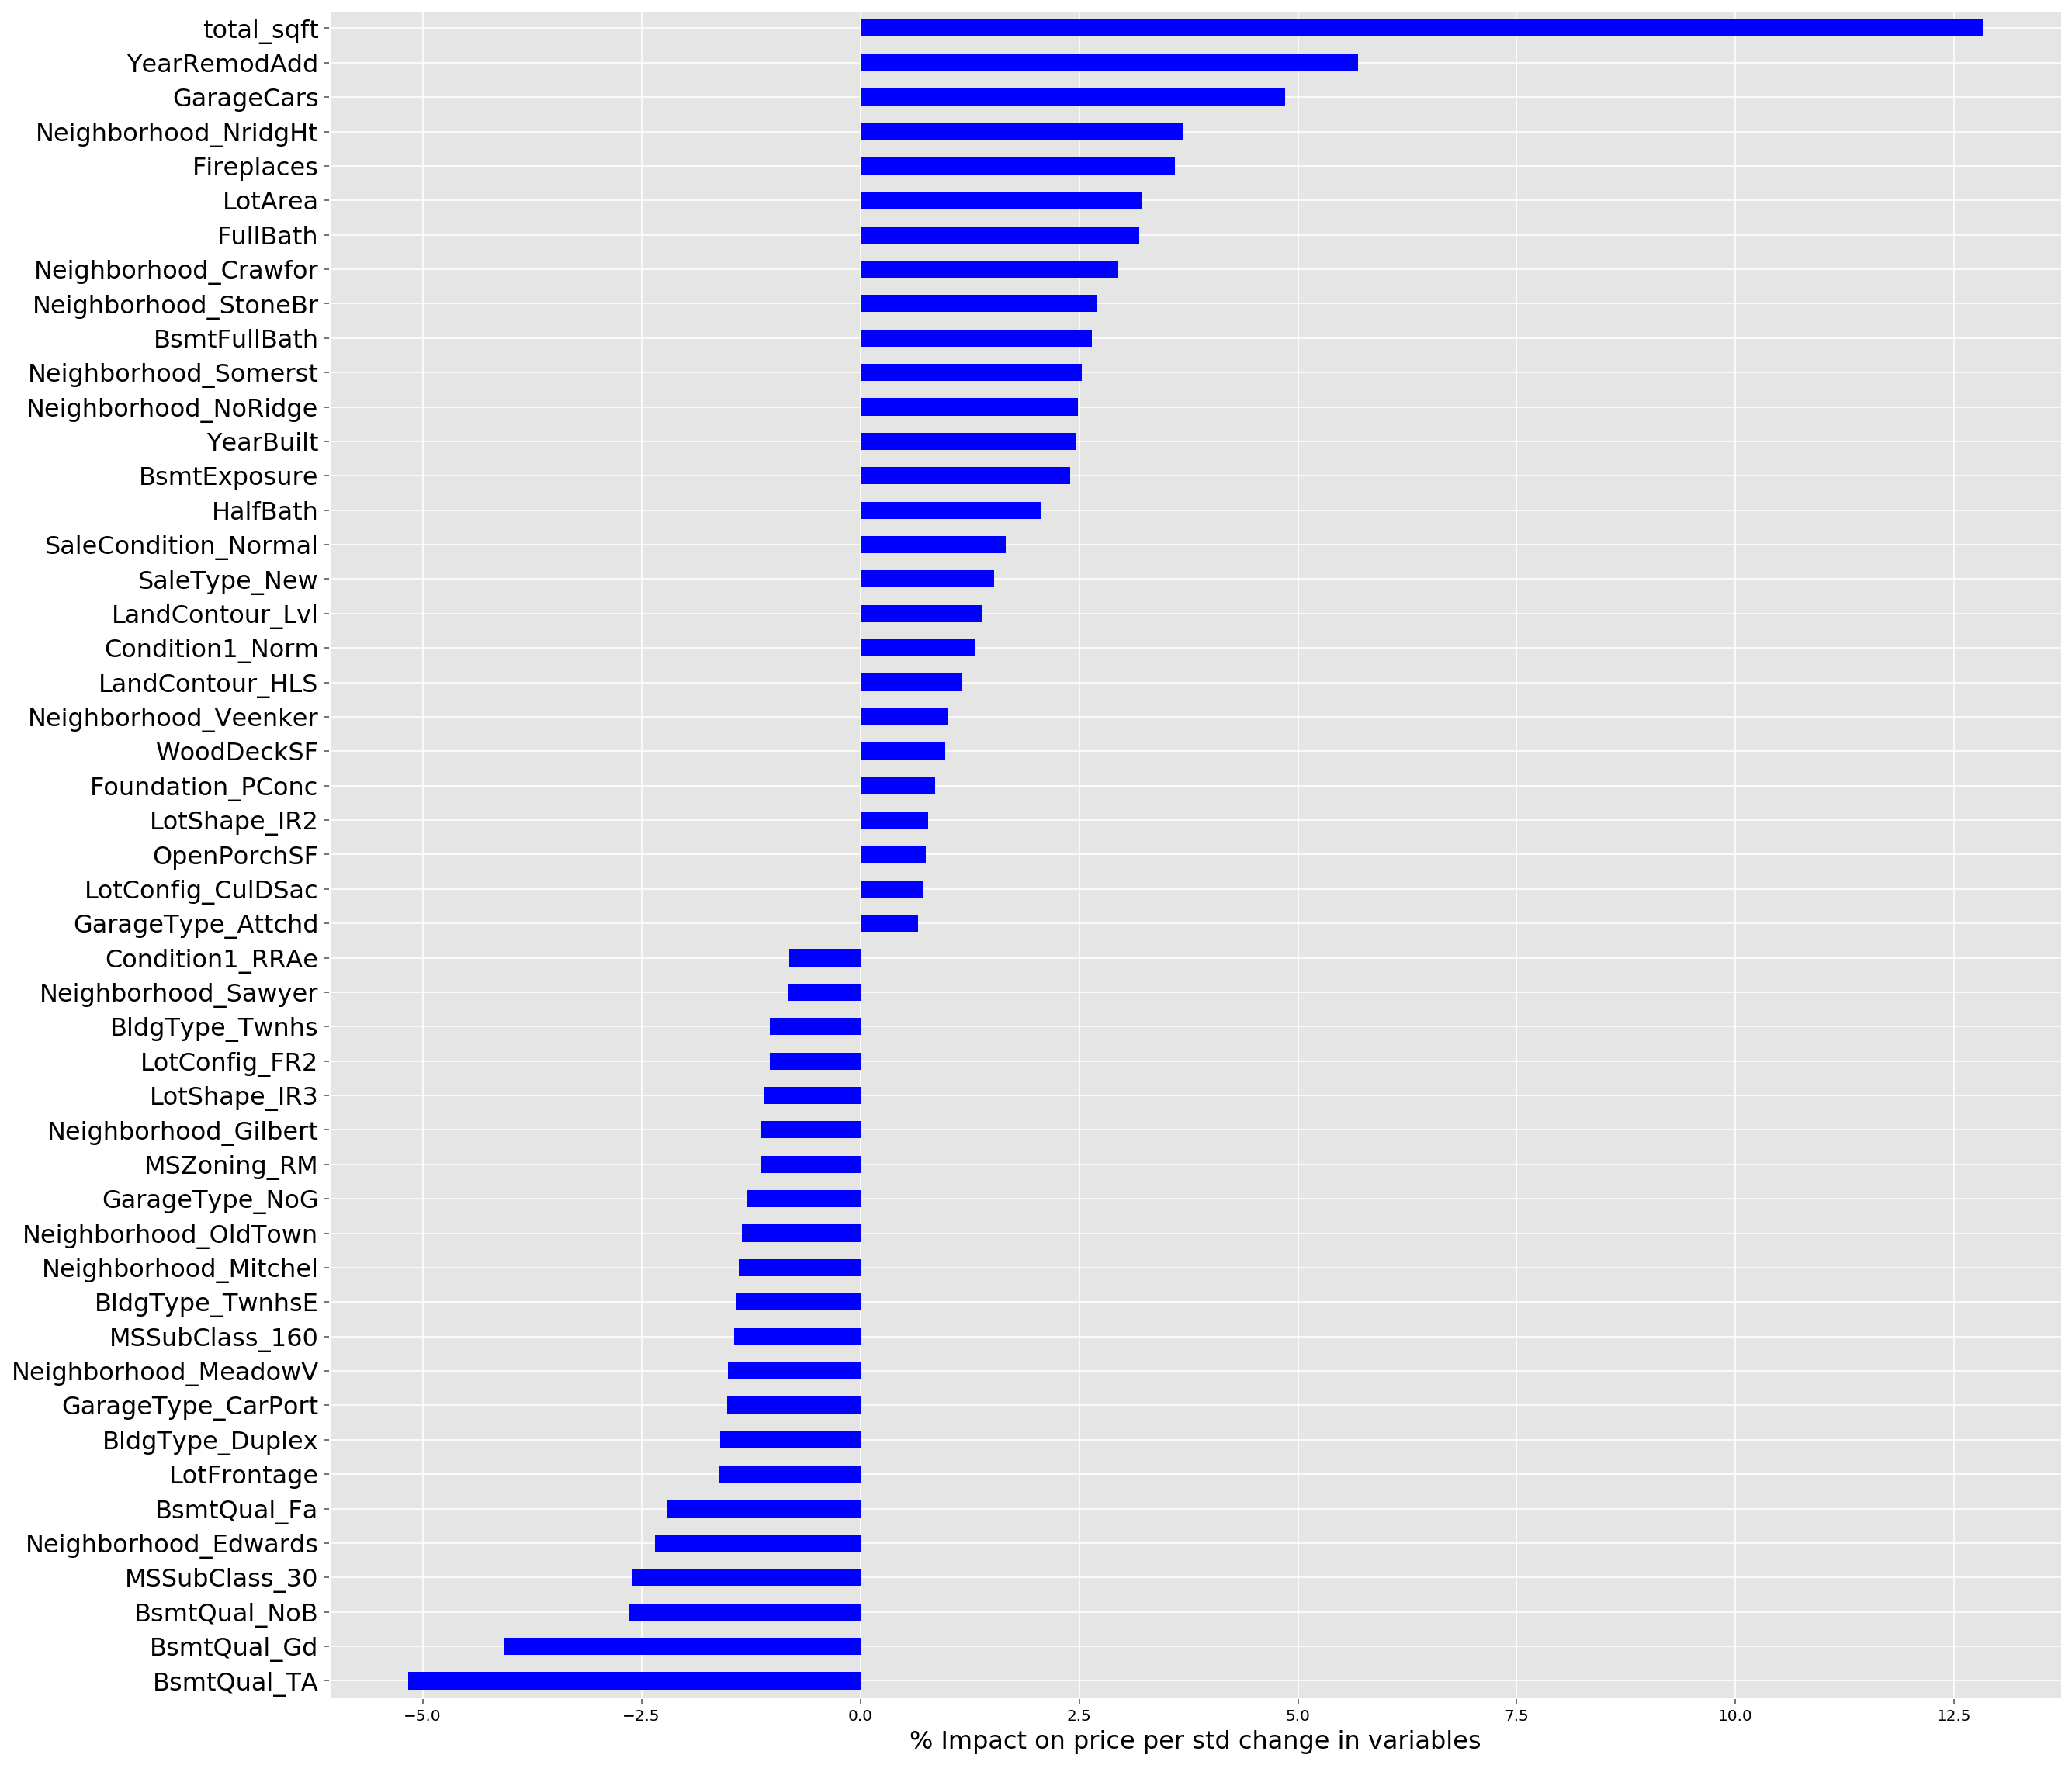

In [61]:
#Sense checking the optimal Lasso model
lassoCV_opt = LassoCV(n_alphas = 100, cv=kf)
lassoCV_opt.fit(X_opt, y_pre_2010)

#Cross Validation 
lasso_opt = Lasso(alpha=lassoCV_opt.alpha_)


print(f'Optimal intercept(Lasso): {lassoCV_opt.intercept_}')
print(f'Optimal alpha (Lasso): {lassoCV_opt.alpha_}')
print(f'Optimal CV Score (Lasso): {cross_val_score(lasso_opt, X_opt, y_pre_2010, cv = kf).mean()}')
print(f'Optimal Train Score (Lasso): {lassoCV_opt.score(X_opt, y_pre_2010)}')
print(f'Optimal Test Score (Lasso): {lassoCV_opt.score(X_post_std.loc[:, columns_keep_lasso], y_post_2010)}')


#Visualising the optimal coefficients
coef_lasso = pd.DataFrame(lassoCV_opt.coef_, index=X_opt.columns,
                       columns=['coef_lasso'])
coef_lasso['coef_lasso_abs'] = coef_lasso.coef_lasso.abs()
coef_lasso['coef_lasso_price_impact'] = (np.exp(coef_lasso.coef_lasso)-1)*100

plt.figure(figsize = (20,20))
coef_lasso['coef_lasso_price_impact'].sort_values().plot(kind='barh', color='b')
plt.xlabel('% Impact on price per std change in variables', fontsize = 16, color='k')
plt.xticks(color = 'k')
plt.yticks(fontsize=16, color = 'k');

### Ridge CV - Ridge is a Smidge Better! - best score: 0.857827

I have repeated all the steps perfomed for Lasso above to test the model with Ridge. This model turns out to be the best by a smidge in terms of mean cv R2 scores. 

In [62]:
#Optimising for alpha 
ridgeCV = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=kf)
ridgeCV.fit(X_pre_std, y_pre_2010)

train_score = ridgeCV.score(X_pre_std, y_pre_2010)
test_score = ridgeCV.score(X_post_std, y_post_2010)

#Cross Validation 
ridge = Ridge(alpha=ridgeCV.alpha_)
cv_score = cross_val_score(ridge, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {ridgeCV.intercept_}')
print(f'Model coeff: {ridgeCV.coef_}')
print(f'Model alpha: {ridgeCV.alpha_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Model intercept: 12.032355644349652
Model coeff: [-0.00587365  0.0286854   0.02689555  0.04765676  0.02492071  0.02637613
  0.0347302   0.02277532  0.01175453  0.03678779  0.00502665  0.03609687
  0.01954853  0.01274671  0.01174116  0.00366814  0.00342353 -0.00494993
  0.08921577 -0.00087665  0.00143067 -0.01196817  0.00809888 -0.00956363
  0.00060258  0.00793525 -0.00180997  0.0090299   0.00904517 -0.0087716
 -0.00314217  0.00079524  0.00015422 -0.00061425  0.00228455 -0.00056201
 -0.00568109  0.02408075 -0.02416487 -0.01336715 -0.00385506 -0.0156855
 -0.01445297 -0.00835844  0.00073514 -0.00292388  0.02481904  0.03478009
 -0.01428872 -0.00456659 -0.0113299   0.00086384  0.01880964  0.0250851
  0.00264751  0.00808612 -0.00540441  0.01192396  0.00574277  0.00153006
 -0.0081392  -0.00014194  0.00082324  0.00486967 -0.00479075 -0.00792532
 -0.0063041  -0.0084497   0.00160856 -0.00034155  0.00473785  0.00201945
 -0.00191852  0.00033386 -0.0005763  -0.00016877  0.01400293 -0.00618308
 -0.0

#### Visualising coefs

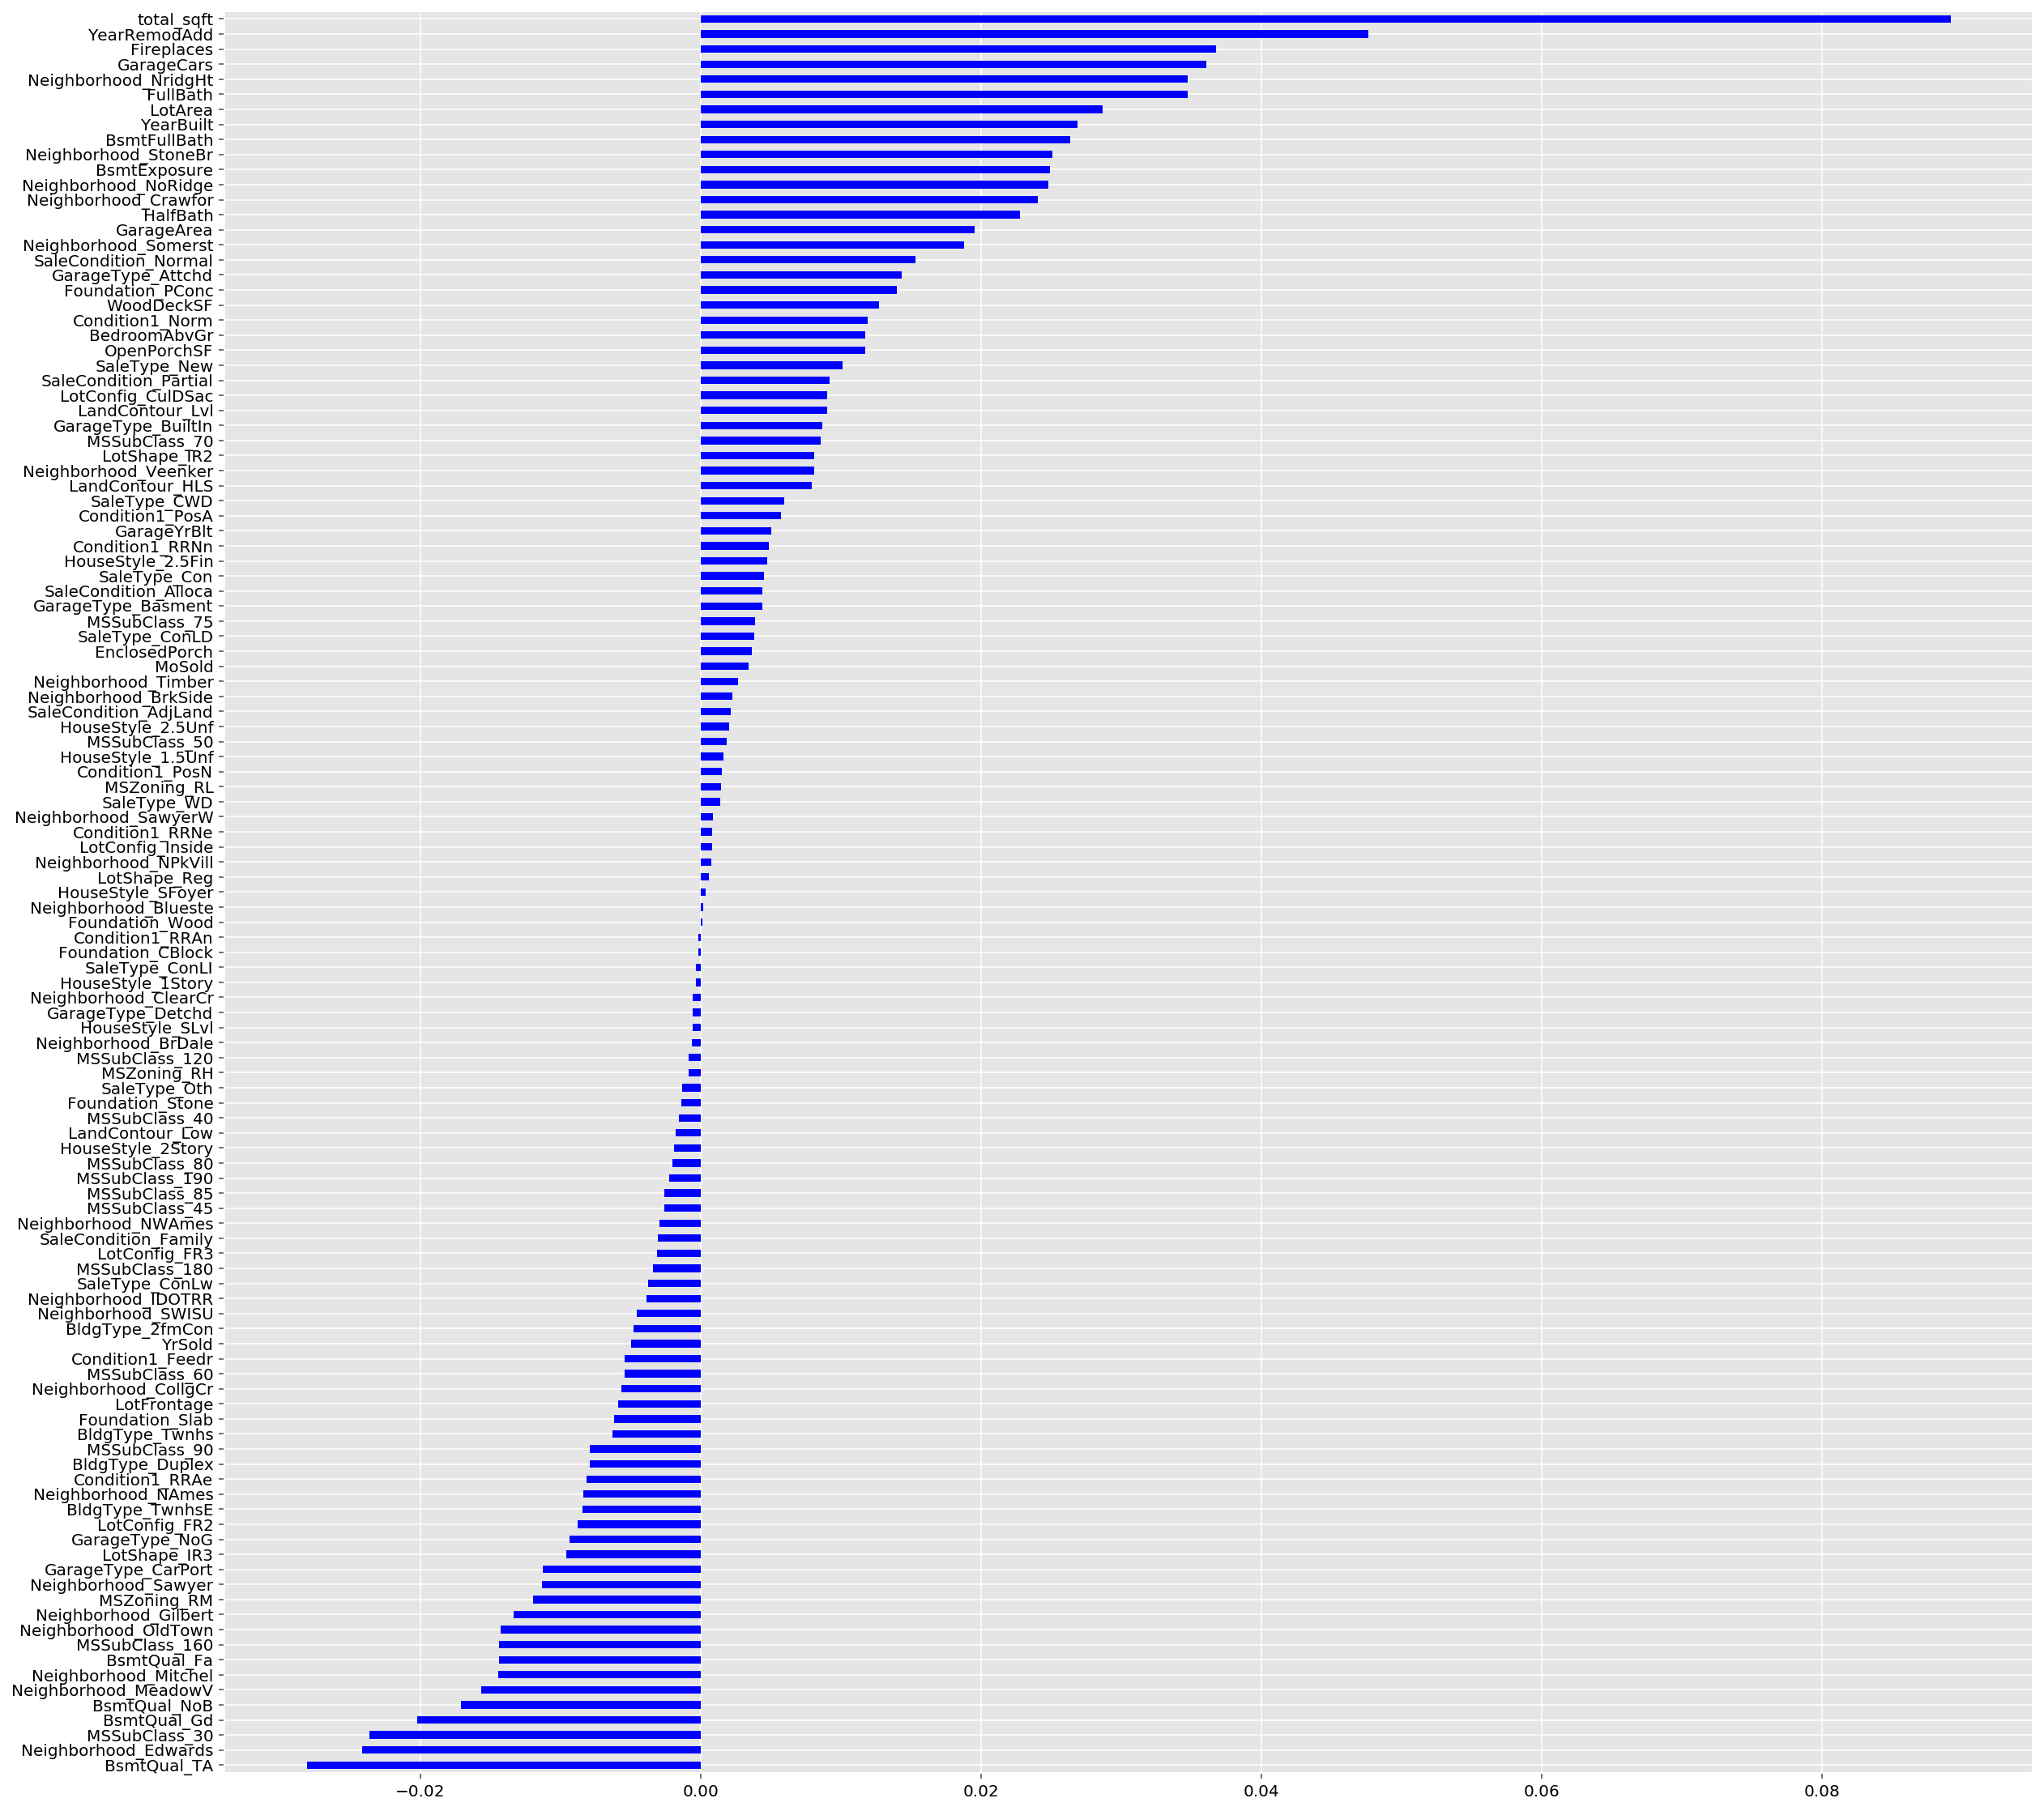

In [63]:
coef_ridge= pd.DataFrame(ridgeCV.coef_, index=X_pre_std.columns,
                       columns=['coef_ridge'])
coef_ridge['coef_ridge_abs'] = coef_ridge.coef_ridge.abs()

plt.figure(figsize = (20,20))
coef_ridge['coef_ridge'].sort_values().plot(kind='barh', color='b')
plt.xticks(color = 'k')
plt.yticks(color = 'k');

#### Cutting down the coefficients

I iteratively removed coefficients below a range of threshold to see if this would marginally improve the score. I then plotted this result to get visual understanding and find that I can improve the score marginally by removing coefficients below 0.006221 which resulted in dropping 62 columns and roughly 0.009 mean cv score improvement.

In [64]:
coef_ridge.sort_values(by='coef_ridge_abs')

coef_ridge  coef_ridge_abs
Condition1_RRAn         -0.000142        0.000142
Foundation_Wood          0.000144        0.000144
Neighborhood_Blueste     0.000154        0.000154
Foundation_CBlock       -0.000169        0.000169
SaleType_ConLI          -0.000332        0.000332
HouseStyle_SFoyer        0.000334        0.000334
HouseStyle_1Story       -0.000342        0.000342
Neighborhood_ClearCr    -0.000562        0.000562
GarageType_Detchd       -0.000568        0.000568
HouseStyle_SLvl         -0.000576        0.000576
LotShape_Reg             0.000603        0.000603
Neighborhood_BrDale     -0.000614        0.000614
Neighborhood_NPkVill     0.000735        0.000735
LotConfig_Inside         0.000795        0.000795
Condition1_RRNe          0.000823        0.000823
Neighborhood_SawyerW     0.000864        0.000864
MSSubClass_120          -0.000873        0.000873
MSZoning_RH             -0.000877        0.000877
SaleType_Oth            -0.001326        0.001326
Foundation_Stone        -0.001381        0.001381
SaleType_WD              0.001405        0.001405
MSZoning_RL              0.001431        0.001431
Condition1_PosN          0.001530        0.001530
MSSubClass_40           -0.001538        0.001538
HouseStyle_1.5Unf        0.001609        0.001609
LandContour_Low         -0.001810        0.001810
MSSubClass_50            0.001830        0.001830
HouseStyle_2Story       -0.001919        0.001919
HouseStyle_2.5Unf        0.002019        0.002019
MSSubClass_80           -0.002028        0.002028
SaleCondition_AdjLand    0.002121        0.002121
MSSubClass_190          -0.002220        0.002220
Neighborhood_BrkSide     0.002285        0.002285
MSSubClass_85           -0.002599        0.002599
MSSubClass_45           -0.002617        0.002617
Neighborhood_Timber      0.002648        0.002648
Neighborhood_NWAmes     -0.002924        0.002924
SaleCondition_Family    -0.003086        0.003086
LotConfig_FR3           -0.003142        0.003142
MSSubClass_180          -0.003390        0.003390
MoSold                   0.003424        0.003424
EnclosedPorch            0.003668        0.003668
SaleType_ConLw          -0.003742        0.003742
SaleType_ConLD           0.003798        0.003798
Neighborhood_IDOTRR     -0.003855        0.003855
MSSubClass_75            0.003903        0.003903
GarageType_Basment       0.004396        0.004396
SaleCondition_Alloca     0.004426        0.004426
SaleType_Con             0.004529        0.004529
Neighborhood_SWISU      -0.004567        0.004567
HouseStyle_2.5Fin        0.004738        0.004738
BldgType_2fmCon         -0.004791        0.004791
Condition1_RRNn          0.004870        0.004870
YrSold                  -0.004950        0.004950
GarageYrBlt              0.005027        0.005027
Condition1_Feedr        -0.005404        0.005404
MSSubClass_60           -0.005421        0.005421
Neighborhood_CollgCr    -0.005681        0.005681
Condition1_PosA          0.005743        0.005743
LotFrontage             -0.005874        0.005874
SaleType_CWD             0.005938        0.005938
Foundation_Slab         -0.006183        0.006183
BldgType_Twnhs          -0.006304        0.006304
MSSubClass_90           -0.007925        0.007925
BldgType_Duplex         -0.007925        0.007925
LandContour_HLS          0.007935        0.007935
Neighborhood_Veenker     0.008086        0.008086
LotShape_IR2             0.008099        0.008099
Condition1_RRAe         -0.008139        0.008139
Neighborhood_NAmes      -0.008358        0.008358
BldgType_TwnhsE         -0.008450        0.008450
MSSubClass_70            0.008553        0.008553
GarageType_BuiltIn       0.008654        0.008654
LotConfig_FR2           -0.008772        0.008772
LandContour_Lvl          0.009030        0.009030
LotConfig_CulDSac        0.009045        0.009045
SaleCondition_Partial    0.009214        0.009214
GarageType_NoG          -0.009382        0.009382
LotShape_IR3            -0.009564        0.009564
SaleType_New           

In [65]:
#Iteratively test all the coefficient thresholds to find the optimal threshold 
coef_thres = np.linspace(coef_ridge.coef_ridge_abs.min(),
                         0.02, num=50)
mean_cv_scores = []
cols_dropped = []

for thres in coef_thres:
    #Only extract features with coefficient values above the threshold 
    good_coef = coef_ridge[coef_ridge.coef_ridge_abs >= thres].index
    cols_dropped.append(len(X_pre_std.columns) - len(good_coef))

    X_subset = X_pre_std.loc[:, good_coef]
    
    #Refit model with these subset of features
    ridgeCV = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=kf)
    ridgeCV.fit(X_subset, y_pre_2010)
    ridge = Ridge(alpha=ridgeCV.alpha_)
    mean_cv_scores.append(cross_val_score(
        ridge, X_subset, y_pre_2010, cv=kf).mean())

In [66]:
#Convert to dataframe
improve_ridge = pd.DataFrame({'coef_thres_ridge': coef_thres, 'mean_cv_scores_ridge': mean_cv_scores, 
                              'cols_dropped_num_ridge': cols_dropped})

In [67]:
#Reorder the reviews to get the best score and the optimal columns to drop
improve_ridge = improve_ridge.sort_values(by=['mean_cv_scores_ridge', 'cols_dropped_num_ridge'], 
                                          ascending =[False, False])
improve_ridge[:10]

coef_thres_ridge  mean_cv_scores_ridge  cols_dropped_num_ridge
15          0.006221              0.857827                      62
16          0.006626              0.857716                      63
17          0.007031              0.857716                      63
18          0.007437              0.857716                      63
19          0.007842              0.857716                      63
13          0.005410              0.857182                      56
14          0.005816              0.856405                      59
12          0.005005              0.856403                      54
11          0.004600              0.855990                      50
10          0.004195              0.855270                      46

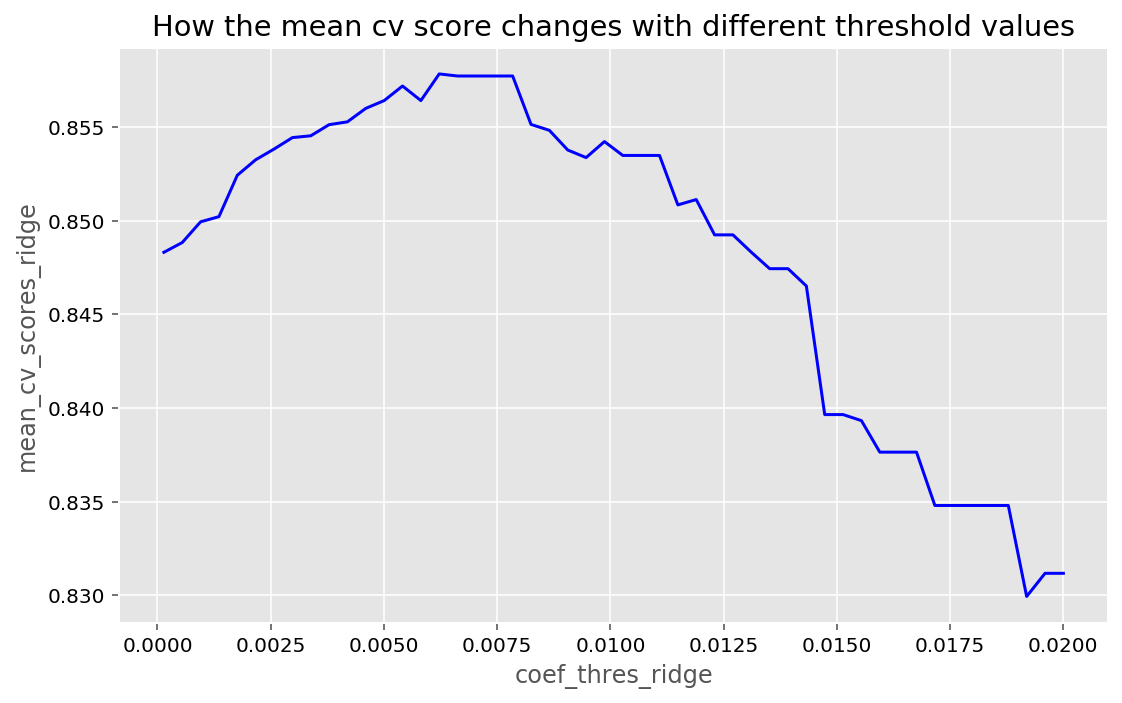

In [71]:
#A visual represenation of the dataframe
plt.figure(figsize = (8,5))
sns.lineplot(improve_ridge.coef_thres_ridge, improve_ridge.mean_cv_scores_ridge, color='b')
plt.title('How the mean cv score changes with different threshold values')
plt.xticks(color = 'k')
plt.yticks(color = 'k');

#### Optimal Ridge

After obtaining the optimal model parameters with RidgeCV and searching for the best coefficient cut-off threshold, I refit the model and visualise the results.This model is a log-linear regression model as we took the log of y before modelling, giving us the equation:

$$ln(Y) = \beta_0 + \beta_1 X_1 +...+ \beta_n X_n$$

So the way to interpret the coefficients is that for each standard deviation rise in $X_i$, the value of $Y$ increase by $e^{\beta_i}$. For example, in the Ridge model, total_sqt had a coefficient of ~0.09. $e^{0.09} = ~1.094$. Meaning 1 std rise in total_sqt causes the sale price to multiply by ~1.094 or increase by ~9.41%. 

I have demonstrated this for all the coefficients by visualing them as their percentage impact on the price for both the optimal Lasso and Ridge models.

In [72]:
opt_thres_ridge = improve_ridge['coef_thres_ridge'].iloc[0]
columns_keep_ridge = coef_ridge[coef_ridge.coef_ridge_abs > opt_thres_ridge].index
X_opt = X_pre_std.loc[:, columns_keep_ridge]
print(opt_thres_ridge)

0.006220939643180351


Optimal intercept(Ridge): 12.032355644349652
Optimal alpha (Ridge): 166.81005372000558
Optimal CV Score (Ridge): 0.8578271322009046
Optimal Train Score (Ridge): 0.8731101010826363
Optimal Test Score (Ridge): 0.8946954033851798


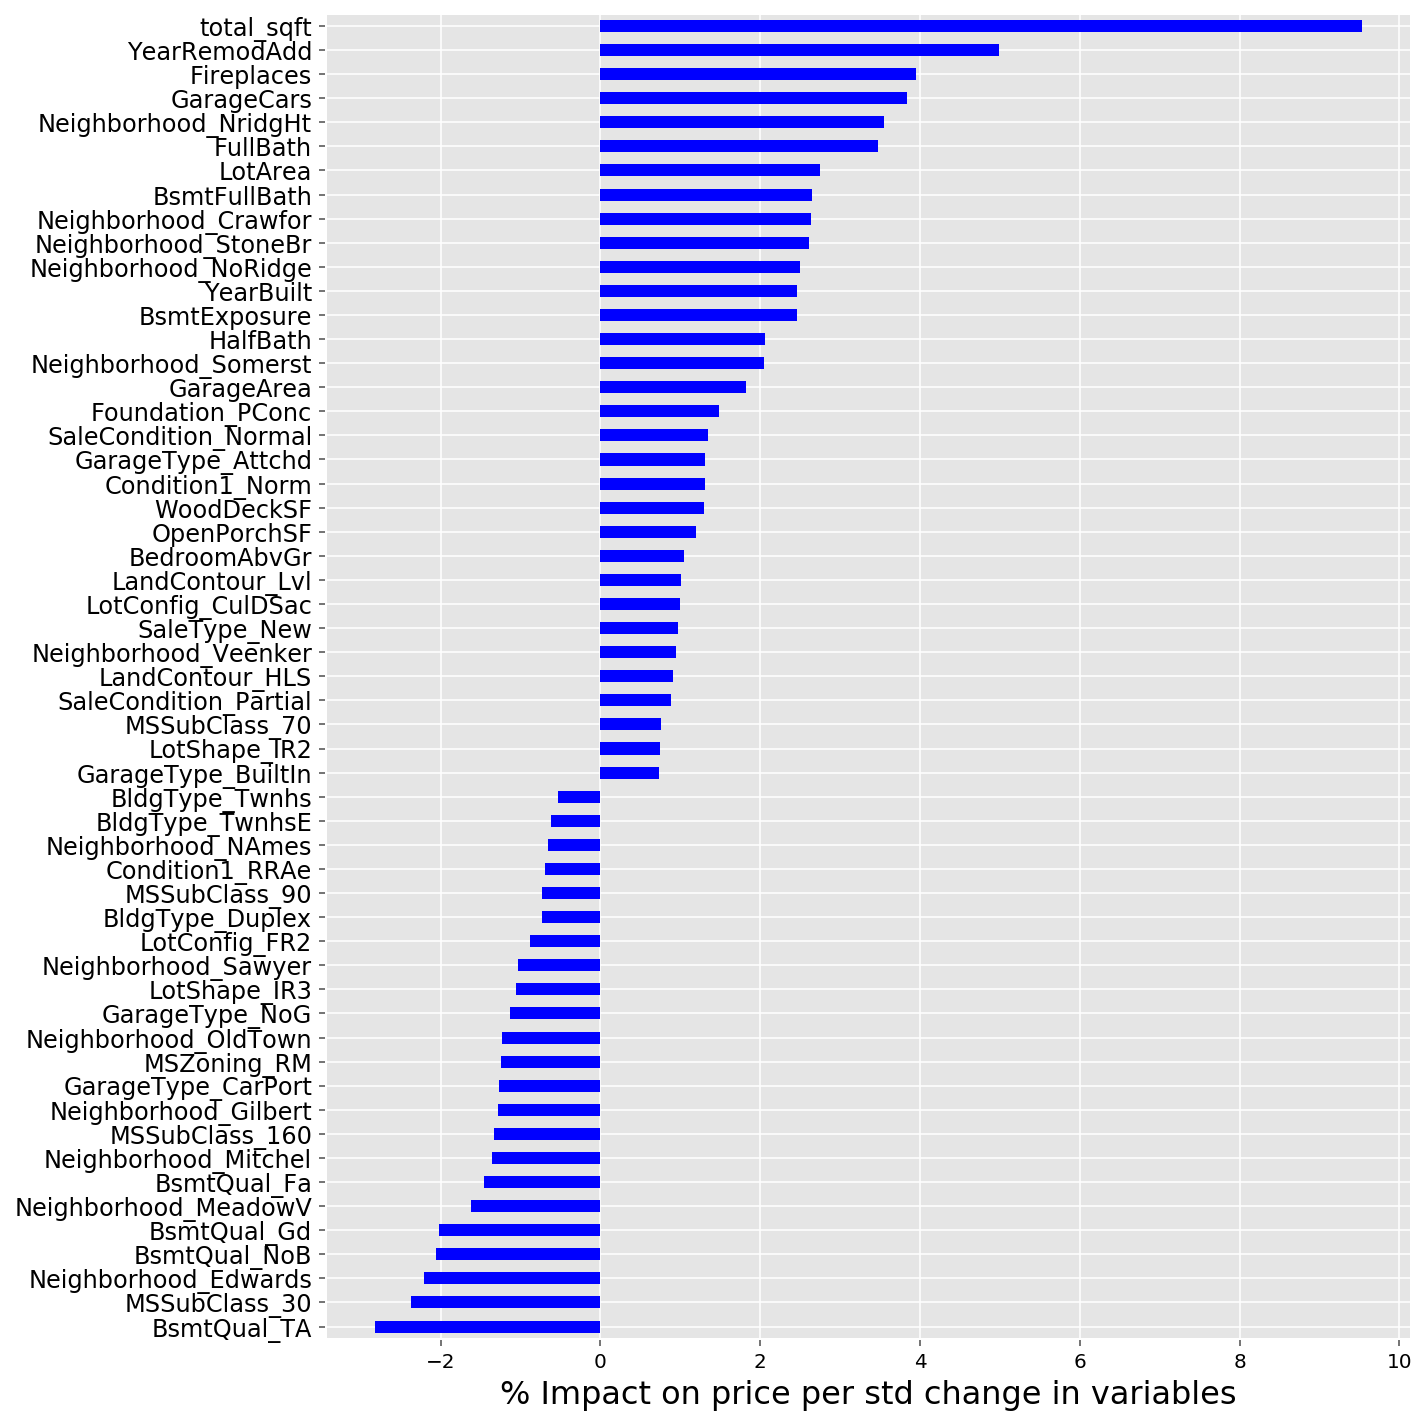

In [76]:
#Sense checking the optimal Ridge model
ridgeCV_opt = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=kf)
ridgeCV_opt.fit(X_opt, y_pre_2010)

#Cross Validation 
ridge_opt = Ridge(alpha=ridgeCV_opt.alpha_)

print(f'Optimal intercept(Ridge): {ridgeCV_opt.intercept_}')
print(f'Optimal alpha (Ridge): {ridgeCV_opt.alpha_}')
print(f'Optimal CV Score (Ridge): {cross_val_score(ridge_opt, X_opt, y_pre_2010, cv = kf).mean()}')
print(f'Optimal Train Score (Ridge): {ridgeCV_opt.score(X_opt, y_pre_2010)}')
print(f'Optimal Test Score (Ridge): {ridgeCV_opt.score(X_post_std.loc[:, columns_keep_ridge], y_post_2010)}')

#Visualising the optimal coefficients 
coef_ridge = pd.DataFrame(ridgeCV_opt.coef_, index=X_opt.columns,
                       columns=['coef_ridge'])
coef_ridge['coef_ridge_abs'] = coef_ridge.coef_ridge.abs()
coef_ridge['coef_ridge_price_impact'] = 100*(np.exp(coef_ridge.coef_ridge)-1)

plt.figure(figsize = (10,10))
coef_ridge['coef_ridge_price_impact'].sort_values().plot(kind='barh', color='b')
plt.xlabel('% Impact on price per std change in variables', fontsize = 16, color='k')
plt.xticks(color = 'k')
plt.yticks(fontsize=12, color = 'k');

### Extracting residuals from optimal ridge - best model right now 

For the next part of the brief, we have to estimate to what extent the renovatble features we discarded at the top can explain the discrepancies in the estimates vs the actual prices. So we take the residuals for each row and use this as our dependable variable for the next part.

In [77]:
res_train = y_pre_2010-ridgeCV_opt.predict(X_opt)
res_test = y_post_2010- ridgeCV_opt.predict(X_post_std.loc[:, columns_keep_ridge])
res_full = pd.concat([res_train, res_test]) 

print(res_train.shape, res_test.shape, res_full.shape)


(1278,) (172,) (1450,)


Visualising the normality of the distribution of the residuals

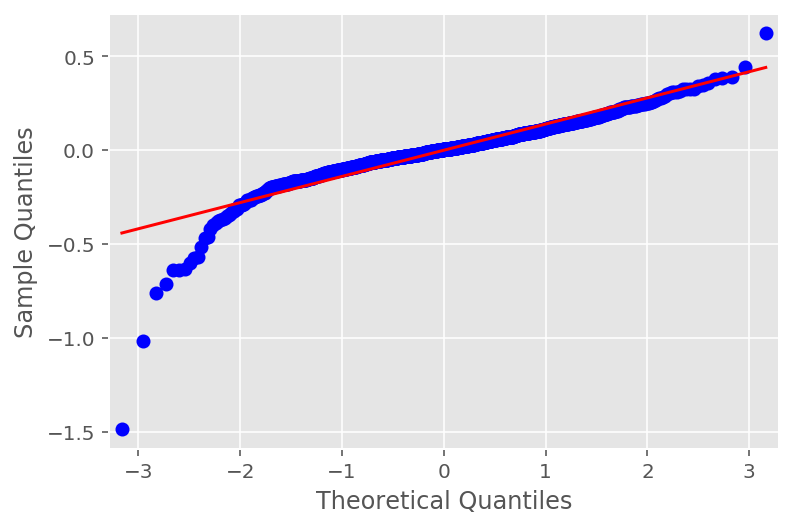

In [78]:
sm.qqplot(res_train, line='s');

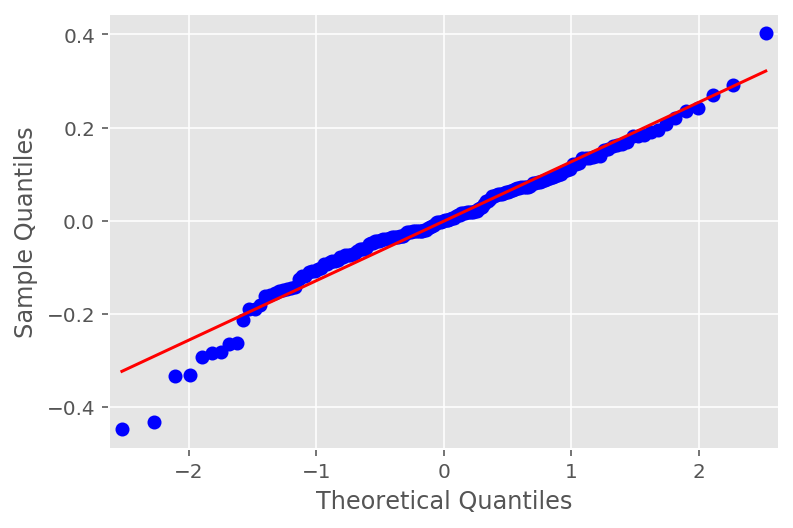

In [79]:
sm.qqplot(res_test, line='s');

### ElasticNetCV - best score: 0.847308

I did also test ElasticNet but it returned an l1-ratio of 1 which would mean it would emulate testing Lasso so I focused mainly on optimising Lasso and Ridge.

In [83]:
#Testing for the optimal alpha and l1 ratio
elasticnetCV = ElasticNetCV(n_alphas = 100, l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]), cv=kf)
elasticnetCV.fit(X_pre_std, y_pre_2010)

train_score = elasticnetCV.score(X_pre_std, y_pre_2010)
test_score = elasticnetCV.score(X_post_std, y_post_2010)

#Cross Validation 
elasticnet = ElasticNet(alpha=elasticnetCV.alpha_, l1_ratio = elasticnetCV.l1_ratio_)
cv_score = cross_val_score(elasticnet, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {elasticnetCV.intercept_}')
print(f'Model coeff: {elasticnetCV.coef_}')
print(f'Model alpha: {elasticnetCV.alpha_}')
print(f'Model l1_ratio: {elasticnetCV.l1_ratio_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Model intercept: 12.032355644349652
Model coeff: [-5.32097262e-03  3.02846818e-02  3.10753413e-02  5.40213764e-02
  2.28428497e-02  2.47881466e-02  2.85517613e-02  1.79257644e-02
  3.77181124e-03  3.55502212e-02  0.00000000e+00  4.67284825e-02
  6.66046878e-03  1.08311360e-02  7.38972732e-03  0.00000000e+00
  1.72384439e-03 -2.79861807e-03  1.17410671e-01 -0.00000000e+00
  0.00000000e+00 -1.25635629e-02  4.97900967e-03 -1.09642581e-02
 -0.00000000e+00  5.68254583e-03 -0.00000000e+00  6.64683499e-03
  7.30515054e-03 -5.88631468e-03 -6.51998903e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.02316287e-03 -0.00000000e+00
 -0.00000000e+00  2.72925603e-02 -1.99417813e-02 -8.01517460e-03
 -0.00000000e+00 -1.39374635e-02 -1.06243486e-02 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  2.25660167e-02  3.74245611e-02
 -8.69462058e-03 -0.00000000e+00 -5.67653590e-03  1.59247083e-05
  2.21756637e-02  2.57204829e-02  3.02435506e-03  7.46413380e-03
 -3.99618647e-03  1.06975407e-02  3.05061

## Part 2: Cost-effectiveness of renovatable features

The second part of the problem was to try to estimate how much of the residuals from the modelling in the first part can be explained by renovatable features. The steps for this second part mirror very closely the steps taken above.

### Choosing only the renovatable features

Chose only the feature that were discarded in the modelling for the first part above

In [84]:
fixed_cols

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'BsmtFinSF2',
 'HouseStyle',
 'YearBuilt',
 'YearRemodAdd',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageType',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'PoolArea',
 'ScreenPorch',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition',
 'SalePrice']

In [85]:
house_renov = house.loc[:, ~house.columns.isin(fixed_cols)].copy()
house_renov.head()
house_renov.columns
house_renov.shape

(1450, 27)

### Removing all the columns that have 90% of the same value

In [86]:
remove_features = []
for col in house_renov.columns: 
    if house_renov[col].value_counts(dropna=False).iloc[0]/house_renov[col].value_counts(dropna=False).sum() > 0.90:
        print(house_renov[col].value_counts(dropna=False),'-------------------------', sep='\n')
        remove_features.append(col)
remove_features

AllPub    1449
NoSeWa       1
Name: Utilities, dtype: int64
-------------------------
CompShg    1424
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
ClyTile       1
Roll          1
Name: RoofMatl, dtype: int64
-------------------------
GasA     1419
GasW       17
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64
-------------------------
Y    1361
N      89
Name: CentralAir, dtype: int64
-------------------------
SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64
-------------------------
TA     1319
NaN      79
Fa       34
Gd        9
Po        7
Ex        2
Name: GarageCond, dtype: int64
-------------------------
Y    1335
N      85
P      30
Name: PavedDrive, dtype: int64
-------------------------
NaN    1443
Gd        3
Ex        2
Fa        2
Name: PoolQC, dtype: int64
-------------------------


['Utilities',
 'RoofMatl',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageCond',
 'PavedDrive',
 'PoolQC']

In [87]:
house_renov.drop(columns = remove_features, inplace=True)

### Dealing with Null values

In [88]:
house_renov.isnull().sum()

OverallQual        0
OverallCond        0
RoofStyle          0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
BsmtCond          37
BsmtFinType1      37
BsmtFinType2      38
BsmtUnfSF          0
HeatingQC          0
KitchenQual        0
FireplaceQu      681
GarageFinish      79
GarageQual        79
Fence           1172
dtype: int64

#### Basement condition and ratings

In [89]:
#Fixing an error in the basement entry details for one datapoint
house_renov[house_renov.BsmtCond.isnull()]

mistake = house[~house.BsmtCond.isnull() & house.BsmtFinType2.isnull()].index

In [90]:
house[(house.BsmtFinType1 == 'GLQ') & ~house.BsmtFinType2.isnull() & 
      (house.BsmtFinSF2 != 0)]['BsmtFinType2'].value_counts()

LwQ    10
Rec     9
ALQ     4
BLQ     2
Name: BsmtFinType2, dtype: int64

In [91]:
#Replace the mistake with the most frequently occuring value
house_renov.loc[mistake, 'BsmtFinType2'] = 'LwQ'

In [92]:
house_renov.BsmtCond.fillna('NoB', inplace=True)
house_renov.BsmtFinType1.fillna('NoB', inplace=True)
house_renov.BsmtFinType2.fillna('NoB', inplace=True)

#### Masonry type

In [93]:
house_renov[~house_renov.MasVnrType.isnull()][:20]
house_renov[house_renov.MasVnrType=='None'][:10]

OverallQual  OverallCond RoofStyle Exterior1st Exterior2nd MasVnrType  \
1             6            8     Gable     MetalSd     MetalSd       None   
3             7            5     Gable     Wd Sdng     Wd Shng       None   
5             5            5     Gable     VinylSd     VinylSd       None   
8             7            5     Gable     BrkFace     Wd Shng       None   
9             5            6     Gable     MetalSd     MetalSd       None   
10            5            5       Hip     HdBoard     HdBoard       None   
12            5            6       Hip     HdBoard     Plywood       None   
15            7            8     Gable     Wd Sdng     Wd Sdng       None   
17            4            5     Gable     MetalSd     MetalSd       None   
18            5            5     Gable     VinylSd     VinylSd       None   

    MasVnrArea ExterQual ExterCond BsmtCond BsmtFinType1 BsmtFinType2  \
1          0.0        TA        TA       TA          ALQ          Unf   
3          0.0        TA        TA       Gd          ALQ          Unf   
5          0.0        TA        TA       TA          GLQ          Unf   
8          0.0        TA        TA       TA          Unf          Unf   
9          0.0        TA        TA       TA          GLQ          Unf   
10         0.0        TA        TA       TA          Rec          Unf   
12         0.0        TA        TA       TA          ALQ          Unf   
15         0.0        TA        TA       TA          Unf          Unf   
17         0.0        TA        TA      NoB          NoB          NoB   
18         0.0        TA        TA       TA          GLQ          Unf   

    BsmtUnfSF HeatingQC KitchenQual FireplaceQu GarageFinish GarageQual  Fence  
1         284        Ex          TA          TA          RFn         TA    NaN  
3         540        Gd          Gd          Gd          Unf         TA    NaN  
5          64        Ex          TA         NaN          Unf         TA  MnPrv  
8         952        Gd          TA          TA          Unf         Fa    NaN  
9         140        Ex          TA          TA          RFn         Gd    NaN  
10        134        Ex          TA         NaN          Unf         TA    NaN  
12        175        TA          TA         NaN          Unf         TA    NaN  
15        832        Ex          TA         NaN          Unf         TA  GdPrv  
17          0        TA          TA         NaN          Unf         TA    NaN  
18        468        Ex          Gd         NaN          Unf         TA    NaN

In [94]:
house_renov[house_renov.MasVnrType.isnull()]
house_renov.MasVnrType.fillna('None', inplace=True)
house_renov.MasVnrArea.fillna(0.0, inplace=True)

#### Garage

In [95]:
house_renov.GarageFinish.fillna('NoG', inplace=True)
house_renov.GarageQual.fillna('NoG', inplace=True)

#### Fireplace

In [96]:
#Only Na because there is no Fireplace 
house[house.FireplaceQu.isnull()]
house_renov.FireplaceQu.fillna('NoF', inplace=True)

#### Fence

In [97]:
house[house.Fence.isnull()][:100]
house_renov.Fence.fillna('NoFe', inplace=True)

### Analysing variables (Correlation map & Histograms)

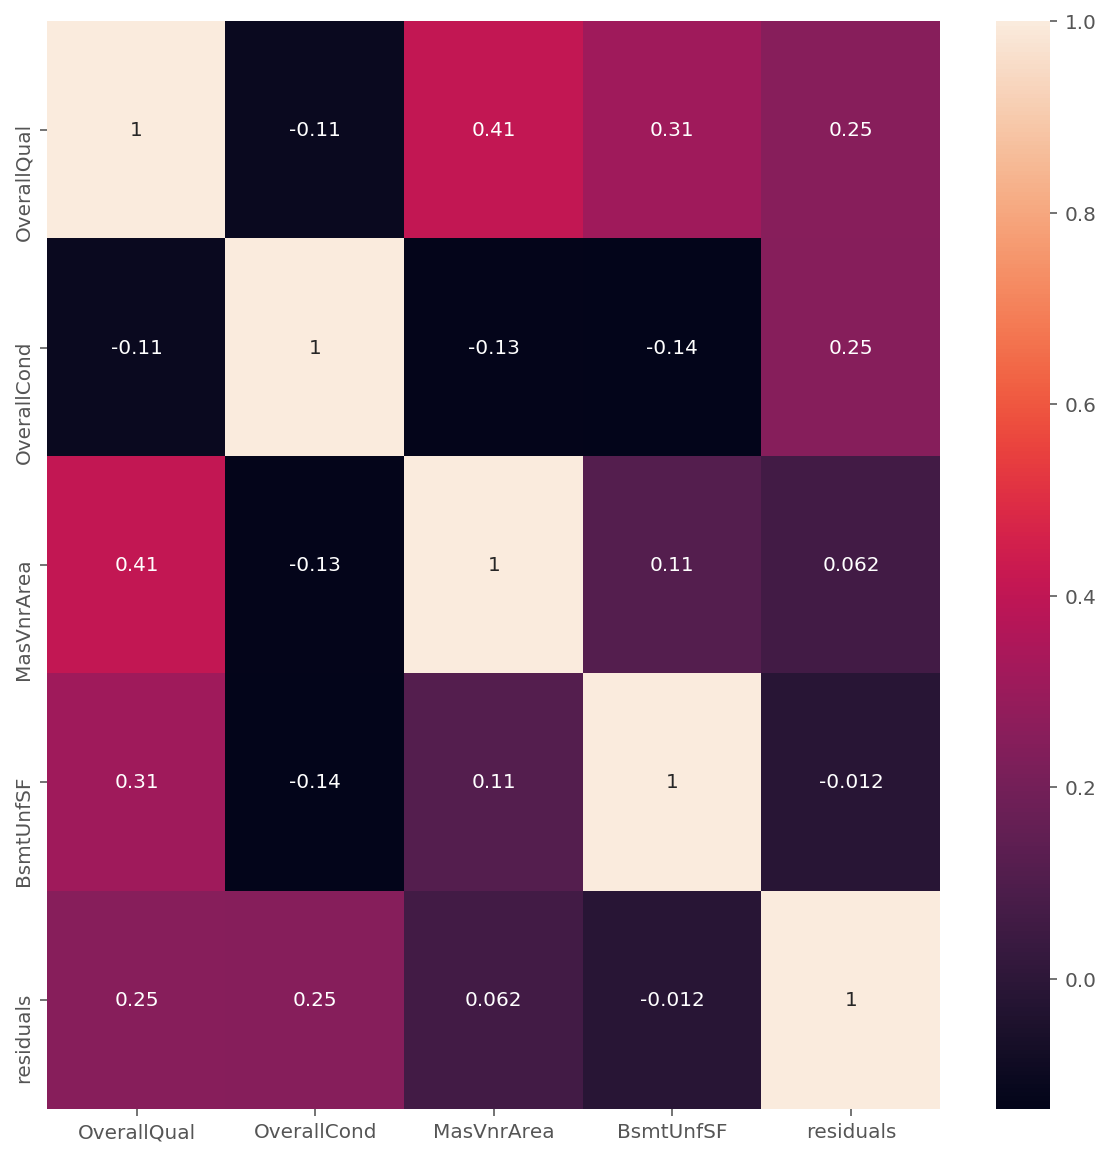

In [98]:
res_house_renov = house_renov.copy()
res_house_renov['residuals'] = res_full
plt.figure(figsize=(10,10))
sns.heatmap(res_house_renov.corr(), annot=True)
plt.show()

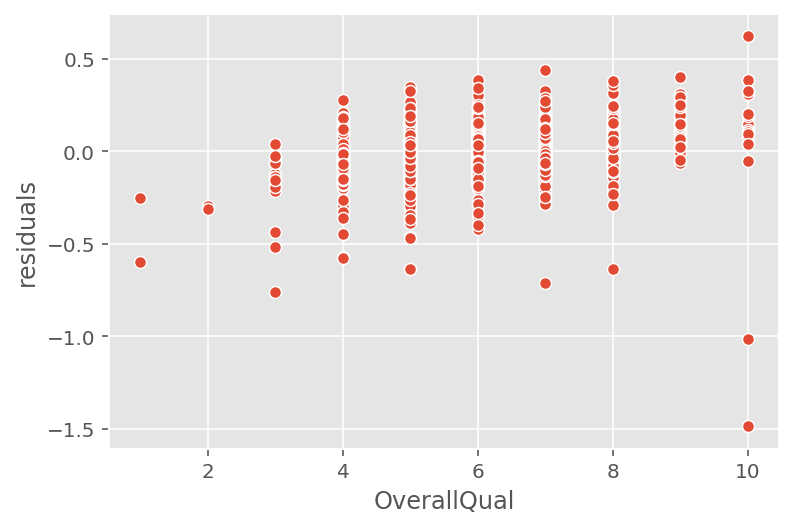

In [99]:
sns.scatterplot(res_house_renov.OverallQual, res_house_renov.residuals)
plt.show()

### Checking the skew of the variables

In [100]:
house_renov.skew()

OverallQual    0.237138
OverallCond    0.726570
MasVnrArea     2.666948
BsmtUnfSF      0.922304
dtype: float64

### Interaction elements & other feature engineering

I experimented with a few things here by looking at scatterplots to try convert some categorical features into numerical features with non-linear scales. 

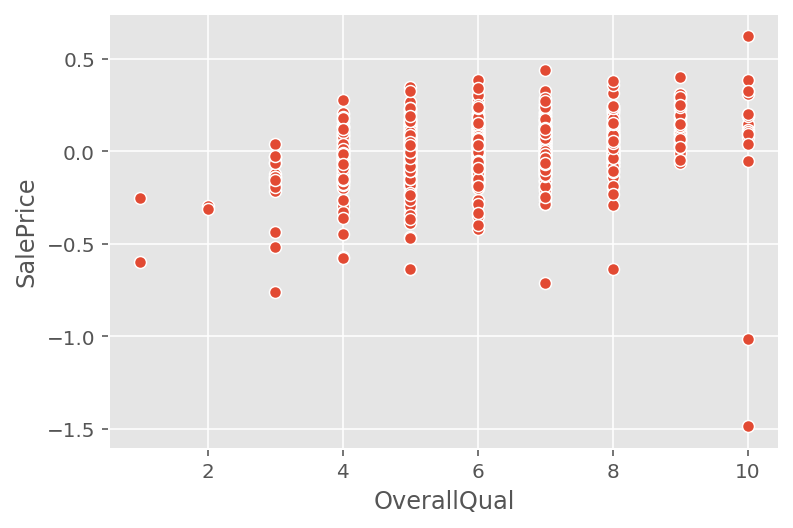

In [101]:
sns.scatterplot(house_renov.OverallQual, res_full)
plt.show()

In [102]:
#Raising Overall Condition feature for the power of 1.5 improved the score
house_renov['OverallCond_Sqr'] = house_renov.OverallCond**1.5
house_renov.OverallCond_Sqr.head(10)

0    11.180340
1    22.627417
2    11.180340
3    11.180340
4    11.180340
5    11.180340
6    11.180340
7    14.696938
8    11.180340
9    14.696938
Name: OverallCond_Sqr, dtype: float64

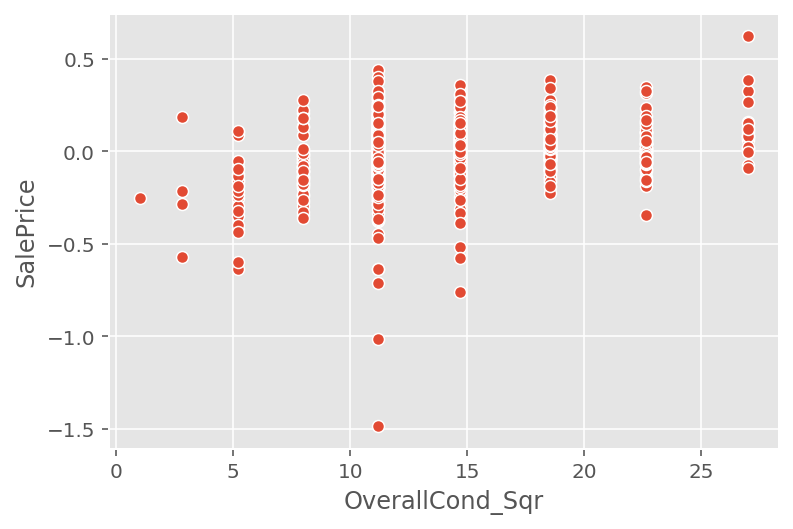

In [103]:
sns.scatterplot(house_renov.OverallCond_Sqr, res_full)
plt.show()

### Dummifying variables

In [104]:
to_dummify = list(house_renov.select_dtypes(include='object').columns)
to_dummify

['RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'Fence']

In [105]:
to_dummify +=['OverallQual']

In [106]:
house_renov_dum = pd.get_dummies(house_renov, columns = to_dummify, drop_first= True)
house_renov_dum.shape

(1450, 97)

### Splitting the data

We are again training the models with pre-2010 data and testing with post-2010.

In [107]:
#Check the index of the train and test set correspond correctly to the first model 
print(np.all(house_fixed[house_fixed.YrSold<2010].index == res_train.index))
print(np.all(house_fixed[house_fixed.YrSold>=2010].index == res_test.index))

True
True


In [108]:
X_pre_2010 = house_renov_dum.loc[house_renov_dum.index.isin(res_train.index), :]
X_post_2010 = house_renov_dum.loc[house_renov_dum.index.isin(res_test.index), :]
y_pre_2010 = res_train
y_post_2010 = res_test

In [109]:
X_pre_2010.shape, X_post_2010.shape, y_pre_2010.shape, y_post_2010.shape

((1278, 97), (172, 97), (1278,), (172,))

### Scaling the data

In [110]:
scaler = StandardScaler()
X_pre_std = pd.DataFrame(scaler.fit_transform(X_pre_2010), index = X_pre_2010.index, columns = X_pre_2010.columns)
X_post_std = pd.DataFrame(scaler.transform(X_post_2010), index = X_post_2010.index, columns = X_post_2010.columns)

### Linear Regression - best score: -1.402297e+25

In [111]:
linreg = LinearRegression()
linreg.fit(X_pre_std, y_pre_2010)

train_score = linreg.score(X_pre_std, y_pre_2010)
test_score = linreg.score(X_post_std, y_post_2010)

#Cross Validation 
cv_score = cross_val_score(linreg, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {linreg.intercept_}')
print(f'Model coeff: {linreg.coef_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Model intercept: -9.543935647270805e-17
Model coeff: [ 1.62564688e-01 -3.90336793e-03 -1.02501828e-03 -1.27384774e-01
 -8.23358792e-03  5.85481479e-04 -5.56943981e-03  5.49254030e-03
 -3.00336534e-04  1.81573205e+10 -5.87112010e-03  2.85860083e-02
 -3.13891209e+09  6.18002403e-03  1.95180025e-02 -1.40656877e-03
  2.27653669e-02  1.23408784e-02  8.24400950e-03  1.44795005e-02
  3.14914621e-02  7.57251817e-03  7.15570528e-03 -6.33535534e-03
 -3.81233318e-03 -1.09587877e-02  3.13891209e+09 -1.10715038e-02
 -4.03545419e-02 -2.05963974e-03 -3.38343086e-02 -5.71242545e-03
 -2.93495378e-02 -1.18660862e-02 -2.27406223e-02 -5.46147272e-02
 -1.99977217e-02 -1.97027786e-02  1.57249787e-02  9.45915269e-03
  2.12370049e-03  7.22515419e-03  7.07049410e-03  1.20496980e-02
 -1.42295135e-02 -3.02282852e-02 -2.33459075e+09 -2.90808399e-02
  1.30320580e-02  1.02971361e+10  1.15354352e-02  1.79644168e-02
  1.52046755e-03 -3.11364995e-03 -2.07748875e-03 -8.32120256e+10
  1.86954083e-03 -1.93741488e-02 -9.1

#### Visualising the coefficients

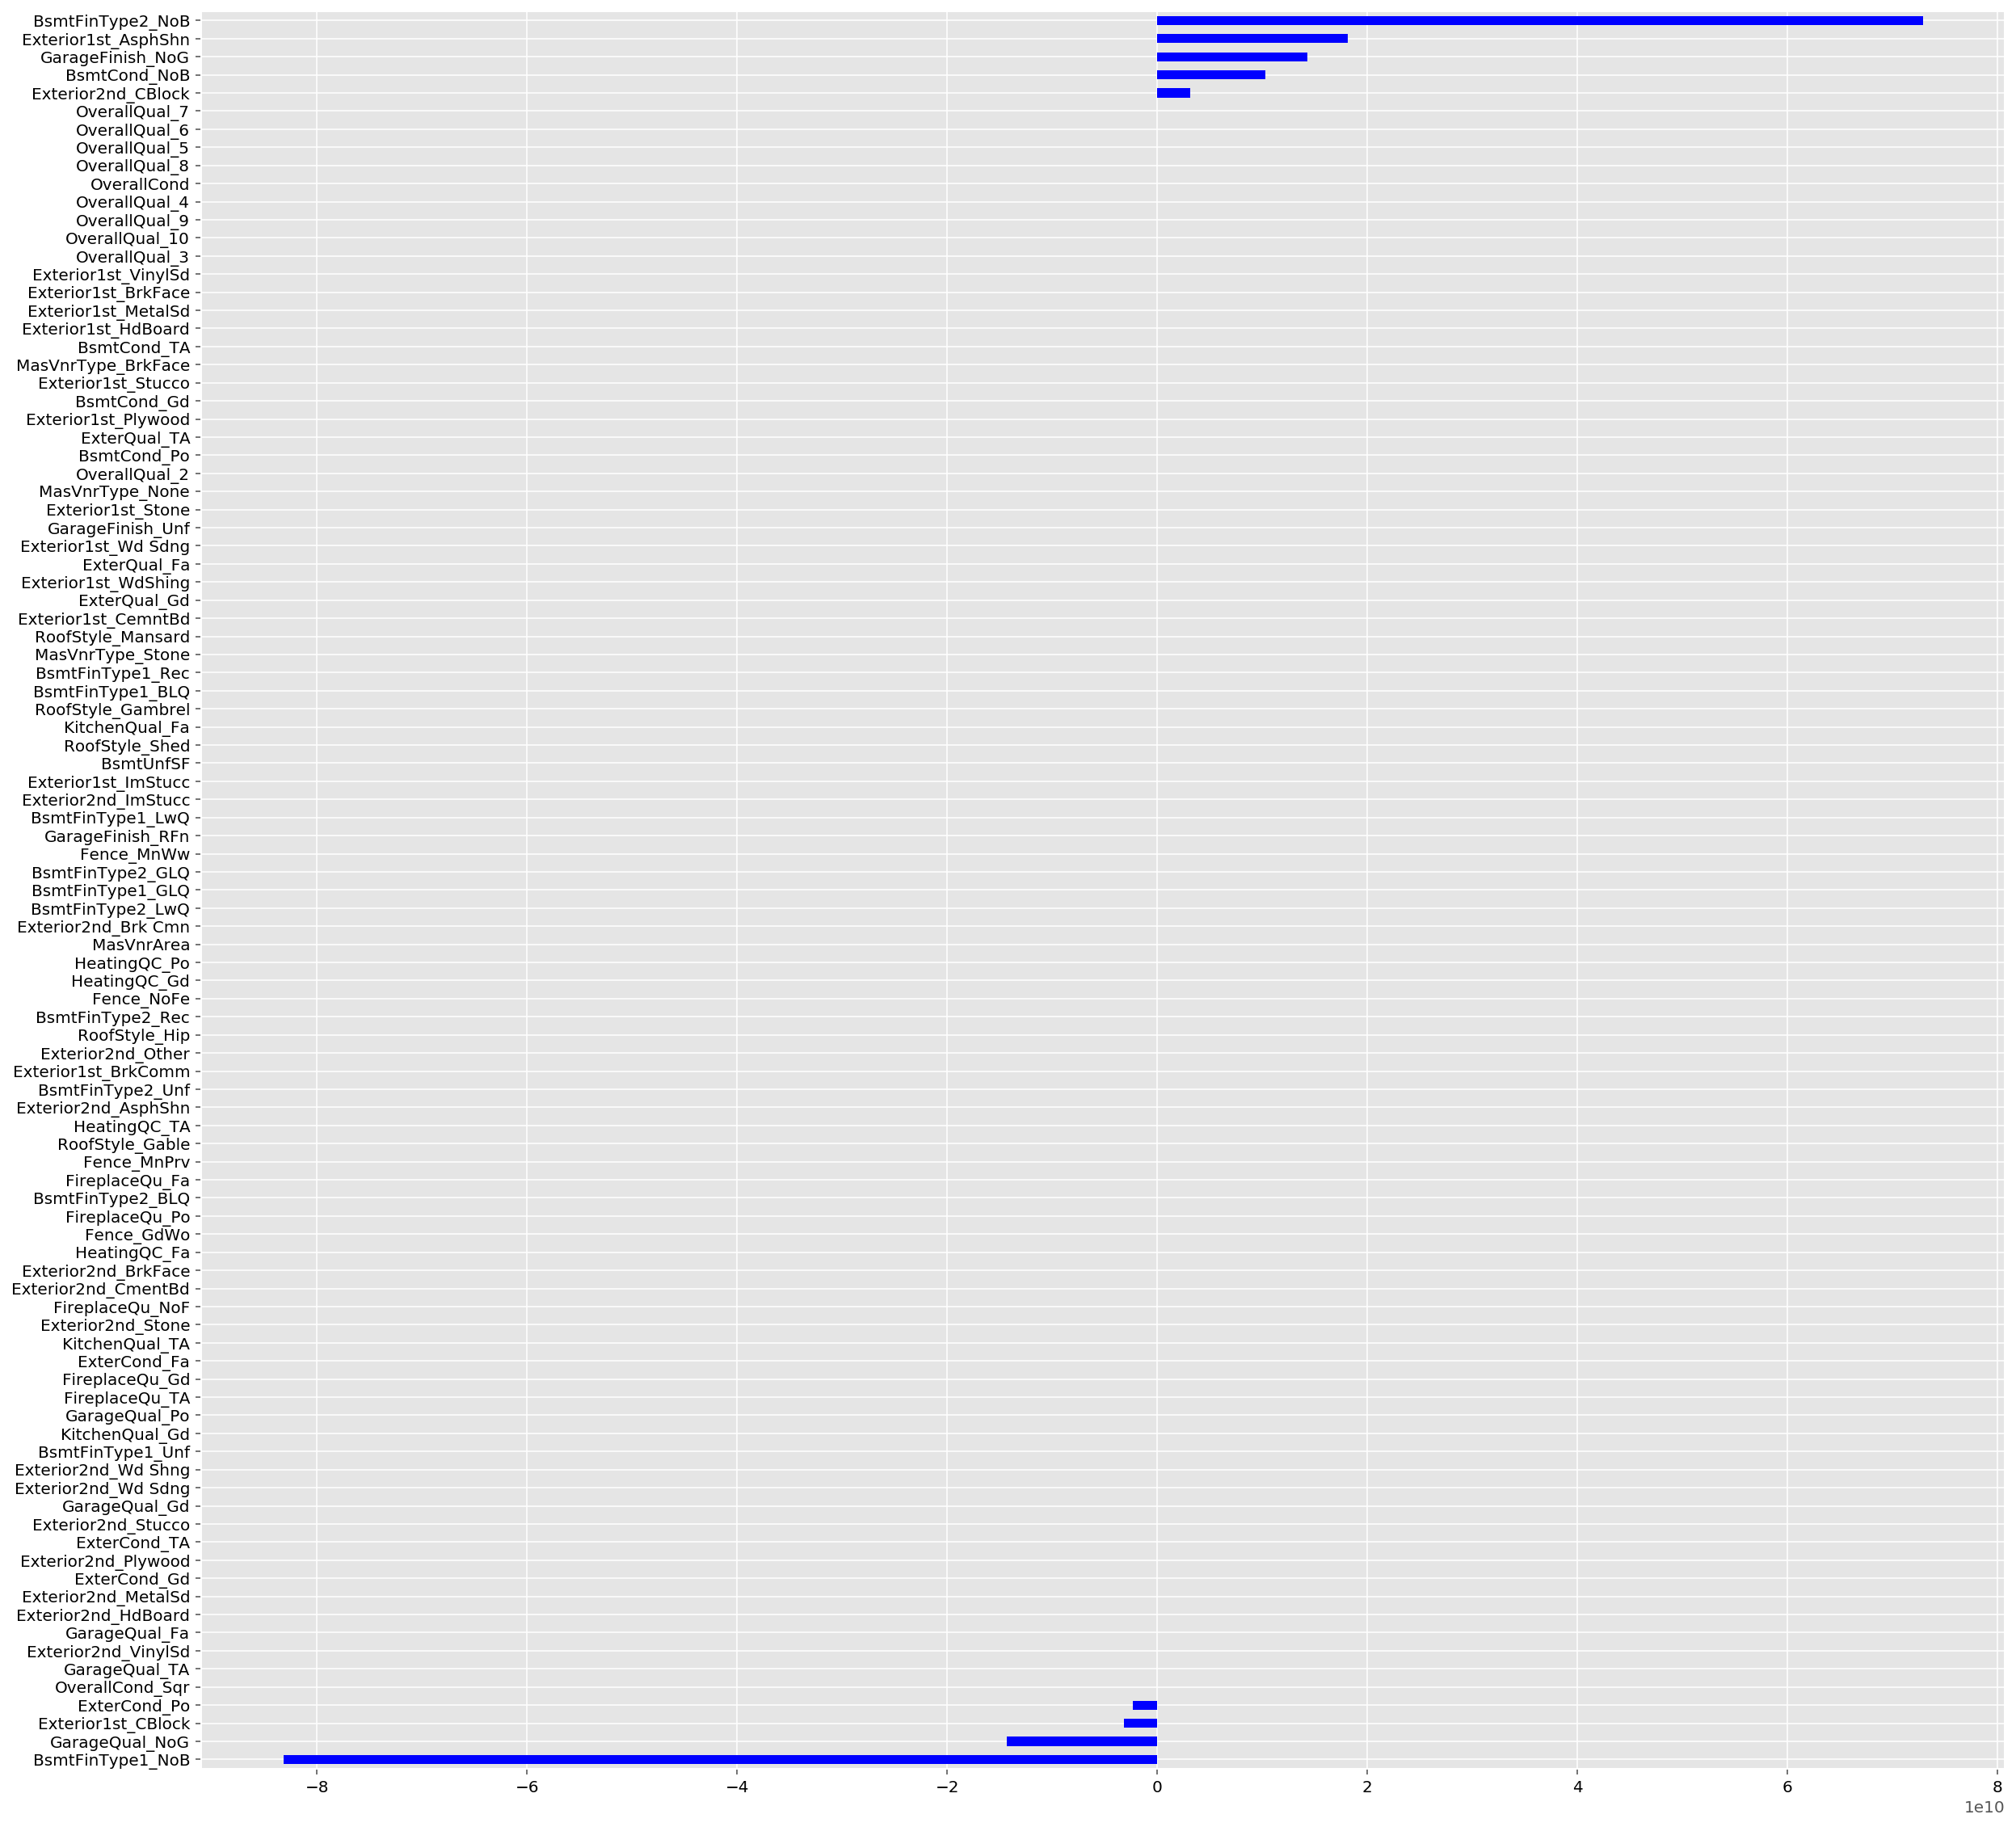

In [112]:
coef_linreg = pd.DataFrame(linreg.coef_, index=X_pre_std.columns,
                       columns=['coef_linreg'])
coef_linreg['coef_linreg_abs'] = coef_linreg.coef_linreg.abs()

plt.figure(figsize = (20,20))
coef_linreg['coef_linreg'].sort_values().plot(kind='barh', color = 'b')
plt.xticks(color = 'k')
plt.yticks(color = 'k');

### Lasso CV - best score: 0.189700

In [113]:
lassoCV = LassoCV(alphas = np.logspace(-4, 4, 100), cv=kf)
lassoCV.fit(X_pre_std, y_pre_2010)

train_score = lassoCV.score(X_pre_std, y_pre_2010)
test_score = lassoCV.score(X_post_std, y_post_2010)

#Cross Validation 
lasso = Lasso(alpha=lassoCV.alpha_)
cv_score = cross_val_score(lasso, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {lassoCV.intercept_}')
print(f'Model coeff: {lassoCV.coef_}')
print(f'Model alpha: {lassoCV.alpha_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00357315308858297, tolerance: 0.0018692891077116641
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003532104738674491, tolerance: 0.0018692891077116641
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026490038678890215, tolerance: 0.0018692891077116641
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did n

Model intercept: -1.1583734940860617e-16
Model coeff: [ 0.03491951  0.         -0.          0.         -0.00078117  0.
  0.          0.         -0.          0.         -0.00386832  0.01637209
 -0.          0.00088547 -0.         -0.          0.         -0.
  0.00023157 -0.         -0.         -0.         -0.          0.
 -0.          0.         -0.          0.         -0.00231074  0.
  0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.00033472  0.         -0.         -0.         -0.
  0.         -0.         -0.00149633 -0.          0.          0.
  0.          0.         -0.          0.00023059 -0.          0.00010375
 -0.          0.          0.         -0.01184295 -0.00189371  0.
 -0.          0.         -0.          0.         -0.0068623  -0.
 -0.         -0.00010967 -0.         -0.         -0.         -0.
  0.          0.         -0.00348655 -0.          0.         -0.
 -0.         -0.00199826  0.          0.         -0.         -0.
 -0.00336142 -0.0002

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018368754231966378, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023716520921972517, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015554029480451703, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did n

#### Visualising the coefficients

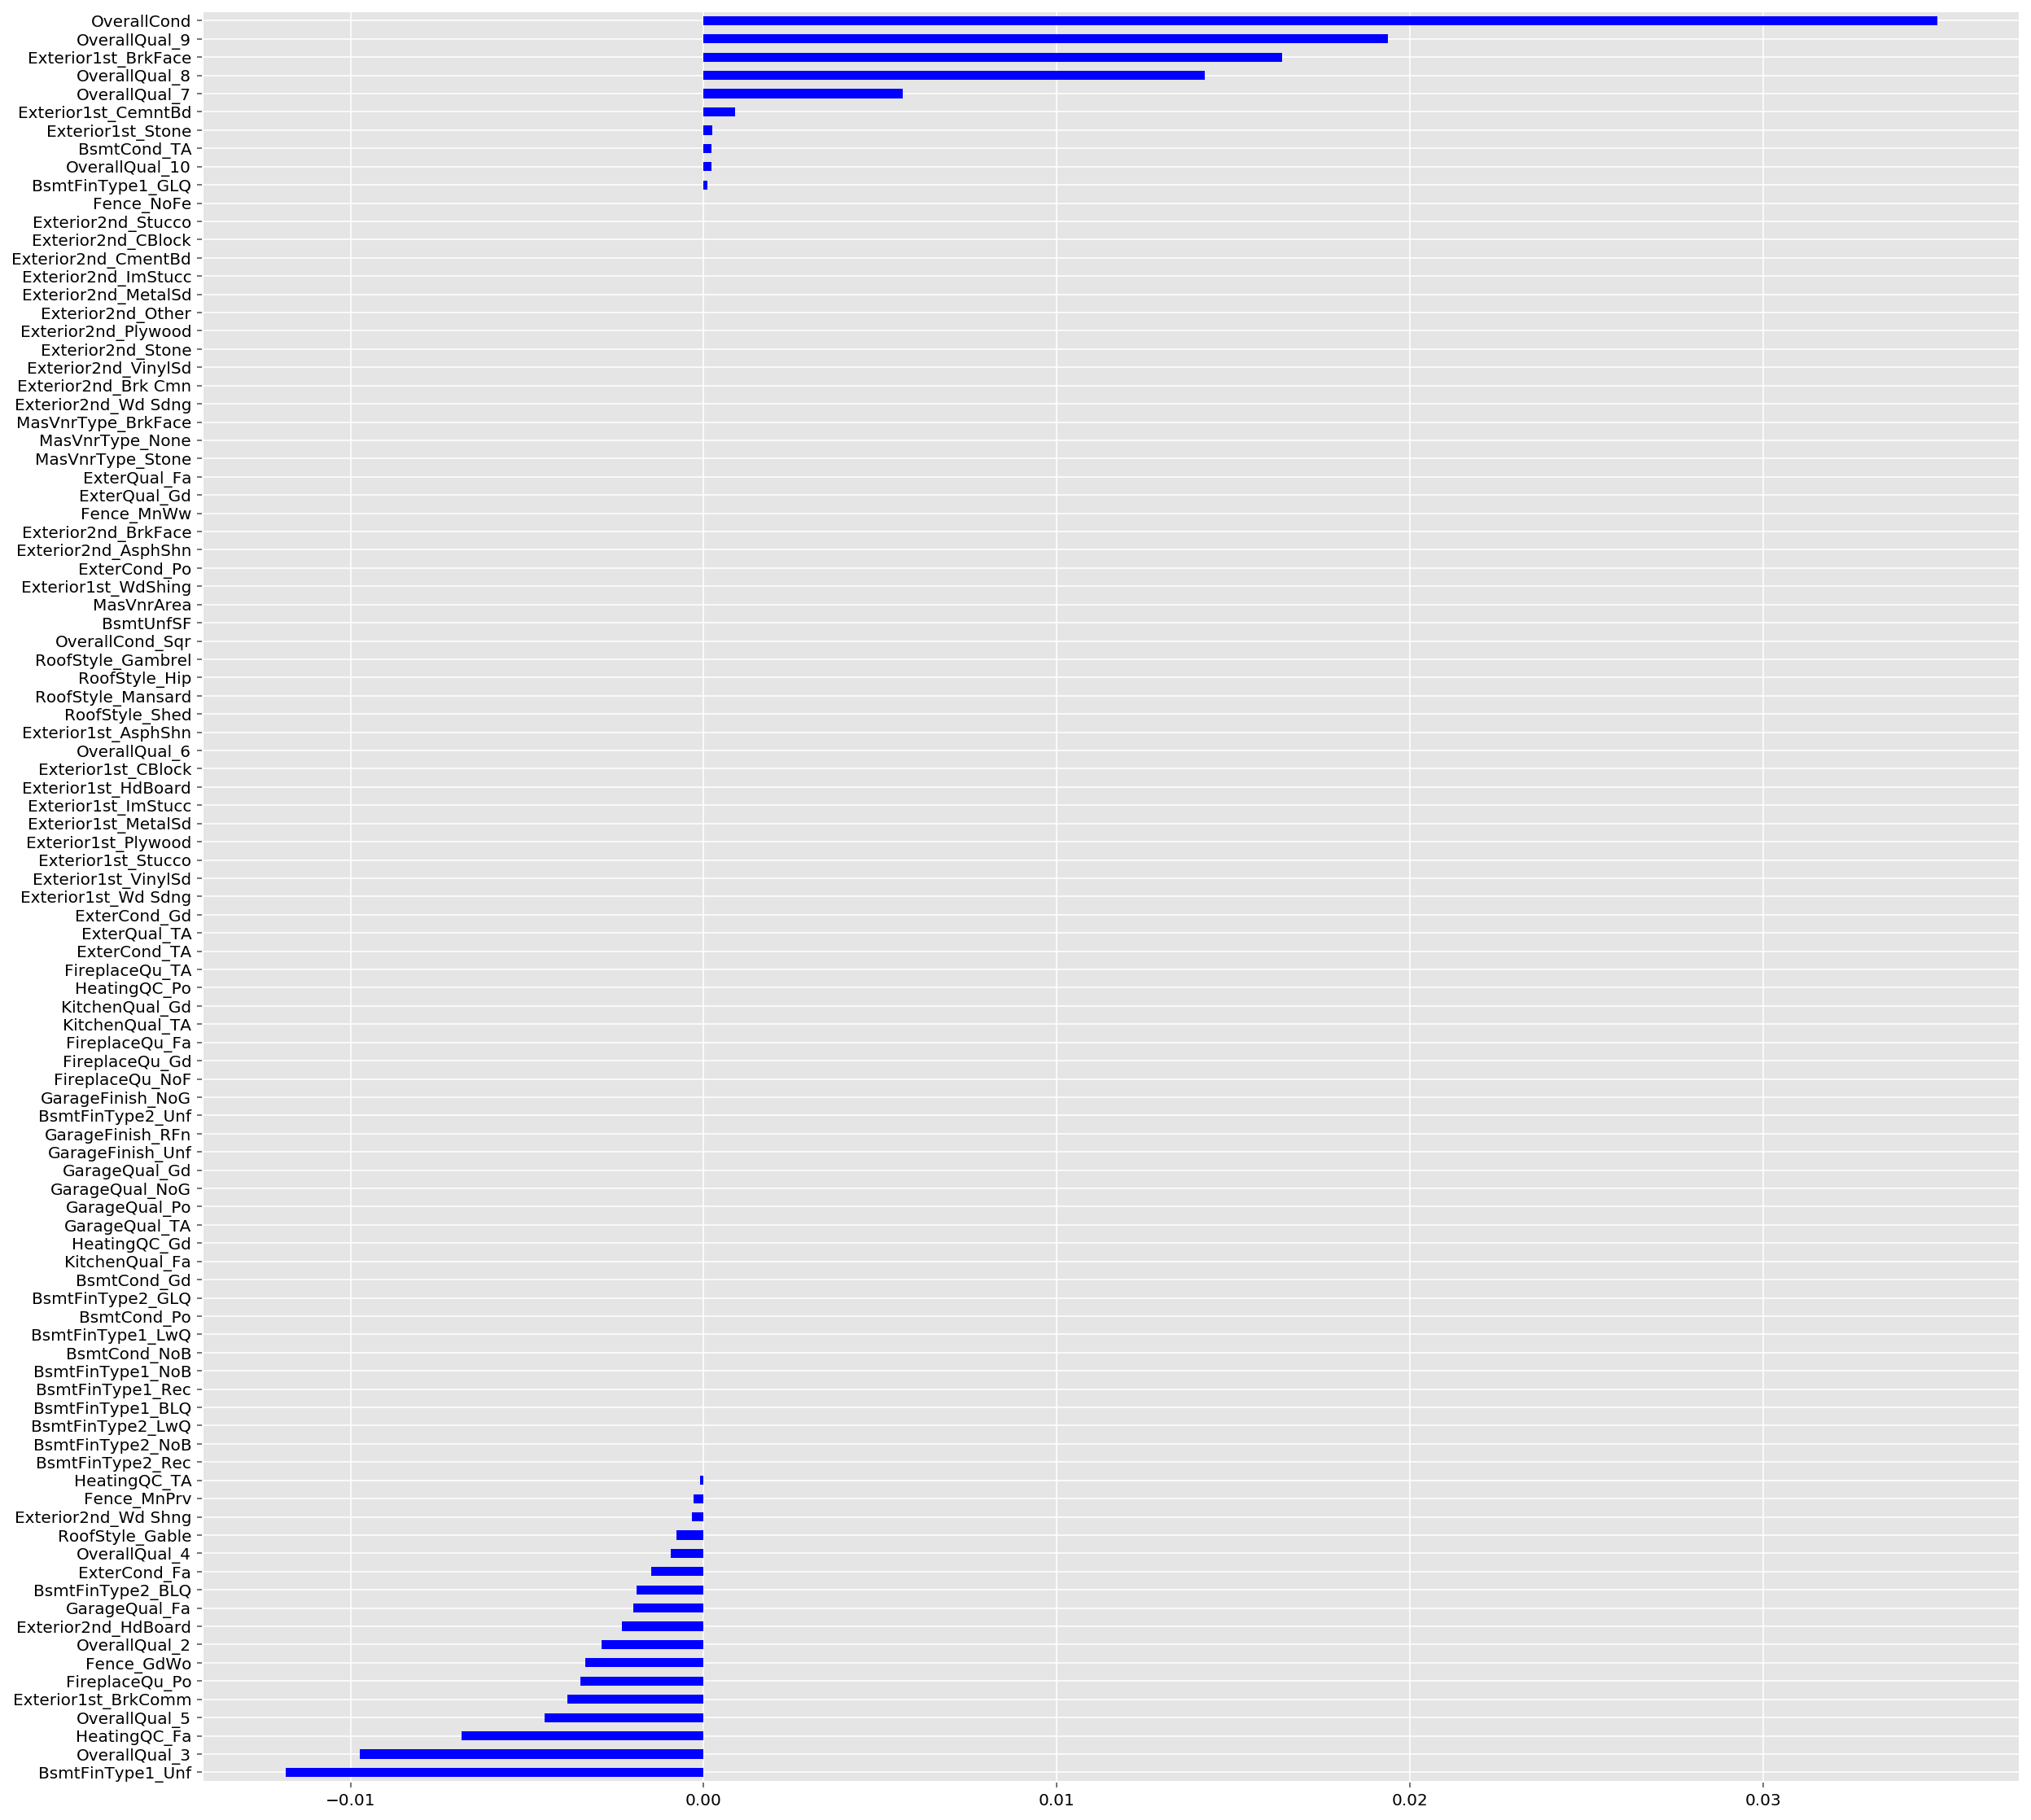

In [114]:
coef_lasso = pd.DataFrame(lassoCV.coef_, index=X_pre_std.columns,
                       columns=['coef_lasso'])
coef_lasso['coef_lasso_abs'] = coef_lasso.coef_lasso.abs()

plt.figure(figsize = (20,20))
coef_lasso['coef_lasso'].sort_values().plot(kind='barh', color='b')
plt.xticks(color = 'k')
plt.yticks(color = 'k');

#### Cutting down the coefficients

In [115]:
coef_lasso.sort_values(by='coef_lasso_abs')

coef_lasso  coef_lasso_abs
BsmtCond_Gd            0.000000        0.000000
GarageQual_Gd          0.000000        0.000000
MasVnrType_BrkFace     0.000000        0.000000
MasVnrType_None       -0.000000        0.000000
MasVnrType_Stone      -0.000000        0.000000
ExterQual_Fa          -0.000000        0.000000
ExterQual_Gd           0.000000        0.000000
ExterQual_TA          -0.000000        0.000000
GarageFinish_Unf      -0.000000        0.000000
ExterCond_Gd          -0.000000        0.000000
ExterCond_Po           0.000000        0.000000
ExterCond_TA           0.000000        0.000000
GarageFinish_RFn      -0.000000        0.000000
BsmtCond_NoB           0.000000        0.000000
BsmtCond_Po           -0.000000        0.000000
GarageFinish_NoG       0.000000        0.000000
BsmtFinType1_BLQ      -0.000000        0.000000
BsmtFinType1_LwQ      -0.000000        0.000000
KitchenQual_Gd        -0.000000        0.000000
KitchenQual_Fa        -0.000000        0.000000
HeatingQC_Po          -0.000000        0.000000
HeatingQC_Gd          -0.000000        0.000000
FireplaceQu_Gd         0.000000        0.000000
BsmtFinType2_Unf       0.000000        0.000000
Exterior2nd_Wd Sdng    0.000000        0.000000
BsmtFinType2_Rec      -0.000000        0.000000
BsmtFinType2_LwQ      -0.000000        0.000000
BsmtFinType2_GLQ       0.000000        0.000000
FireplaceQu_NoF        0.000000        0.000000
FireplaceQu_TA        -0.000000        0.000000
BsmtFinType1_Rec       0.000000        0.000000
BsmtFinType1_NoB       0.000000        0.000000
BsmtFinType2_NoB       0.000000        0.000000
KitchenQual_TA        -0.000000        0.000000
Exterior2nd_VinylSd   -0.000000        0.000000
Exterior2nd_Stone     -0.000000        0.000000
Exterior1st_HdBoard   -0.000000        0.000000
GarageQual_TA         -0.000000        0.000000
Exterior1st_CBlock    -0.000000        0.000000
Fence_MnWw            -0.000000        0.000000
Fence_NoFe             0.000000        0.000000
Exterior1st_AsphShn    0.000000        0.000000
Exterior1st_ImStucc   -0.000000        0.000000
RoofStyle_Shed        -0.000000        0.000000
RoofStyle_Hip          0.000000        0.000000
RoofStyle_Gambrel      0.000000        0.000000
OverallQual_6         -0.000000        0.000000
OverallCond_Sqr        0.000000        0.000000
BsmtUnfSF             -0.000000        0.000000
MasVnrArea             0.000000        0.000000
RoofStyle_Mansard      0.000000        0.000000
Exterior2nd_Stucco    -0.000000        0.000000
FireplaceQu_Fa        -0.000000        0.000000
Exterior1st_Plywood   -0.000000        0.000000
Exterior2nd_Plywood   -0.000000        0.000000
Exterior2nd_Other     -0.000000        0.000000
Exterior2nd_MetalSd    0.000000        0.000000
Exterior2nd_ImStucc    0.000000        0.000000
GarageQual_NoG         0.000000        0.000000
Exterior2nd_CmentBd    0.000000        0.000000
Exterior1st_MetalSd    0.000000        0.000000
Exterior2nd_CBlock    -0.000000        0.000000
Exterior2nd_Brk Cmn   -0.000000        0.000000
Exterior2nd_AsphShn    0.000000        0.000000
Exterior1st_WdShing   -0.000000        0.000000
Exterior1st_Wd Sdng   -0.000000        0.000000
Exterior1st_VinylSd   -0.000000        0.000000
Exterior1st_Stucco    -0.000000        0.000000
GarageQual_Po         -0.000000        0.000000
Exterior2nd_BrkFace    0.000000        0.000000
BsmtFinType1_GLQ       0.000104        0.000104
HeatingQC_TA          -0.000110        0.000110
OverallQual_10         0.000223        0.000223
BsmtCond_TA            0.000231        0.000231
Exterior1st_Stone      0.000232        0.000232
Fence_MnPrv           -0.000281        0.000281
Exterior2nd_Wd Shng   -0.000335        0.000335
RoofStyle_Gable       -0.000781        0.000781
Exterior1st_CemntBd    0.000885        0.000885
OverallQual_4         -0.000927        0.000927
ExterCond_Fa          -0.001496        0.001496
BsmtFinType2_BLQ      -0.001894        0.001894
GarageQual_Fa         -0.001998      

In [116]:
coef_thres = np.linspace(coef_lasso.coef_lasso_abs.min(),
                         coef_lasso.coef_lasso_abs.max(), num=50)
mean_cv_scores = []
cols_dropped = []
for thres in coef_thres:
    good_coef = coef_lasso[coef_lasso.coef_lasso_abs >= thres].index
    cols_dropped.append(len(X_pre_std.columns) - len(good_coef))

    X_subset = X_pre_std.loc[:, good_coef]

    lassoCV = LassoCV(n_alphas=100, cv=kf)
    lassoCV.fit(X_subset, y_pre_2010)
    lasso = Lasso(alpha=lassoCV.alpha_)
    mean_cv_scores.append(cross_val_score(
        lasso, X_subset, y_pre_2010, cv=kf).mean())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004130964341637622, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004640255493827183, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0046560876178034505, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020956708381483224, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003512713458283301, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003739102815751849, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008306118792212658, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008221956119191631, tolerance: 0.0019712880526730845
  tol, rng, random, positive)


In [117]:
improve_lasso = pd.DataFrame({'coef_thres_lasso': coef_thres, 'mean_cv_scores_lasso': mean_cv_scores, 
                              'cols_dropped_num_lasso': cols_dropped})

In [118]:
improve_lasso = improve_lasso.sort_values(by=['mean_cv_scores_lasso', 'cols_dropped_num_lasso'], 
                                          ascending =[False, False])
improve_lasso[:10]

coef_thres_lasso  mean_cv_scores_lasso  cols_dropped_num_lasso
6           0.004276              0.189700                      88
7           0.004989              0.187984                      89
3           0.002138              0.178131                      83
4           0.002851              0.177919                      84
5           0.003563              0.174902                      87
2           0.001425              0.174411                      80
8           0.005701              0.173557                      90
9           0.006414              0.173557                      90
1           0.000713              0.172365                      77
10          0.007126              0.167471                      91

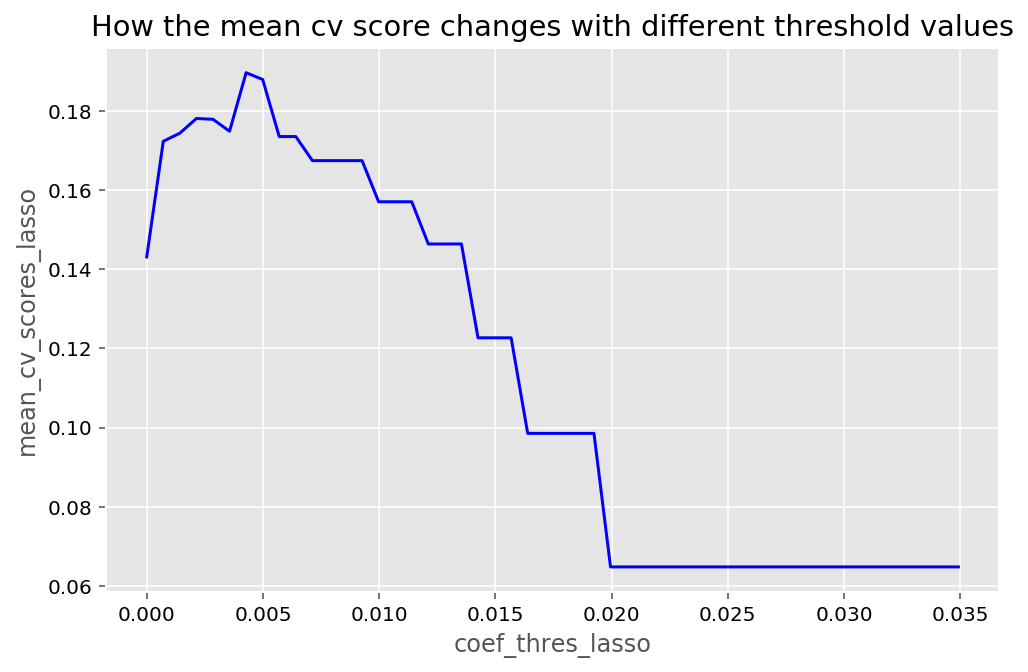

In [119]:
plt.figure(figsize = (8,5))
sns.lineplot(improve_lasso.coef_thres_lasso, improve_lasso.mean_cv_scores_lasso, color='b')
plt.title('How the mean cv score changes with different threshold values')
plt.xticks(color = 'k')
plt.yticks(color = 'k')
plt.show()

#### Optimal Lasso

In [120]:
opt_thres_lasso = improve_lasso['coef_thres_lasso'].iloc[0]
print(opt_thres_lasso)
columns_keep_lasso = coef_lasso[coef_lasso.coef_lasso_abs > opt_thres_lasso].index
X_opt = X_pre_std.loc[:, columns_keep_lasso]

0.004275858337601077


Optimal intercept(Lasso): -1.1582535130523907e-16
Optimal alpha (Lasso): 3.7011102061481725e-05
Optimal CV Score (Lasso): 0.18969961300870633
Optimal Train Score (Lasso): 0.19809100011258896
Optimal Test Score (Lasso): 0.08800860705882307


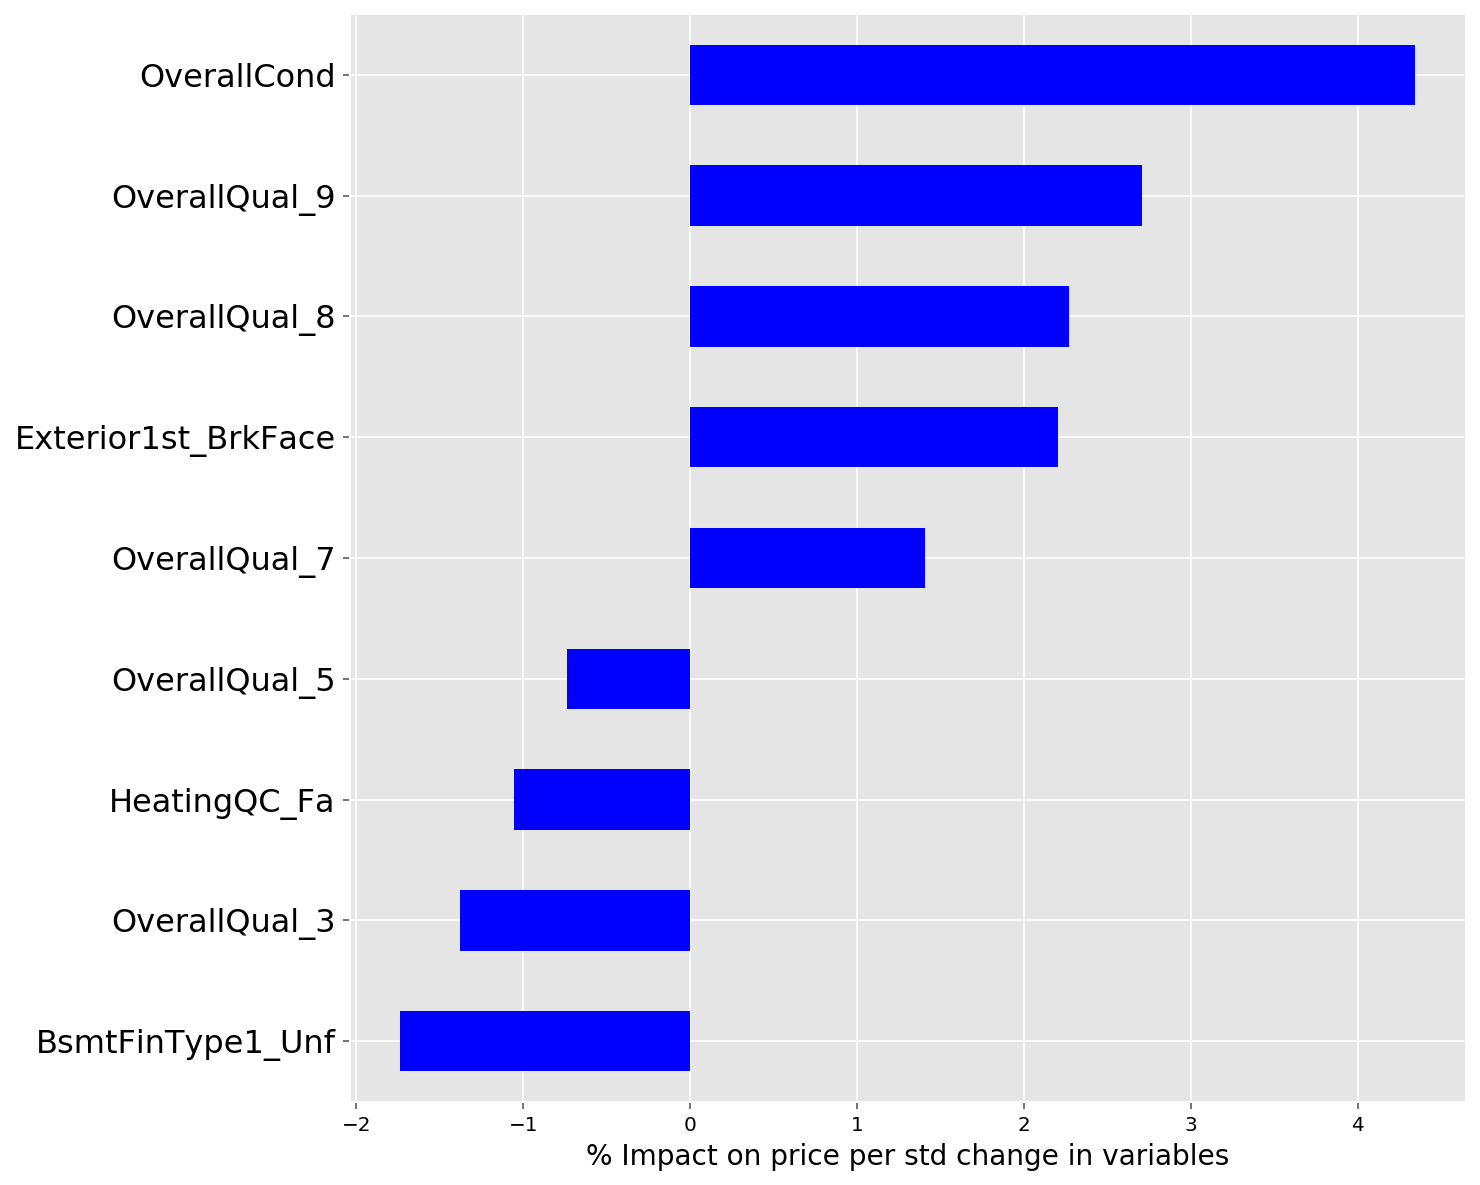

In [121]:
#Sense checking the optimal Lasso model
lassoCV_opt = LassoCV(n_alphas = 100, cv=kf)
lassoCV_opt.fit(X_opt, y_pre_2010)

#Cross Validation 
lasso_opt = Lasso(alpha=lassoCV_opt.alpha_)


print(f'Optimal intercept(Lasso): {lassoCV_opt.intercept_}')
print(f'Optimal alpha (Lasso): {lassoCV_opt.alpha_}')
print(f'Optimal CV Score (Lasso): {cross_val_score(lasso_opt, X_opt, y_pre_2010, cv = kf).mean()}')
print(f'Optimal Train Score (Lasso): {lassoCV_opt.score(X_opt, y_pre_2010)}')
print(f'Optimal Test Score (Lasso): {lassoCV_opt.score(X_post_std.loc[:, columns_keep_lasso], y_post_2010)}')


#Visualising the optimal coefficients
coef_lasso = pd.DataFrame(lassoCV_opt.coef_, index=X_opt.columns,
                       columns=['coef_lasso'])
coef_lasso['coef_lasso_abs'] = coef_lasso.coef_lasso.abs()
coef_lasso['coef_lasso_price_impact'] = (np.exp(coef_lasso.coef_lasso)-1)*100

plt.figure(figsize = (10,10))
coef_lasso['coef_lasso_price_impact'].sort_values().plot(kind='barh', color='b')
plt.xlabel('% Impact on price per std change in variables', fontsize = 14, color='k')
plt.xticks(color = 'k')
plt.yticks(fontsize=16, color = 'k');

### Ridge CV - Ridge is again a Smidge Better! - best score: 0.198993

Like the previous model, Ridge was slighly better than Lasso in terms of mean cv scores. From visualising the largest coefficients from the optimal Ridge model, we can see that the Overall Condition rating, having an Brickface exterior finishing seem to contribute positively to explain the variation in price for the estimated vs actual house prices. It would be safe to assume that they contribute positively to overall house price and hence would be wise to renovate and upgrade the finishing of the home (as cost effectively as possible) to improve the sale price. However, given the low R2 score, more work may needs to done before we can put a lot of weight on the findings of the second model. 

The cv score being this low is not surprisingly as we are trying to estimate the residuals from another model and the residuals have an element irreducible amount of error which we cannot predict without overfitting. 

In [122]:
ridgeCV = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=kf)
ridgeCV.fit(X_pre_std, y_pre_2010)

train_score = ridgeCV.score(X_pre_std, y_pre_2010)
test_score = ridgeCV.score(X_post_std, y_post_2010)

#Cross Validation 
ridge = Ridge(alpha=ridgeCV.alpha_)
cv_score = cross_val_score(ridge, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {ridgeCV.intercept_}')
print(f'Model coeff: {ridgeCV.coef_}')
print(f'Model alpha: {ridgeCV.alpha_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Model intercept: -1.164824228377876e-16
Model coeff: [ 2.02207701e-02 -2.46724350e-03 -1.48058955e-03  1.48368451e-02
 -3.51363712e-03  1.06544148e-03 -3.40192403e-04  5.07254364e-03
 -2.68391086e-04  0.00000000e+00 -7.76546109e-03  1.73264219e-02
  2.26695115e-04  1.03192950e-03 -1.61781040e-03 -1.78866411e-03
  1.01855721e-03 -1.54720836e-04  5.58614251e-03  5.25420331e-03
 -1.67101370e-03 -7.94128574e-03 -1.60468920e-03 -1.40357949e-03
  1.43889433e-03  1.10784627e-03  2.26695115e-04  1.38561086e-03
 -6.23736563e-03  4.31606197e-03  1.09250573e-03 -2.42755864e-03
 -3.08388048e-03 -5.18755039e-03 -8.85466209e-03 -3.26729623e-03
  6.74981617e-03 -4.12786506e-03  5.82268439e-03  6.06212300e-04
 -2.22803265e-03 -1.73243805e-03  6.62430501e-04  1.48778409e-03
 -4.13259513e-03 -2.78516640e-03  0.00000000e+00  1.28243469e-03
  7.54519904e-03  3.49203271e-03 -2.73414390e-03  1.11714571e-02
  1.92670708e-03  7.30124498e-04  8.55703231e-05  3.49203271e-03
  3.61245040e-03 -1.37168509e-02 -6.7

#### Visualising coefficients

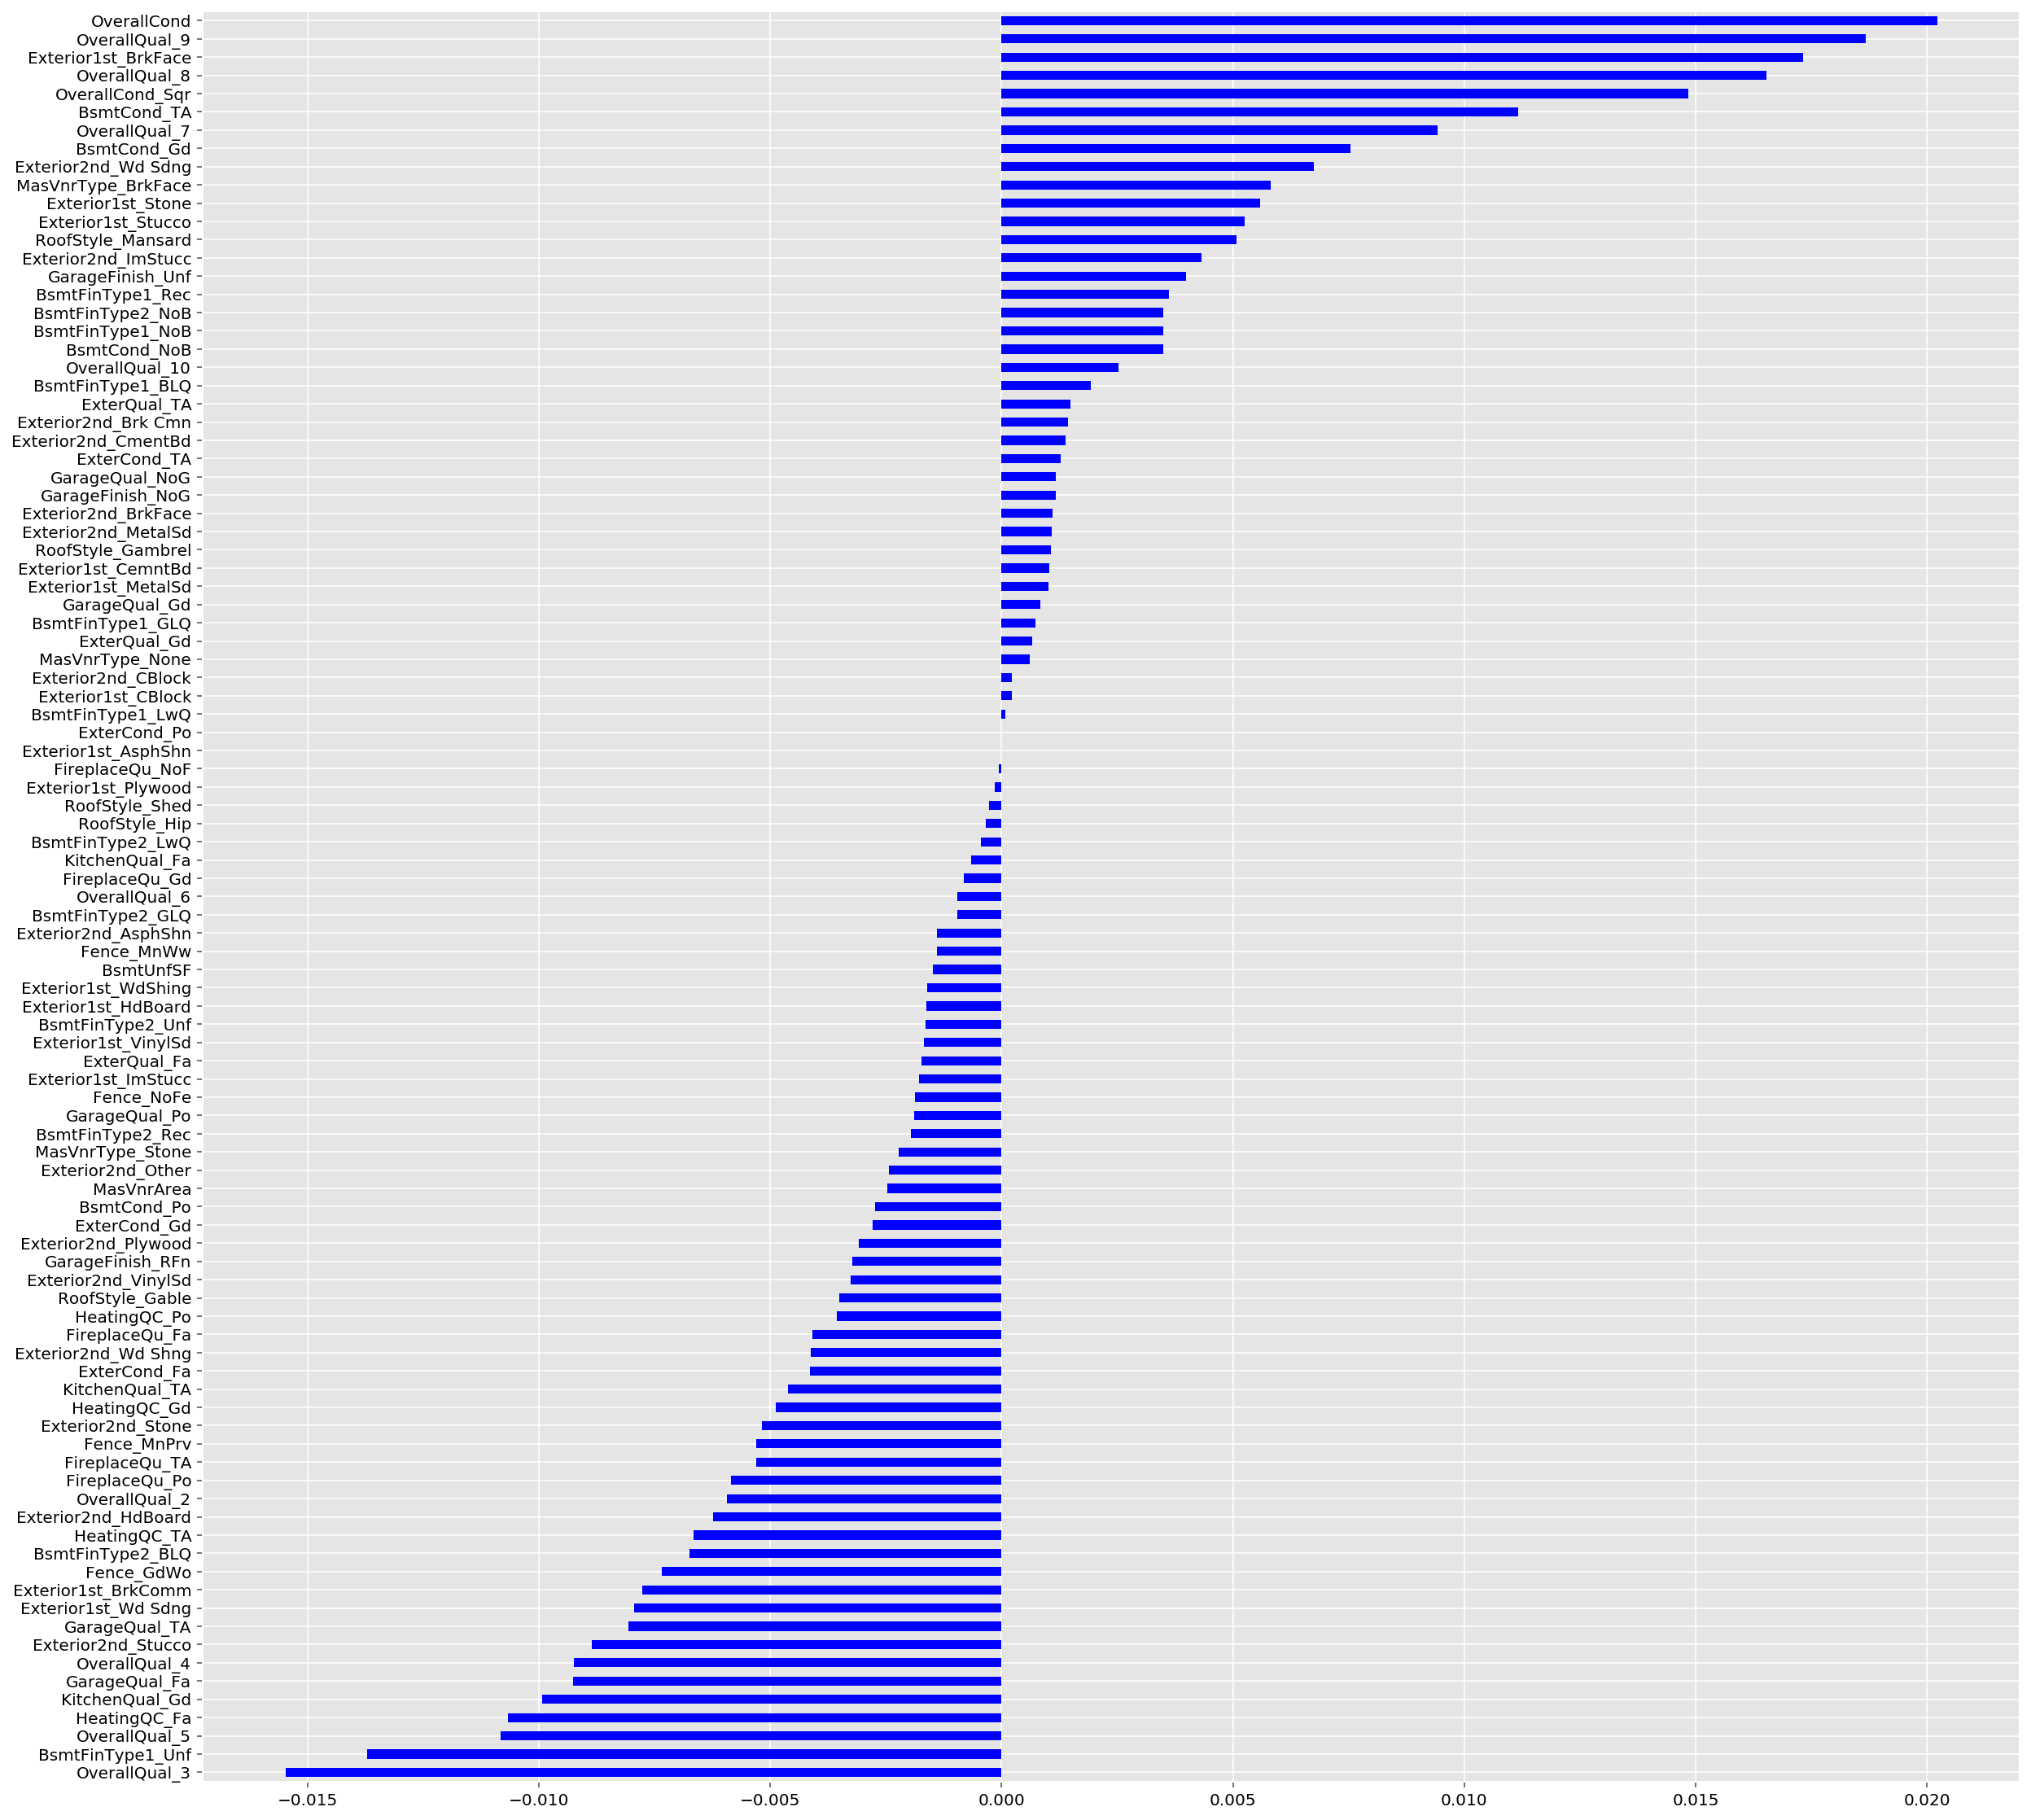

In [125]:
coef_ridge= pd.DataFrame(ridgeCV.coef_, index=X_pre_std.columns,
                       columns=['coef_ridge'])
coef_ridge['coef_ridge_abs'] = coef_ridge.coef_ridge.abs()

plt.figure(figsize = (20,20))
coef_ridge['coef_ridge'].sort_values().plot(kind='barh', color='b')
plt.xticks(color = 'k')
plt.yticks(color = 'k');

#### Cutting down the coefficients

In [126]:
coef_ridge.sort_values(by='coef_ridge_abs')

coef_ridge  coef_ridge_abs
ExterCond_Po           0.000000        0.000000
Exterior1st_AsphShn    0.000000        0.000000
FireplaceQu_NoF       -0.000053        0.000053
BsmtFinType1_LwQ       0.000086        0.000086
Exterior1st_Plywood   -0.000155        0.000155
Exterior1st_CBlock     0.000227        0.000227
Exterior2nd_CBlock     0.000227        0.000227
RoofStyle_Shed        -0.000268        0.000268
RoofStyle_Hip         -0.000340        0.000340
BsmtFinType2_LwQ      -0.000442        0.000442
MasVnrType_None        0.000606        0.000606
KitchenQual_Fa        -0.000655        0.000655
ExterQual_Gd           0.000662        0.000662
BsmtFinType1_GLQ       0.000730        0.000730
FireplaceQu_Gd        -0.000817        0.000817
GarageQual_Gd          0.000832        0.000832
OverallQual_6         -0.000960        0.000960
BsmtFinType2_GLQ      -0.000964        0.000964
Exterior1st_MetalSd    0.001019        0.001019
Exterior1st_CemntBd    0.001032        0.001032
RoofStyle_Gambrel      0.001065        0.001065
Exterior2nd_MetalSd    0.001093        0.001093
Exterior2nd_BrkFace    0.001108        0.001108
GarageFinish_NoG       0.001174        0.001174
GarageQual_NoG         0.001174        0.001174
ExterCond_TA           0.001282        0.001282
Exterior2nd_CmentBd    0.001386        0.001386
Exterior2nd_AsphShn   -0.001404        0.001404
Fence_MnWw            -0.001404        0.001404
Exterior2nd_Brk Cmn    0.001439        0.001439
BsmtUnfSF             -0.001481        0.001481
ExterQual_TA           0.001488        0.001488
Exterior1st_WdShing   -0.001605        0.001605
Exterior1st_HdBoard   -0.001618        0.001618
BsmtFinType2_Unf      -0.001636        0.001636
Exterior1st_VinylSd   -0.001671        0.001671
ExterQual_Fa          -0.001732        0.001732
Exterior1st_ImStucc   -0.001789        0.001789
Fence_NoFe            -0.001865        0.001865
GarageQual_Po         -0.001888        0.001888
BsmtFinType1_BLQ       0.001927        0.001927
BsmtFinType2_Rec      -0.001963        0.001963
MasVnrType_Stone      -0.002228        0.002228
Exterior2nd_Other     -0.002428        0.002428
MasVnrArea            -0.002467        0.002467
OverallQual_10         0.002518        0.002518
BsmtCond_Po           -0.002734        0.002734
ExterCond_Gd          -0.002785        0.002785
Exterior2nd_Plywood   -0.003084        0.003084
GarageFinish_RFn      -0.003220        0.003220
Exterior2nd_VinylSd   -0.003267        0.003267
BsmtFinType1_NoB       0.003492        0.003492
BsmtCond_NoB           0.003492        0.003492
BsmtFinType2_NoB       0.003492        0.003492
RoofStyle_Gable       -0.003514        0.003514
HeatingQC_Po          -0.003563        0.003563
BsmtFinType1_Rec       0.003612        0.003612
GarageFinish_Unf       0.003989        0.003989
FireplaceQu_Fa        -0.004086        0.004086
Exterior2nd_Wd Shng   -0.004128        0.004128
ExterCond_Fa          -0.004133        0.004133
Exterior2nd_ImStucc    0.004316        0.004316
KitchenQual_TA        -0.004615        0.004615
HeatingQC_Gd          -0.004880        0.004880
RoofStyle_Mansard      0.005073        0.005073
Exterior2nd_Stone     -0.005188        0.005188
Exterior1st_Stucco     0.005254        0.005254
Fence_MnPrv           -0.005301        0.005301
FireplaceQu_TA        -0.005306        0.005306
Exterior1st_Stone      0.005586        0.005586
MasVnrType_BrkFace     0.005823        0.005823
FireplaceQu_Po        -0.005843        0.005843
OverallQual_2         -0.005934        0.005934
Exterior2nd_HdBoard   -0.006237        0.006237
HeatingQC_TA          -0.006655        0.006655
Exterior2nd_Wd Sdng    0.006750        0.006750
BsmtFinType2_BLQ      -0.006750        0.006750
Fence_GdWo            -0.007350        0.007350
BsmtCond_Gd            0.007545        0.007545
Exterior1st_BrkComm   -0.007765        0.007765
Exterior1st_Wd Sdng   -0.007941        0.007941
GarageQual_TA         -0.008067        0.008067
Exterior2nd_Stucco    -0.008855      

In [127]:
coef_thres = np.linspace(coef_ridge.coef_ridge_abs.min(),
                         0.0125, num=50)
mean_cv_scores = []
cols_dropped = []

for thres in coef_thres:
    good_coef = coef_ridge[coef_ridge.coef_ridge_abs >= thres].index
    cols_dropped.append(len(X_pre_std.columns) - len(good_coef))

    X_subset = X_pre_std.loc[:, good_coef]

    ridgeCV = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=kf)
    ridgeCV.fit(X_subset, y_pre_2010)
    ridge = Ridge(alpha=ridgeCV.alpha_)
    mean_cv_scores.append(cross_val_score(
        ridge, X_subset, y_pre_2010, cv=kf).mean())

In [128]:
improve_ridge = pd.DataFrame({'coef_thres_ridge': coef_thres, 'mean_cv_scores_ridge': mean_cv_scores, 
                              'cols_dropped_num_ridge': cols_dropped})

In [129]:
improve_ridge = improve_ridge.sort_values(by=['mean_cv_scores_ridge', 'cols_dropped_num_ridge'], 
                                          ascending =[False, False])
improve_ridge[:10]

coef_thres_ridge  mean_cv_scores_ridge  cols_dropped_num_ridge
35          0.008929              0.198993                      83
36          0.009184              0.198993                      83
31          0.007908              0.192101                      80
39          0.009949              0.190137                      87
40          0.010204              0.190137                      87
41          0.010459              0.190137                      87
37          0.009439              0.189394                      86
38          0.009694              0.189394                      86
32          0.008163              0.188049                      82
33          0.008418              0.188049                      82

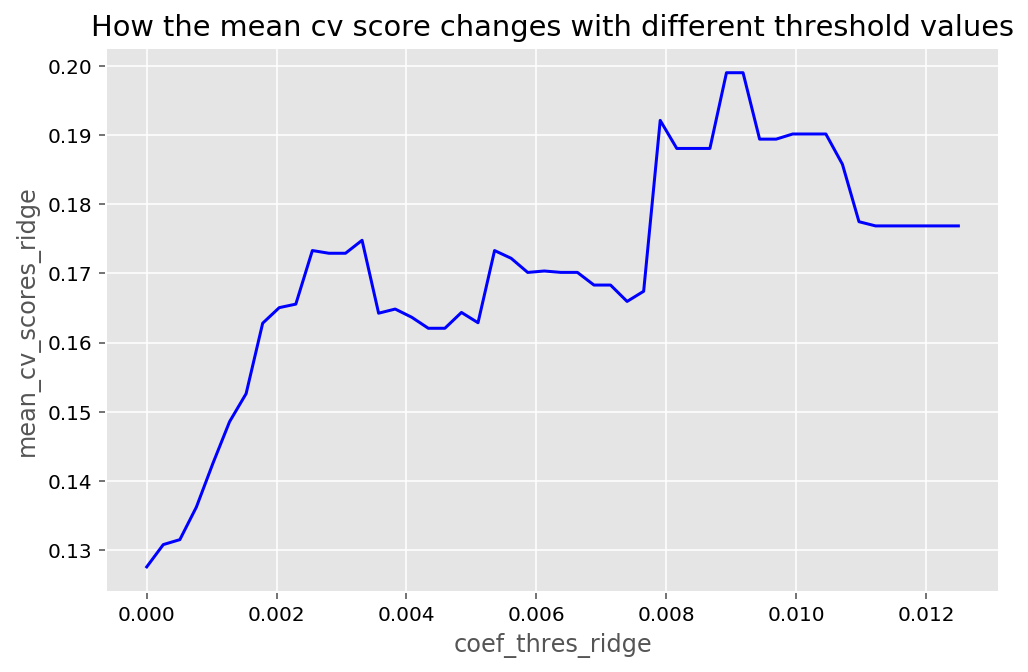

In [130]:
plt.figure(figsize = (8,5))
sns.lineplot(improve_ridge.coef_thres_ridge, improve_ridge.mean_cv_scores_ridge, color = 'b')
plt.title('How the mean cv score changes with different threshold values')
plt.xticks(color = 'k')
plt.yticks(color = 'k')
plt.show()

#### Optimal Ridge

In [131]:
opt_thres_ridge = improve_ridge['coef_thres_ridge'].iloc[0]
columns_keep_ridge = coef_ridge[coef_ridge.coef_ridge_abs > opt_thres_ridge].index
X_opt = X_pre_std.loc[:, columns_keep_ridge]
print(opt_thres_ridge)

0.00892857142857143


Optimal intercept(Ridge): -9.800344704191896e-17
Optimal alpha (Ridge): 0.3593813663804626
Optimal CV Score (Ridge): 0.19899268469835557
Optimal Train Score (Ridge): 0.21182063618875066
Optimal Test Score (Ridge): 0.10779911217136973


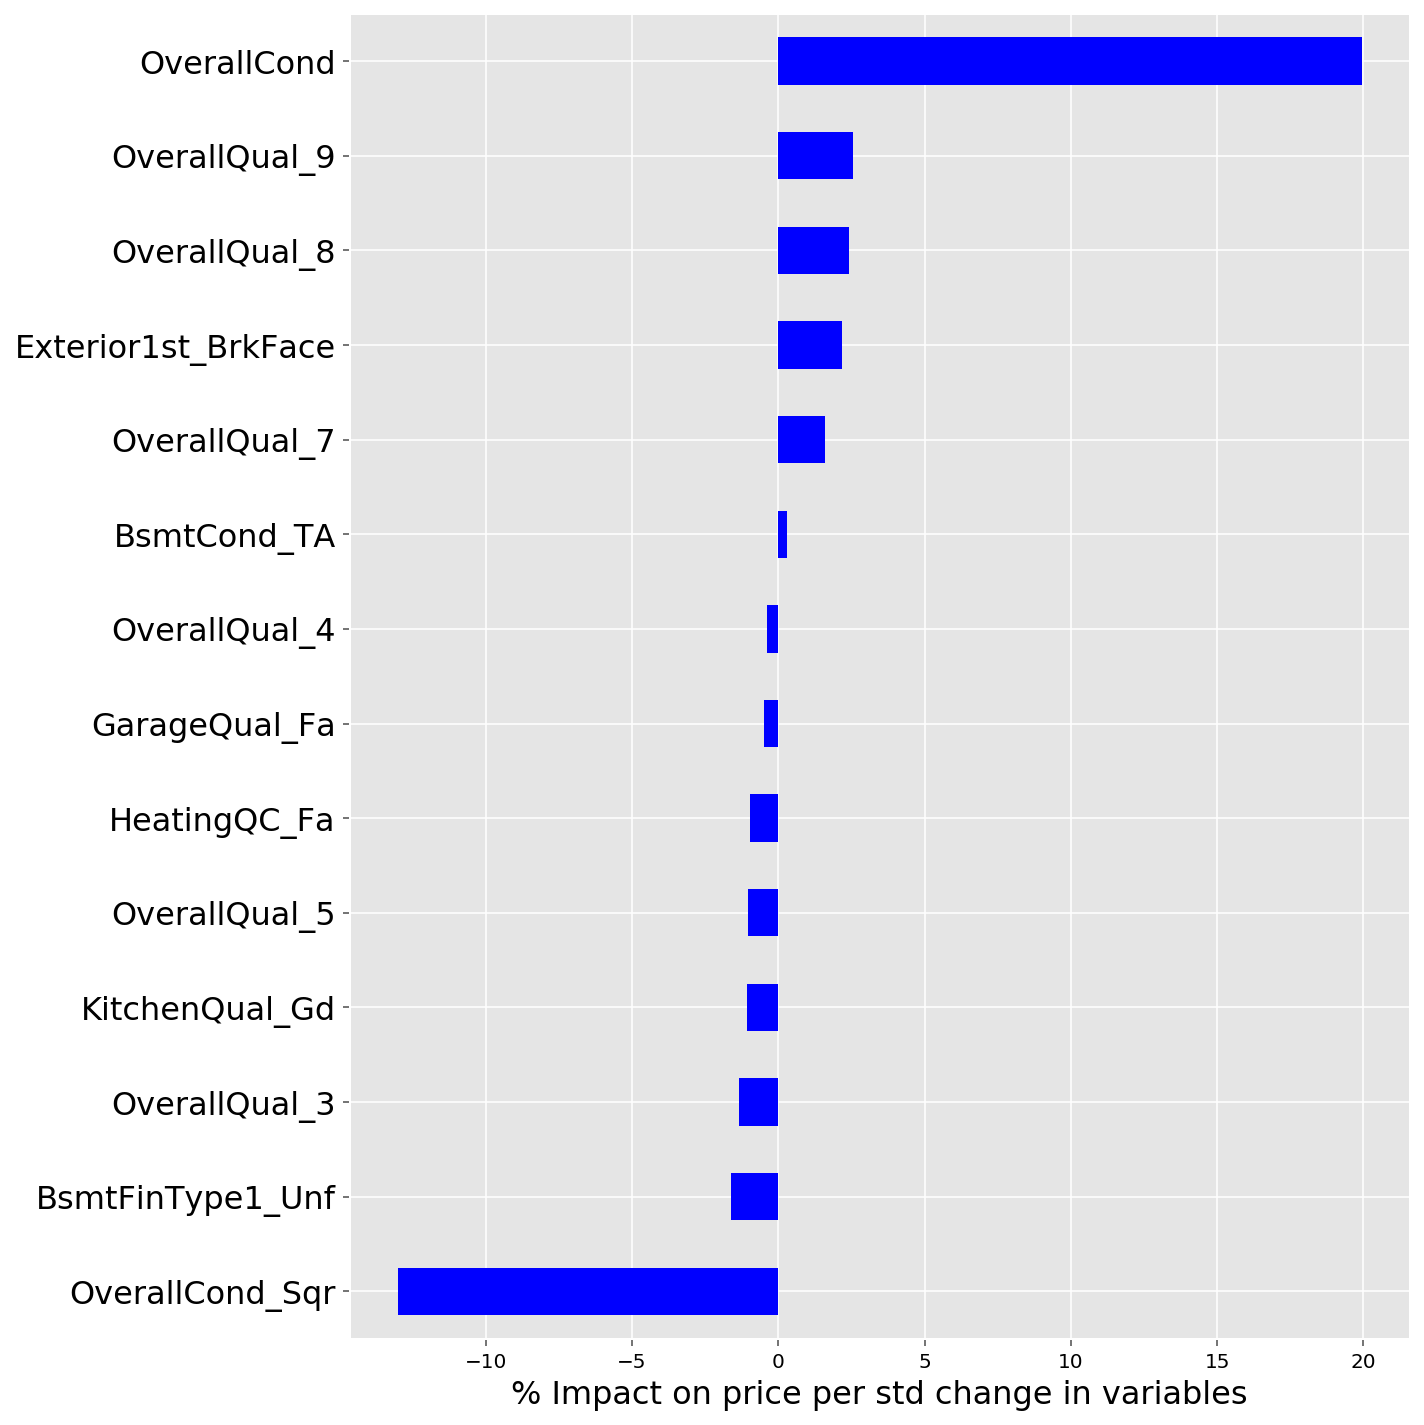

In [132]:
#Sense checking the optimal Ridge model
ridgeCV_opt = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=kf)
ridgeCV_opt.fit(X_opt, y_pre_2010)

#Cross Validation 
ridge_opt = Ridge(alpha=ridgeCV_opt.alpha_)

print(f'Optimal intercept(Ridge): {ridgeCV_opt.intercept_}')
print(f'Optimal alpha (Ridge): {ridgeCV_opt.alpha_}')
print(f'Optimal CV Score (Ridge): {cross_val_score(ridge_opt, X_opt, y_pre_2010, cv = kf).mean()}')
print(f'Optimal Train Score (Ridge): {ridgeCV_opt.score(X_opt, y_pre_2010)}')
print(f'Optimal Test Score (Ridge): {ridgeCV_opt.score(X_post_std.loc[:, columns_keep_ridge], y_post_2010)}')

#Visualising the optimal coefficients 
coef_ridge = pd.DataFrame(ridgeCV_opt.coef_, index=X_opt.columns,
                       columns=['coef_ridge'])
coef_ridge['coef_ridge_abs'] = coef_ridge.coef_ridge.abs()
coef_ridge['coef_ridge_price_impact'] = 100*(np.exp(coef_ridge.coef_ridge)-1)

plt.figure(figsize = (10,10))
coef_ridge['coef_ridge_price_impact'].sort_values().plot(kind='barh', color = 'b');
plt.xlabel('% Impact on price per std change in variables', fontsize = 16, color = 'k')
plt.xticks(color = 'k')
plt.yticks(fontsize=16, color = 'k');

### ElasticNet CV - best score: 0.143133 

In [133]:
elasticnetCV = ElasticNetCV(n_alphas = 100, l1_ratio=np.array([.8, .85, .9, .95, .97, .99, 1]), cv=kf)
elasticnetCV.fit(X_pre_std, y_pre_2010)

train_score = elasticnetCV.score(X_pre_std, y_pre_2010)
test_score = elasticnetCV.score(X_post_std, y_post_2010)

#Cross Validation 
elasticnet = ElasticNet(alpha=elasticnetCV.alpha_, l1_ratio = elasticnetCV.l1_ratio_)
cv_score = cross_val_score(elasticnet, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {elasticnetCV.intercept_}')
print(f'Model coeff: {elasticnetCV.coef_}')
print(f'Model alpha: {elasticnetCV.alpha_}')
print(f'Model l1_ratio: {elasticnetCV.l1_ratio_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036222443384197334, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00413067708033843, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041868605035624284, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003140557744814032, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003352219773947951, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003376463920627515, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037671845533608916, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004277129149237169, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004322726548490863, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032409040357457286, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003460776697092882, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034769365627536075, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did no

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009130553206750491, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00896889789373212, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008685402860473701, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did no

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033332932254257486, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003560502518073605, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035689238514162724, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did no

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009661499493120118, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009579984148345488, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009476950743735557, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did n

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004055399737460164, tolerance: 0.0019553009662867573
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005880010552088422, tolerance: 0.0019553009662867573
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032791279549542196, tolerance: 0.0019553009662867573
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008509540512514846, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002254186635942901, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005236706101612754, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did n

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00493830235078363, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004667569343082434, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004088988553569095, tolerance: 0.0019553009662867573
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did no

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003195083302733437, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008333597149659866, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008587778044121919, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did n

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004119257735805348, tolerance: 0.0019553009662867573
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005991567145750665, tolerance: 0.0019553009662867573
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003281333450056323, tolerance: 0.0019553009662867573
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did n

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003283670925531723, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008455966369544043, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0053804525207166165, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004132947833602074, tolerance: 0.0019553009662867573
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0060168112833753895, tolerance: 0.0019553009662867573
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032801845869521173, tolerance: 0.0019553009662867573
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003327185372189234, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008515930468288246, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003333753904207981, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did n

Model intercept: -1.1571839126088596e-16
Model coeff: [ 3.54304644e-02  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -9.55476342e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -4.10605355e-03  1.68155238e-02
 -0.00000000e+00  1.09893241e-03 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  6.01991493e-04 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -2.70329362e-03  0.00000000e+00  6.51420717e-05 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -7.06649741e-04  1.07316502e-04 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -1.63642594e-03 -0.00000000e+00  0.00000000e+00  7.34456885e-05
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  4.30769568e-04
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.23442338e-02 -2.